In [1]:
import pytesseract
from PIL import Image
import cv2 
import openai
import os
import getpass 
import tqdm 
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import pickle
import ast
import torch
import json 




from StringUtils import CorrectDigits, AssignNERTags, AssignLabel
from OCRUtils import apply_tesseract,DrawBoundBoxes,denormalize_box, ProcessImage


from transformers import (LayoutLMv2FeatureExtractor,
                          LayoutLMv2ForTokenClassification,
                          LayoutLMv2Processor, LayoutLMv2TokenizerFast,
                          PreTrainedTokenizerBase, Trainer, TrainingArguments)


## Cleaning of Receipts Dataset

In [12]:
datasetreceipts = pd.read_csv('./DatasetReceiptsGPTApi')

datasetreceipts = datasetreceipts.drop(columns='Unnamed: 0')

datasetreceipts['entities'] = datasetreceipts['entities'].apply(lambda x : ast.literal_eval(x))
datasetreceipts['words'] = datasetreceipts['words'].apply(lambda x : ast.literal_eval(x))
datasetreceipts['boxes'] = datasetreceipts['boxes'].apply(lambda x : ast.literal_eval(x))


datasetreceipts

,filename,entities,ner_tags,words,boxes
0,1000-receipt.jpg,"{'COMPANY': '0', 'LOCATION': 'Long Beach, CA',...","['O', 'O', 'LOCATION', 'LOCATION', 'LOCATION',...","[5305, E, PACIFIC, COAST, HWY, Long, Beach,, C...","[[363, 312, 421, 328], [436, 312, 450, 328], [..."
1,1001-receipt.jpg,"{'COMPANY': '0', 'LOCATION': 'Roosevelt Field'...","['O', 'COMPANY', 'COMPANY', 'LOCATION', 'LOCAT...","[GRAND, TUX, CAFE, Roosevelt, Field, ©, 4, 048...","[[155, 97, 431, 142], [455, 101, 605, 160], [6..."
2,1002-receipt.jpg,"{'COMPANY': '0', 'LOCATION': '0', 'DATE': '0',...","['O', 'TOTAL', 'DATE', 'TAX', 'COMPANY', 'TOTA...","[4.99, 2.00, 09, 1.99, SubTotal, 6.9, 1, oes, ...","[[456, 452, 491, 464], [455, 465, 490, 478], [..."
3,1003-receipt.jpg,"{'COMPANY': 'Tide', 'LOCATION': 'Miami, FL 331...","['O', 'O', 'LOCATION', 'LOCATION', 'LOCATION',...","[AE, aide, Miami,, FL, 33176, (305), 386-6638,...","[[366, 125, 410, 152], [368, 127, 583, 175], [..."
4,1005-receipt.jpg,"{'COMPANY': '0', 'LOCATION': 'San Diego, CA, 9...","['COMPANY', 'O', 'LOCATION', 'LOCATION', 'LOCA...","[‘SASKA'S, 3766, Mission, Blvd, San, Diego, CA...","[[445, 247, 516, 260], [391, 263, 433, 275], [..."
...,...,...,...,...,...
197,1216-receipt.jpg,"{'COMPANY': 'Kai Susht Dining', 'LOCATION': '7...","['O', 'O', 'O', 'COMPANY', 'O', 'LOCATION', 'L...","[Kai, Susht, “&’, Dining, 720, St, Michaels, O...","[[458, 130, 530, 141], [385, 144, 453, 157], [..."
198,1217-receipt.jpg,"{'COMPANY': 'THAI HOT', 'LOCATION': 'MINOT, ND...","['O', 'O', 'O', 'LOCATION', 'LOCATION', 'LOCAT...","[THAI, HOT, 101, CENTRAL, AVE, W, MINOT,, ND, ...","[[418, 70, 511, 102], [528, 72, 608, 104], [36..."
199,1218-receipt.jpg,"{'COMPANY': '0', 'LOCATION': '638 Grants Ferry...","['O', 'O', 'COMPANY', 'COMPANY', 'LOCATION', '...","[DINE, it, Golden, China, 638, Grants, Ferry, ...","[[698, 163, 783, 178], [800, 163, 833, 176], [..."
200,1220-receipt.jpg,"{'COMPANY': 0, 'LOCATION': 'SEVILLA', 'DATE': ...","['O', 'LOCATION', 'LOCATION', 'COMPANY', 'O', ...","[ja, San, Telmo, PASEO, eA, Ma, DE, RIBERA,, 4...","[[275, 158, 323, 184], [358, 155, 451, 181], [..."


In [29]:
datasetreceipts = pd.read_pickle('./DatasetReceiptsGPTAPI')

In [59]:
folder_path = './receiptsDataset/images'
for indx, row in tqdm(datasetreceipts.iterrows()):
    filename = row['filename']

    if filename[-4:] != '.jpg':

        if filename[-4:]== 'jpeg':

            filename = filename[:-4] + 'jpg'

        else : 
            filename = filename[:-4] + '.jpg'
    file_path = os.path.join(folder_path,filename)


    image = cv2.imread(file_path)

    image = ProcessImage(image=image)

    words, boxes = apply_tesseract(image)
    CorrectedWords = []
    for word in words :
        CorrectedWords.append(CorrectDigits(word))

    row['words'] = CorrectedWords
    row['boxes'] = boxes


datasetreceipts

202it [01:05,  3.10it/s]


,filename,entities,ner_tags,words,boxes
0,1000-receipt.jpg,"{'COMPANY': 'E PACIFIC COAST HWY', 'LOCATION':...","[O, COMPANY, COMPANY, COMPANY, COMPANY, LOCATI...","[5305, E, PACIFIC, COAST, HWY, Long, Beach,, C...","[[363, 312, 421, 328], [436, 312, 450, 328], [..."
1,1001-receipt.jpg,"{'COMPANY': 'Grand Tux Cafe', 'LOCATION': 'Roo...","[LOCATION, LOCATION, O, O, O, O, O, O, O, O, O...","[GRAND, TUX, CAFE, Roosevelt, Field, ©, 4, 048...","[[155, 97, 431, 142], [455, 101, 605, 160], [6..."
2,1002-receipt.jpg,"{'COMPANY': 'MOBILE', 'LOCATION': '571899.', '...","[O, O, O, O, O, O, O, O, TOTAL]","[4.99, 2.00, 09, 1.99, SubTotal, 6.9, 1, oes, ...","[[456, 452, 491, 464], [455, 465, 490, 478], [..."
3,1003-receipt.jpg,"{'COMPANY': 'Tide', 'LOCATION': 'Miami, FL 331...","[O, O, LOCATION, LOCATION, O, O, O, O, O, O, O...","[AE, aide, Miami,, FL, 33176, (305), 386-6638,...","[[366, 125, 410, 152], [368, 127, 583, 175], [..."
4,1005-receipt.jpg,"{'COMPANY': 'SASKA', 'LOCATION': '3766 Mission...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[‘SASKA'S, 3766, Mission, Blvd, San, Diego, CA...","[[445, 247, 516, 260], [391, 263, 433, 275], [..."
...,...,...,...,...,...
197,1216-receipt.jpg,"{'COMPANY': 'Kai Susht Dining', 'LOCATION': '7...","[O, O, O, COMPANY, LOCATION, LOCATION, LOCATIO...","[Kai, Susht, “&’, Dining, 720, St, Michaels, O...","[[458, 130, 530, 141], [385, 144, 453, 157], [..."
198,1217-receipt.jpg,"{'COMPANY': 'THAI HOT', 'LOCATION': 'MINOT, ND...","[O, COMPANY, COMPANY, O, O, O, O, LOCATION, LO...","[THAI, HOT, 101, CENTRAL, AVE, W, MINOT,, ND, ...","[[418, 70, 511, 102], [528, 72, 608, 104], [36..."
199,1218-receipt.jpg,"{'COMPANY': 'Golden China', 'LOCATION': '638 G...","[O, O, COMPANY, COMPANY, LOCATION, LOCATION, L...","[DINE, it, Golden, China, 638, Grants, Ferry, ...","[[698, 163, 783, 178], [800, 163, 833, 176], [..."
200,1220-receipt.jpg,"{'COMPANY': 0, 'LOCATION': 'SEVILLA', 'DATE': ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[ja, San, Telmo, PASEO, eA, Ma, DE, RIBERA,, 4...","[[275, 158, 323, 184], [358, 155, 451, 181], [..."


In [60]:
message_prompt = """You are POS receipt data expert, parse, detect, recognize and convert following receipt OCR image result into structure receipt data object. 
Don't make up value not in the Input. Output must be a well-formed JSON object. give me ONLY the list of:
- date named entity (DD/MM/YYYY only format)
- ADDRESS named entity
- COMPANY named entity
- tax value entity
- Total price value entity
- Currency value entity (euro USD etc ...)
Format the output in json with the following keys:
- COMPANY for organization named entity
- ADDRESS for location named entity
- DATE for date named entity
- TAX for tax value entity
- TOTAL for total price
- CURRENCY for currency value


it is important to find CURRENCY and TAX

And Make sure to not confuse COMPANY and ADDRESS as it is important

list of words below: """

for indx, row in tqdm(datasetreceipts.iterrows()):
    words = row['words']
    sentence = str(words)
    message = message_prompt + sentence

    try:
        # GPT API Prompt
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {
                    "role": "user",
                    "content": message
                }
            ],
            temperature=0.7,
            max_tokens=400,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0
        )

        DictResponse = ast.literal_eval(response.choices[0].message.content)

        print(DictResponse)

        row['entities'] = DictResponse
        
    except Exception as e:
        print(f"Error processing file {row['filename']}: {e}")

        continue

1it [00:02,  2.23s/it]

{'COMPANY': 'E PACIFIC COAST HWY', 'LOCATION': 'Long Beach, CA', 'DATE': '26/05/2016', 'TAX': '1.69', 'TOTAL': '51.90', 'CURRENCY': '0'}


2it [00:04,  1.99s/it]

{'COMPANY': 'GRAND TUX CAFE', 'LOCATION': 'Roosevelt Field', 'DATE': '04/25/15', 'TAX': '5.50', 'TOTAL': '69.25', 'CURRENCY': '0'}


3it [00:05,  1.77s/it]

{'COMPANY': 'MOBILE ORDERING', 'LOCATION': 0, 'DATE': '09/16/2021', 'TAX': 0, 'TOTAL': '6.9', 'CURRENCY': 0}


4it [00:07,  1.77s/it]

{'COMPANY': 'Tide & B', 'LOCATION': 'Miami, FL 33176', 'DATE': {'SETTLED': '4/20/2017', 'CREATED': '4/20/2017'}, 'TAX': 0, 'TOTAL': 0, 'CURRENCY': 0}


5it [00:09,  1.77s/it]

{'COMPANY': "SASKA'S", 'LOCATION': '3766 Mission Blvd, San Diego, CA, 92109', 'DATE': '08/15/2017', 'TAX': '12.94', 'TOTAL': '179.94', 'CURRENCY': '€'}


6it [00:10,  1.75s/it]

{'COMPANY': 'Aklta wey AY 43077 - Mathes ane Mas Eda ETOH', 'LOCATION': '0', 'DATE': '0', 'TAX': 0, 'TOTAL': 0, 'CURRENCY': 0}


7it [00:12,  1.83s/it]

{'COMPANY': 'Zy Katana Sushi', 'LOCATION': '2818 Hawitt Ave Everett, WA 98201', 'DATE': '05/11/18', 'TAX': '$12.71', 'TOTAL': '$143.71', 'CURRENCY': '0'}


8it [00:14,  1.78s/it]

{'COMPANY': 'Dona Mercedes Restaurant', 'LOCATION': '1030 1/2 San Fernando Rd San Fernando CA 91341', 'DATE': '0', 'TAX': '$2.22', 'TOTAL': '$24.47', 'CURRENCY': '0'}


9it [00:15,  1.68s/it]

{'COMPANY': 'MILA TASTA', 'LOCATION': '0', 'DATE': '0', 'TAX': '0', 'TOTAL': '0', 'CURRENCY': '0'}


10it [00:17,  1.67s/it]

{'COMPANY': "Friendly Red's of Windham", 'LOCATION': 'Windham, NH', 'DATE': '07/21/2018', 'TAX': '6.43', 'TOTAL': '77.83', 'CURRENCY': '$'}


11it [00:19,  1.72s/it]

{'COMPANY': 'Quick Live City Market', 'LOCATION': '8242 Van Nuys BLVD Sherman Oaks, CA 91401', 'DATE': '26/06/2015', 'TAX': '5.32', 'TOTAL': '64.43', 'CURRENCY': '$'}


12it [00:21,  1.73s/it]

{'COMPANY': 'HP Pho Ga', 'LOCATION': '8830 Mission Dr. #102 Rasemead,CA 91770', 'DATE': '01/04/2019', 'TAX': '2.11', 'TOTAL': '24.36', 'CURRENCY': '$'}


13it [00:22,  1.74s/it]

{'COMPANY': 'ALBETOS MEXICAN FOOD', 'LOCATION': '14732 ARTESIA BLVD. ARTESIA, CA.', 'DATE': 0, 'TAX': 0, 'TOTAL': 0, 'CURRENCY': 0}


14it [00:24,  1.80s/it]

{'COMPANY': 'Loaded Cafe', 'LOCATION': 'Bellflower Blvd Ber iower, CA 90706', 'DATE': '23/02/2019', 'TAX': '48.53', 'TOTAL': 0, 'CURRENCY': 0}


15it [00:26,  1.84s/it]

{'COMPANY': 'HAMMOCKS TRADING COMPANY', 'LOCATION': 'Sandy Springs, Georgia', 'DATE': '3/10/2017', 'TAX': '3.29', 'TOTAL': '50.23', 'CURRENCY': '$'}


16it [00:28,  1.79s/it]

{'COMPANY': 'Chef Wang', 'LOCATION': '1902 Jericho Tumpike New Hyde Park NY 11040', 'DATE': '02/02/2019', 'TAX': 0, 'TOTAL': 0, 'CURRENCY': 0}


17it [00:30,  1.85s/it]

{'COMPANY': 'UMIX 4327 N. Expressway', 'LOCATION': 'Brownsville, TX 78621', 'DATE': '4/24/2016', 'TAX': '0.84', 'TOTAL': '1.04', 'CURRENCY': '0'}


18it [00:32,  1.82s/it]

{'COMPANY': 'BURGER SANTA CLARA', 'LOCATION': 'SANTA CLARA', 'DATE': '12/04/2027', 'TAX': '8.25%', 'TOTAL': '$2.17', 'CURRENCY': '$'}


19it [00:33,  1.69s/it]

{'COMPANY': 'Tide Mh', 'LOCATION': 0, 'DATE': 0, 'TAX': 0, 'TOTAL': 0, 'CURRENCY': 0}


20it [00:35,  1.72s/it]

{'COMPANY': 'HAWWI ETHIOPIAN RESTAU', 'LOCATION': '1126 QUEEN ST ALEXANDRIA, VA 22314', 'DATE': '03/07/2018', 'TAX': 0, 'TOTAL': '62.85', 'CURRENCY': '$'}


21it [00:37,  1.88s/it]

{'COMPANY': 'Moonstar Restaurant', 'LOCATION': '383 Gellert Blvd.. Daly City, CA 94015', 'DATE': '90/29/2018', 'TAX': 0, 'TOTAL': 0, 'CURRENCY': 0}


22it [00:39,  1.92s/it]

{'COMPANY': 'GUSTO Thai Gusto Restaurant', 'LOCATION': '2011 Hewitt Ave Everett WA 98201', 'DATE': '0', 'TAX': '0', 'TOTAL': '$30.15', 'CURRENCY': '$'}


23it [00:41,  1.91s/it]

{'COMPANY': 'New Asia Buffet', 'LOCATION': '14727.5 Rinaldi St. San Fernando, CA', 'DATE': '15/06/2006', 'TAX': '2.80', 'TOTAL': '33.92', 'CURRENCY': '$'}


24it [00:43,  1.77s/it]

{'COMPANY': "McDonald's", 'LOCATION': 0, 'DATE': '20/13/08', 'TAX': '2.13', 'TOTAL': '435', 'CURRENCY': 0}


25it [00:44,  1.78s/it]

{'COMPANY': '& HAMURGERS', 'LOCATION': '7101 ATLANT TC AVE. CUDRY C4. 90201', 'DATE': '02/22/2018', 'TAX': '0.07', 'TOTAL': '51.82', 'CURRENCY': '$'}


26it [00:46,  1.89s/it]

{'COMPANY': 'MANL, HAWA|| Longboards', 'LOCATION': 'Waipahe Place, Kapolei, HI 96707', 'DATE': '01/11/2019', 'TAX': '4.7128', 'TOTAL': '143', 'CURRENCY': '$'}


27it [00:48,  1.82s/it]

{'COMPANY': 'AOUBLAS BURGERS', 'LOCATION': '0', 'DATE': '0', 'TAX': '0', 'TOTAL': '0', 'CURRENCY': '0'}


28it [00:50,  1.86s/it]

{'COMPANY': 'RINCON MEXICANO', 'LOCATION': '99 BROADWAY SOMERVILLE, MA 02146', 'DATE': '09/05/2017', 'TAX': 0, 'TOTAL': 0, 'CURRENCY': 0}


29it [00:52,  1.80s/it]

{'COMPANY': "RESTAURANT Ville D'Este", 'LOCATION': 'Senter', 'DATE': '12/9/2017', 'TAX': 4.78, 'TOTAL': 28.95, 'CURRENCY': '€'}


30it [00:54,  1.92s/it]

{'COMPANY': 'Laurel Tavern Hermosa Beach', 'LOCATION': '1220 Yernusa Beach, Hermosa Beach, CA 90254', 'DATE': '01/12/2019', 'TAX': '4.85', 'TOTAL': '40.50', 'CURRENCY': '$'}


31it [00:56,  1.89s/it]

{'COMPANY': 'WINGS & THINGS', 'LOCATION': 'ELMONT, NY 11003', 'DATE': '19/03/2017', 'TAX': 0, 'TOTAL': 9.5, 'CURRENCY': '0'}


32it [00:58,  1.86s/it]

{'COMPANY': 'Renaissance Parkway', 'LOCATION': 'purham, NC 2771', 'DATE': '05/10/2019', 'TAX': '3.96', 'TOTAL': '46.73', 'CURRENCY': '0'}


33it [00:59,  1.71s/it]

{'COMPANY': 'PERRIER', 'LOCATION': '0', 'DATE': '0', 'TAX': '0', 'TOTAL': '0', 'CURRENCY': '0'}


34it [01:01,  1.69s/it]

{'COMPANY': 'Please Pay at Cashier', 'LOCATION': '1084 Yonkers Avenue Yonkers, NY 10704', 'DATE': '0', 'TAX': '0', 'TOTAL': '$4.50', 'CURRENCY': '0'}


35it [01:03,  1.86s/it]

{'COMPANY': 'PAPPADEAUX SEAPOOD KITCHEN', 'LOCATION': '1304 Copeland Rd, Arlington, TK 76011', 'DATE': '1/18/17', 'TAX': '3.51', 'TOTAL': '52.76', 'CURRENCY': '0'}


36it [01:04,  1.79s/it]

{'COMPANY': 'Store H24t Pan Evoress', 'LOCATION': 'Everett, WA', 'DATE': '3/16/2019', 'TAX': '13.89', 'TOTAL': '164.89', 'CURRENCY': '0'}


37it [01:06,  1.79s/it]

{'COMPANY': 'Deno System deloone', 'LOCATION': '12502 North Kendall Drive Niemi, FL 33186', 'DATE': '07/09/2018', 'TAX': 0, 'TOTAL': '17.80', 'CURRENCY': '0'}


38it [01:08,  1.80s/it]

{'COMPANY': "CARL'S", 'LOCATION': 'Santa Fe', 'DATE': '12/19/2016', 'TAX': '$0.97', 'TOTAL': '$13.05', 'CURRENCY': '$'}


39it [01:10,  1.80s/it]

{'COMPANY': 'SUKH@THAT 4 407HAI susil + ASIAN on Fuse VE UNIT 36', 'LOCATION': 0, 'DATE': '19-Apr-2019', 'TAX': '$3.45', 'TOTAL': '$28.04', 'CURRENCY': '$'}


40it [01:11,  1.64s/it]

{'COMPANY': 'PERRIER', 'LOCATION': 0, 'DATE': 0, 'TAX': 0, 'TOTAL': 0, 'CURRENCY': 0}


41it [01:13,  1.69s/it]

{'COMPANY': 'YAM WAC & CHEESE', 'LOCATION': 'YONKERS, NY', 'DATE': '23/06/2019', 'TAX': 0, 'TOTAL': 'Discount Total', 'CURRENCY': 0}


42it [01:14,  1.57s/it]

{'COMPANY': '0', 'LOCATION': '0', 'DATE': '0', 'TAX': '0', 'TOTAL': '0', 'CURRENCY': '0'}


43it [01:16,  1.73s/it]

{'COMPANY': 'Araxi Burger Aventura', 'LOCATION': 'Aventura, FL 33160', 'DATE': '03/17/19', 'TAX': '10%', 'TOTAL': '$38.86', 'CURRENCY': '$'}


44it [01:18,  1.70s/it]

{'COMPANY': 'Kitche!', 'LOCATION': '730 Hass Ave', 'DATE': '23/08/2017', 'TAX': '5.87', 'TOTAL': '85.07', 'CURRENCY': '$'}


45it [01:20,  1.71s/it]

{'COMPANY': 'EXCELLENCE SERVED DAILY', 'LOCATION': '2501 Colorado Ave Santa Monica, CA 90404', 'DATE': '11/01/2018', 'TAX': '8.50', 'TOTAL': '91.45', 'CURRENCY': '$'}


46it [01:22,  1.80s/it]

{'COMPANY': 'Add Tequila', 'LOCATION': 'Kapolei Parkway, Suite 426', 'DATE': '07/18/2019', 'TAX': 0, 'TOTAL': '0', 'CURRENCY': '0'}


47it [01:23,  1.70s/it]

{'COMPANY': 'HOLLYWOOD CAFE', 'LOCATION': 'CA', 'DATE': '0', 'TAX': '1.74', 'TOTAL': '0', 'CURRENCY': '0'}


48it [01:25,  1.86s/it]

{'COMPANY': 'GENERAL POOR’S TAVERN', 'LOCATION': '45 MAIN STREET HACKENSACK, NJ 07601', 'DATE': '04/10/16', 'TAX': '$0.70', 'TOTAL': '$10.70', 'CURRENCY': '$'}


49it [01:29,  2.27s/it]

{'COMPANY': 'Nancy #8 28-41 Jericho Tumptke Floral Park, iY 11003 Tal; 718.34-4616 Wen Ranicystestaurant nat 106 Tow tek:', 'LOCATION': 'Nancy #8 28-41 Jericho Tumptke Floral Park, iY 11003 Tal; 718.34-4616 Wen Ranicystestaurant nat 106 Tow tek:', 'DATE': '19/24/2018', 'TAX': '0.40', 'TOTAL': '94.18', 'CURRENCY': 'USD'}


50it [01:30,  2.07s/it]

{'COMPANY': 'Primo Family Re Restaurant', 'LOCATION': '0', 'DATE': '0', 'TAX': '0', 'TOTAL': '27.00', 'CURRENCY': '€'}


51it [01:32,  1.97s/it]

{'COMPANY': "BIG Jo's", 'LOCATION': 'SANTA MONICA, CA 90404', 'DATE': '25/01/2018', 'TAX': '$5.25', 'TOTAL': '$56.50', 'CURRENCY': '$'}


52it [01:34,  1.93s/it]

{'COMPANY': 'WINGS & THINGS', 'LOCATION': '519 FULTON AVE. HEMPSTEAD NY', 'DATE': '0', 'TAX': '0', 'TOTAL': '0', 'CURRENCY': '0'}


53it [01:36,  2.01s/it]

{'COMPANY': 'CAFE PARISIEN LARCHMONT LLC', 'LOCATION': 'LOS ANGELES, CA 90004', 'DATE': '24/01/2019', 'TAX': '$0.83', 'TOTAL': '$9.58', 'CURRENCY': '0'}


54it [01:38,  1.87s/it]

{'COMPANY': 'LANDFALL RESTAURANT', 'LOCATION': '0', 'DATE': '06/10/17', 'TAX': '0', 'TOTAL': '18', 'CURRENCY': '0'}


55it [01:39,  1.89s/it]

{'COMPANY': 'Karma Cab Sauv', 'LOCATION': 'India Street', 'DATE': '12/17/2017', 'TAX': '6.00', 'TOTAL': '83.50', 'CURRENCY': 0}


56it [01:42,  1.94s/it]

{'COMPANY': "Chili's Gril} & Bar", 'LOCATION': 'City of Industry, CA 91748', 'DATE': '09/15/20', 'TAX': '2.29', 'TOTAL': '26.37', 'CURRENCY': '$'}


57it [01:43,  1.83s/it]

{'COMPANY': 'rrimo Family Restaurant', 'LOCATION': 'Bld ORO', 'DATE': '9/99', 'TAX': 0, 'TOTAL': 0, 'CURRENCY': 0}


58it [01:45,  1.80s/it]

{'COMPANY': 'IN-N-OUT BURGER', 'LOCATION': 'ESCONDIDO', 'DATE': '2019-06-10', 'TAX': '8.00%', 'TOTAL': '19.44', 'CURRENCY': '$'}


59it [01:47,  1.85s/it]

{'COMPANY': 'Taco Maria', 'LOCATION': '3313 Hyland Av4. Ste C21, Costa Mesa, CA 92626', 'DATE': '1/23/18', 'TAX': '$7.65', 'TOTAL': '$45.79', 'CURRENCY': '$'}


60it [01:49,  1.86s/it]

{'COMPANY': 'Anjappar', 'LOCATION': 'Artesia, Ca 90701', 'DATE': '0', 'TAX': '0', 'TOTAL': '0', 'CURRENCY': '0'}


61it [01:51,  2.08s/it]

{'COMPANY': 'Supene marries', 'LOCATION': 'Solan Avene Abbr', 'DATE': '4/10/2016', 'TAX': '0', 'TOTAL': '0', 'CURRENCY': '0'}


62it [01:53,  1.98s/it]

{'COMPANY': 'Haron Riker OF Rockwood', 'LOCATION': 'River Village', 'DATE': '02/19', 'TAX': '90.62', 'TOTAL': '$10.90', 'CURRENCY': '$'}


63it [01:55,  1.97s/it]

{'COMPANY': "H's Hot Wings & Things", 'LOCATION': '886 N. Garfield Ave Montebello, CA 90640', 'DATE': '6/28/2019', 'TAX': '0', 'TOTAL': '0', 'CURRENCY': '0'}


64it [01:57,  2.00s/it]

{'COMPANY': 'QHANA HAWATIAN BBO', 'LOCATION': '4469 SLAUSON AVE, Maywood, CA 90270', 'DATE': '6/1/2013', 'TAX': '0', 'TOTAL': '24.35', 'CURRENCY': '0'}


65it [01:59,  2.00s/it]

{'COMPANY': 'Suey4469-0 Phone A76-545-9900', 'LOCATION': 'Fair Dake ave os Pagadend, 91105', 'DATE': '5/1/2019', 'TAX': '10.255', 'TOTAL': '11.99', 'CURRENCY': '$'}


66it [02:01,  1.92s/it]

{'COMPANY': 'Lin Buffet', 'LOCATION': 'Brownsville,TX', 'DATE': '06/02/2019', 'TAX': '0', 'TOTAL': '33.73', 'CURRENCY': '$'}


67it [02:02,  1.81s/it]

{'COMPANY': '0', 'LOCATION': '0', 'DATE': '0', 'TAX': '0', 'TOTAL': '0', 'CURRENCY': '0'}


68it [02:04,  1.78s/it]

{'COMPANY': 'Paradise Restaurant', 'LOCATION': 'Los Angeles, CA 90248', 'DATE': '7/21/2018', 'TAX': '$2.18', 'TOTAL': '$25.70', 'CURRENCY': '$'}


69it [02:06,  1.91s/it]

{'COMPANY': 'NAANCHING', 'LOCATION': '103 MONTGOMERRY ST JERSEY CITY, NJ. 07302', 'DATE': '4-Mat 2019', 'TAX': '$3.71', 'TOTAL': '$69.79', 'CURRENCY': '$'}


70it [02:08,  1.79s/it]

{'COMPANY': 'Facebook Etayhooakland', 'LOCATION': '0', 'DATE': '02/19/2019', 'TAX': '0', 'TOTAL': '16.77', 'CURRENCY': '$'}


71it [02:10,  1.87s/it]

{'COMPANY': 'Falmouth RAW BAR', 'LOCATION': 'Scranton Av4. Falmouth, WA 02540', 'DATE': '07/02/18', 'TAX': '15.38', 'TOTAL': '235.19', 'CURRENCY': '0'}


72it [02:11,  1.80s/it]

{'COMPANY': 'Newark Buffet', 'LOCATION': 'Newark, CA 94560', 'DATE': '08/29/2019', 'TAX': '8.20', 'TOTAL': '92.22', 'CURRENCY': '0'}


73it [02:14,  1.88s/it]

{'COMPANY': 'BRASAS RESTAURANT', 'LOCATION': '6011 W ROOSEVELT RD CICERO, IL 60804', 'DATE': '02/03/2019', 'TAX': '$0.97', 'TOTAL': '$9.97', 'CURRENCY': '0'}


74it [02:15,  1.78s/it]

{'COMPANY': 'SURAT FARSAN MART', 'LOCATION': 'ARTESIA, CA 90701', 'DATE': '0', 'TAX': '0', 'TOTAL': '0', 'CURRENCY': '0'}


75it [02:17,  1.75s/it]

{'COMPANY': 'Vettori arg 328 WashingtonStreet', 'LOCATION': 0, 'DATE': '07/01/2018', 'TAX': 0, 'TOTAL': '$48.00', 'CURRENCY': '$'}


76it [02:18,  1.74s/it]

{'COMPANY': 'Pita Pita - Lonbard', 'LOCATION': '211 E Roosevelt Rd, Lombard, IL 60148', 'DATE': '5/4/2017', 'TAX': '0', 'TOTAL': '180.00', 'CURRENCY': '0'}


77it [02:20,  1.73s/it]

{'COMPANY': 'Calagero’s Calogero’ 919 Frankl', 'LOCATION': 'City, NY 11630', 'DATE': '0', 'TAX': '12.1', 'TOTAL': '157.51', 'CURRENCY': '0'}


78it [02:21,  1.60s/it]

{'COMPANY': '0', 'LOCATION': '0', 'DATE': '0', 'TAX': '0', 'TOTAL': '0', 'CURRENCY': '0'}


79it [02:23,  1.62s/it]

{'COMPANY': 'MOOYAH Burgers Fries Shakes', 'LOCATION': 'Cache Ro tanton, OK', 'DATE': '3/22/2014', 'TAX': 0, 'TOTAL': '$8.98', 'CURRENCY': '$'}


80it [02:25,  1.78s/it]

{'COMPANY': 'Firepoint Grtlt 3739 West Chester Pike Nexto Saare', 'LOCATION': 'PA 19013', 'DATE': 'ww0r/2018', 'TAX': 23.0, 'TOTAL': 142.93, 'CURRENCY': 0}


81it [02:27,  1.81s/it]

{'COMPANY': 'CITY TASTE', 'LOCATION': 'SILVER SPRING, MD 20910', 'DATE': '05-11-2018', 'TAX': '1.63', 'TOTAL': '28.78', 'CURRENCY': '$'}


82it [02:29,  1.85s/it]

{'COMPANY': 'Kalseki Japanese Cuisine', 'LOCATION': 'West Merrick Ra Valley Steam NY', 'DATE': '0', 'TAX': '3.45', 'TOTAL': '43.30', 'CURRENCY': '0'}


83it [02:31,  1.81s/it]

{'COMPANY': "POPEYE'S", 'LOCATION': 'CARRY-QUT, SUN', 'DATE': '24/06/2018', 'TAX': '38.23', 'TOTAL': '38.23', 'CURRENCY': '$'}


84it [02:33,  1.87s/it]

{'COMPANY': 'Pokeatery', 'LOCATION': '18911 Lake Chabot, Castro Valley, CA 94546', 'DATE': '29/12/2018', 'TAX': 0, 'TOTAL': '$13.50', 'CURRENCY': 'dollar'}


85it [02:35,  1.82s/it]

{'COMPANY': 'eeveneoneuvnensnananaauauauunannnnn', 'LOCATION': 0, 'DATE': 0, 'TAX': 0, 'TOTAL': 0, 'CURRENCY': 0}


86it [02:37,  1.88s/it]

{'COMPANY': 'OE 223 N. Citrus Ave', 'LOCATION': 'Covina, CA 91723', 'DATE': '09/25/2018', 'TAX': '$4.08', 'TOTAL': '$46.98', 'CURRENCY': 'dollar'}


87it [02:39,  2.01s/it]

{'COMPANY': 'LOCO EL FeO KIRANT 5451 STORE 5451 7519 S, ATLANTIC AVE.', 'LOCATION': 'CuDAHY,CA 90201', 'DATE': '28/06/2017', 'TAX': '1.06', 'TOTAL': '13.25', 'CURRENCY': '0'}


88it [02:41,  1.98s/it]

{'COMPANY': "Nick's Tuscen Bie", 'LOCATION': 'Mineola, NY 11501', 'DATE': '12/1', 'TAX': '5.39', 'TOTAL': '67.89', 'CURRENCY': '$'}


89it [02:43,  1.96s/it]

{'COMPANY': 'Mexican Restaurant & Bar', 'LOCATION': '25 West San Fernando St. San Jose, CA 95113', 'DATE': '12/23/2017', 'TAX': '5.46', 'TOTAL': '55.51', 'CURRENCY': '$'}


90it [02:44,  1.90s/it]

{'COMPANY': 'SF Stary Bln taontin', 'LOCATION': '0', 'DATE': '18/07/2018', 'TAX': '10.28', 'TOTAL': '815', 'CURRENCY': '0'}


91it [02:46,  1.88s/it]

{'COMPANY': 'KAZ RAMEN', 'LOCATION': 'GRAND TERRACE, CA 92313', 'DATE': '04/11/2018', 'TAX': '$1.01', 'TOTAL': '$14.06', 'CURRENCY': '$'}


92it [02:48,  1.96s/it]

{'COMPANY': 'OM INDIAN FOOD', 'LOCATION': '204 Spring St, New York, NY 10012', 'DATE': 'afts..6 12:03:14 PM', 'TAX': '$1.32', 'TOTAL': '$16.24', 'CURRENCY': '$'}


93it [02:50,  1.92s/it]

{'COMPANY': 'Crisfield Seafood Restaurant', 'LOCATION': '8012 Georgia Av4. Silver Sting', 'DATE': '12/29/2017', 'TAX': '1.83', 'TOTAL': '42.74', 'CURRENCY': '$'}


94it [02:52,  1.86s/it]

{'COMPANY': 'Don Juan Hevican Restaurant', 'LOCATION': '124 East Park Ave Long Beach, NY 11561', 'DATE': '1/6/2013', 'TAX': 0, 'TOTAL': 0, 'CURRENCY': 0}


95it [02:54,  1.83s/it]

{'COMPANY': 'The Place 2 Be', 'LOCATION': '615 Franklin Ave, Hartford, CT 06114', 'DATE': '17-Feb-2018', 'TAX': '50', 'TOTAL': '22.87', 'CURRENCY': '$'}


96it [02:56,  1.86s/it]

{'COMPANY': 'Lan Sheng', 'LOCATION': 'Wallington N. J. 07087', 'DATE': '06/13/17', 'TAX': 0, 'TOTAL': 0, 'CURRENCY': 0}


97it [02:57,  1.76s/it]

{'COMPANY': 'MIKUNI JAPANESE', 'LOCATION': 'Fair Oaks, CA', 'DATE': '42/1', 'TAX': '10.38', 'TOTAL': '144.28', 'CURRENCY': '0'}


98it [02:59,  1.83s/it]

{'COMPANY': 'Hongo BSq 6851 Gtantord Ranch Bd. Rocklin, CA 95677', 'LOCATION': 'Rocklin, CA 95677', 'DATE': '28/01/2016', 'TAX': '$3.52', 'TOTAL': '$48.54', 'CURRENCY': '$'}


99it [03:01,  1.73s/it]

{'COMPANY': 'Fopcom Chicken', 'LOCATION': 0, 'DATE': 0, 'TAX': '$2.28', 'TOTAL': '$27.62', 'CURRENCY': '$'}


100it [03:02,  1.72s/it]

{'COMPANY': 'Chelokababi', 'LOCATION': 'Sunnyvale, CA 94086', 'DATE': '18/08/2018', 'TAX': '18%', 'TOTAL': '$160.07', 'CURRENCY': '$'}


101it [03:04,  1.78s/it]

{'COMPANY': '0', 'LOCATION': '0', 'DATE': '0', 'TAX': '0', 'TOTAL': '0', 'CURRENCY': '0'}


102it [03:06,  1.70s/it]

{'COMPANY': 'CHIU iT an', 'LOCATION': 'HI BEACH, FL 33139', 'DATE': '0', 'TAX': '0', 'TOTAL': '0', 'CURRENCY': '0'}


103it [03:08,  1.78s/it]

{'COMPANY': 'Golden Panda Buffet', 'LOCATION': '14428 Ramona Blvd. #70, Baldwin Park, CA 91706', 'DATE': '6/02/2018', 'TAX': '2.60', 'TOTAL': '29.96', 'CURRENCY': '$'}


104it [03:09,  1.67s/it]

{'COMPANY': 'PERRIER', 'LOCATION': 0, 'DATE': 0, 'TAX': 0, 'TOTAL': 0, 'CURRENCY': 0}


105it [03:11,  1.62s/it]

{'COMPANY': 'Rosebud on Rush', 'LOCATION': 'Chicago, IL', 'DATE': '05/17/2021', 'TAX': 0, 'TOTAL': 0, 'CURRENCY': 0}


106it [03:13,  1.68s/it]

{'COMPANY': 'Villaggio Grille 4780 Wharf Parkway', 'LOCATION': 'Orange Beach, AL 36561', 'DATE': '06/08/2019', 'TAX': '3.41', 'TOTAL': '31.01', 'CURRENCY': '0'}


107it [03:14,  1.75s/it]

{'COMPANY': 'Restaurant FOOOD5675', 'LOCATION': 'Berpan St harriaon, My 07029', 'DATE': '0', 'TAX': 0, 'TOTAL': '3.83', 'CURRENCY': '0'}


108it [03:16,  1.80s/it]

{'COMPANY': 'RED & HOT', 'LOCATION': 'BROOKLYN, NY 11215', 'DATE': '20/10/2018', 'TAX': '1.91', 'TOTAL': '23.46', 'CURRENCY': '0'}


109it [03:18,  1.84s/it]

{'COMPANY': 'Heart of Portugal Restaurant', 'LOCATION': '241 Mineola Bl, Mineola, NY 11', 'DATE': '0', 'TAX': '0', 'TOTAL': '0', 'CURRENCY': '0'}


110it [03:20,  1.79s/it]

{'COMPANY': 'Eson Mexican Restaurant', 'LOCATION': '74 South Purry St, Unit EF, Castle Rock, CO', 'DATE': '0', 'TAX': '0', 'TOTAL': '0', 'CURRENCY': '0'}


111it [03:22,  1.74s/it]

{'COMPANY': 'Gato Negro 300 Harriaon Ave', 'LOCATION': 'New Orleans, LA 70124', 'DATE': '01/08/2019', 'TAX': '2.01', 'TOTAL': '21.76', 'CURRENCY': '0'}


112it [03:24,  1.83s/it]

{'COMPANY': 'Firefly American Bistro', 'LOCATION': '5525 New Albany Road West New Albany, OH 43054', 'DATE': '0', 'TAX': '0', 'TOTAL': '$0.00', 'CURRENCY': '0'}


113it [03:26,  1.88s/it]

{'COMPANY': 'CHATPATA RESTAURANT', 'LOCATION': '1683 ROUTE 9 CLIFTON PARK, NY', 'DATE': '19/03/2019', 'TAX': '$1.25', 'TOTAL': '$19.10', 'CURRENCY': '0'}


114it [03:27,  1.82s/it]

{'COMPANY': 'Le_FRENCH CAFE & WINE BAR', 'LOCATION': '0', 'DATE': '06/02/15', 'TAX': '0', 'TOTAL': '39.18', 'CURRENCY': '0'}


115it [03:29,  1.72s/it]

{'COMPANY': 'Pizza Hut', 'LOCATION': 'NY', 'DATE': '0', 'TAX': '0', 'TOTAL': '0', 'CURRENCY': '0'}


116it [03:31,  1.80s/it]

{'COMPANY': 'KNAVERAS MEXICAN CUISINE & BAR', 'LOCATION': 'BELLFLOWER, CA 90706', 'DATE': '30/08/2019', 'TAX': '$5.99', 'TOTAL': '$68.99', 'CURRENCY': '$'}


117it [03:33,  1.85s/it]

{'COMPANY': 'TT nano JAPANESE RESTAURANT', 'LOCATION': '3007 NE 163RD STREET North Miami Beach, FL 33160', 'DATE': '2/13/2018', 'TAX': '1.28', 'TOTAL': '17.18', 'CURRENCY': '$'}


118it [03:36,  2.13s/it]

{'COMPANY': 'BOA', 'LOCATION': 0, 'DATE': '12/20/17', 'TAX': 0, 'TOTAL': '43.00', 'CURRENCY': 0}


119it [03:37,  2.01s/it]

{'COMPANY': 'Gi as s MBURGERS', 'LOCATION': 'MAYWOOD, CA 90270', 'DATE': '11-24-2017', 'TAX': '$2.46', 'TOTAL': '$28.31', 'CURRENCY': '$'}


120it [03:39,  1.94s/it]

{'COMPANY': 'VIA EMILIA 9', 'LOCATION': 'MIAMI BEACH, FL 33199', 'DATE': '27/04/2017', 'TAX': '$5.10', 'TOTAL': '$61.80', 'CURRENCY': '$'}


121it [03:42,  2.25s/it]

{'COMPANY': 'MOONSTAR RESTAURANT', 'LOCATION': 'GELLERT CITY, CA 94015', 'DATE': '0', 'TAX': '0', 'TOTAL': '148.57', 'CURRENCY': '$'}


122it [03:45,  2.44s/it]

{'COMPANY': 'KFC Restaurant', 'LOCATION': 'Hempstead Turnpike Levittown', 'DATE': '2016-07-08', 'TAX': 0, 'TOTAL': '21.73', 'CURRENCY': 'dollar'}


123it [03:47,  2.32s/it]

{'COMPANY': 'E. BALD! ive 375 North Cano oe erly Hills', 'LOCATION': '90210', 'DATE': '30.01.2018', 'TAX': 0, 'TOTAL': '$146.73', 'CURRENCY': '$'}


124it [03:49,  2.25s/it]

{'COMPANY': 'The Shawarma Factory', 'LOCATION': 'Gardena, CA 90249', 'DATE': '10/04/2019', 'TAX': '$114', 'TOTAL': '$13.13', 'CURRENCY': '$'}


125it [03:51,  2.21s/it]

{'COMPANY': 'akatiac di a ig oa S hai Teriyaki', 'LOCATION': '27000 Marine Ave #103 Redondo Beach, CA 90278', 'DATE': '10/25/2017', 'TAX': 0, 'TOTAL': 38.83, 'CURRENCY': 0}


126it [03:53,  2.06s/it]

{'COMPANY': 'CASA CHAN RESTAURANT', 'LOCATION': 0, 'DATE': '21/12/2014', 'TAX': '$1.70', 'TOTAL': '$25.94', 'CURRENCY': 0}


127it [03:55,  2.05s/it]

{'COMPANY': 'PARADISE dndhra Style Pamiily Restaurant', 'LOCATION': 'BANGALORE*560097', 'DATE': '66.07.2017', 'TAX': 0, 'TOTAL': '617.00', 'CURRENCY': 'R4.'}


128it [03:57,  1.94s/it]

{'COMPANY': 'Shake Shack', 'LOCATION': '1450 Otxte Highway', 'DATE': '12/12/2021', 'TAX': '$0', 'TOTAL': '62.75', 'CURRENCY': '$'}


129it [03:58,  1.91s/it]

{'COMPANY': 'MRR YAUATCHA', 'LOCATION': 'International Market Place 2330 Kalakaua Ave Ste 326 Honolulu, Hawaii 96815', 'DATE': '0', 'TAX': '$3.82', 'TOTAL': '$84.80', 'CURRENCY': '$'}


130it [04:00,  1.86s/it]

{'COMPANY': 'bluebear tavern', 'LOCATION': '11th Street', 'DATE': '01/13/2012', 'TAX': '3.00', 'TOTAL': '52.00', 'CURRENCY': '0'}


131it [04:02,  1.88s/it]

{'COMPANY': 'Arthurs 237 Kashington', 'LOCATION': 'Hoboken, WJ 07030', 'DATE': '01/10/2017', 'TAX': '3.98', 'TOTAL': '84.78', 'CURRENCY': '$'}


132it [04:04,  1.83s/it]

{'COMPANY': 'CHLOE51', 'LOCATION': '81 Ludlow St New York, NY 10002', 'DATE': '08/03/18', 'TAX': '$3.19', 'TOTAL': '$46.40', 'CURRENCY': '0'}


133it [04:06,  1.91s/it]

{'COMPANY': 'MIGUELS MEXICAN', 'LOCATION': '9095 W, Kewl BLVD AMPA (813)', 'DATE': '05/19/2022', 'TAX': '4.77', 'TOTAL': '65.14', 'CURRENCY': '$'}


134it [04:08,  2.02s/it]

{'COMPANY': "Rihanna's Caribbean Restaurant", 'LOCATION': '12709 BEECHNUT ST STE100 HOUSTON, TX 77072', 'DATE': '02/08/2018', 'TAX': '$1.9', 'TOTAL': '$13.6', 'CURRENCY': '$'}


135it [04:10,  1.97s/it]

{'COMPANY': 'Sonic Asarlca’s Urive-In SIG Robertson Boulevard Faltstixiro', 'LOCATION': 'Stall #15', 'DATE': '6/1', 'TAX': '1.18', 'TOTAL': '13.07', 'CURRENCY': '$'}


136it [04:12,  1.91s/it]

{'COMPANY': 'pine Restall rt 48129', 'LOCATION': 'Bethany', 'DATE': '8/30/2015', 'TAX': '0.30', 'TOTAL': '5.99', 'CURRENCY': '$'}


137it [04:13,  1.84s/it]

{'COMPANY': 'ESQUIRE GRILCE SACRAMENTO FTL AIRPORT', 'LOCATION': 'SACRAMENTO', 'DATE': '0', 'TAX': '4.96', 'TOTAL': '74.49', 'CURRENCY': '$'}


138it [04:15,  1.91s/it]

{'COMPANY': "Collector's Cholce Restaura", 'LOCATION': '215 Cypress Ave, Snohomish WA 98290', 'DATE': '10/04/2019', 'TAX': 0, 'TOTAL': 2.44, 'CURRENCY': '¥'}


139it [04:17,  1.80s/it]

{'COMPANY': 'west_katoonrs_ad', 'LOCATION': 'Providenclales', 'DATE': '14/2015', 'TAX': 0, 'TOTAL': 0, 'CURRENCY': 0}


140it [04:19,  1.79s/it]

{'COMPANY': 'Gordon Remsay Steak', 'LOCATION': 'Las Vegas', 'DATE': '10/21/2014', 'TAX': '3.49', 'TOTAL': '313.49', 'CURRENCY': '€'}


141it [04:20,  1.72s/it]

{'COMPANY': 'Via Mar Restaura', 'LOCATION': 'Baldwin park, ca 91708', 'DATE': '9/6/2018', 'TAX': 0, 'TOTAL': 0, 'CURRENCY': 0}


142it [04:22,  1.65s/it]

{'COMPANY': 'IKEA', 'LOCATION': 'MILTON KEYNES', 'DATE': '0', 'TAX': '0', 'TOTAL': '11.25', 'CURRENCY': '£'}


143it [04:24,  1.76s/it]

{'COMPANY': "POLUEGE OF souTuERa HEVADA RUSSELL'S RESTAURANT", 'LOCATION': 'COLLEGE OF SOUTHERN NEVADA', 'DATE': '12/19/2021', 'TAX': 0, 'TOTAL': 7.95, 'CURRENCY': 0}


144it [04:26,  1.93s/it]

{'COMPANY': 'ATASU JAPANESE RESTAURANT', 'LOCATION': 'CENTRAL PLAZA, JALAN SULTAN TSATL, 50280 KUALA LUMPUR', 'DATE': '22/08/2018', 'TAX': '10.0%', 'TOTAL': '780.45', 'CURRENCY': '0'}


145it [04:28,  1.82s/it]

{'COMPANY': 'WENMORE', 'LOCATION': 'WENMORE, WA 68028', 'DATE': '27/08/1108', 'TAX': 0, 'TOTAL': 6.59, 'CURRENCY': 'USD'}


146it [04:29,  1.77s/it]

{'COMPANY': "Angela's Pizza fest", 'LOCATION': 'Sheridan 5 Cooper Cityb, FL', 'DATE': '7/40/2017', 'TAX': '1.8', 'TOTAL': '56', 'CURRENCY': '$'}


147it [04:31,  1.67s/it]

{'COMPANY': '0', 'LOCATION': '0', 'DATE': '11/10/18', 'TAX': '2.74', 'TOTAL': '56.59', 'CURRENCY': '$'}


148it [04:33,  1.75s/it]

{'COMPANY': 'guniper & ivy', 'LOCATION': '2228 Kettaer Blvd gan Diego, OA 92101', 'DATE': '09/199H', 'TAX': 0, 'TOTAL': 333.72, 'CURRENCY': '$'}


149it [04:35,  1.82s/it]

{'COMPANY': 'BEN’S BAYSIDE', 'LOCATION': '211-37 26th Avenue Bayside, 11380', 'DATE': '03/05/17', 'TAX': '0', 'TOTAL': '41.32', 'CURRENCY': '$'}


150it [04:37,  1.82s/it]

{'COMPANY': '0', 'LOCATION': '0', 'DATE': '0', 'TAX': '117.00', 'TOTAL': '0', 'CURRENCY': '0'}


151it [04:38,  1.83s/it]

{'COMPANY': 'PAPPADEAUY SEAFOOD KITCHEN', 'LOCATION': '7800 Airport Blvd Houston, Tx 77061', 'DATE': '01/07/17', 'TAX': '3.21', 'TOTAL': '42.16', 'CURRENCY': '$'}


152it [04:40,  1.82s/it]

{'COMPANY': 'CARL’S JR Restaurant', 'LOCATION': '1100880 Beach Blvd. Stanton, CA 90680', 'DATE': '9/27/2017', 'TAX': 0, 'TOTAL': 0, 'CURRENCY': '0'}


153it [04:42,  1.82s/it]

{'COMPANY': 'Delmonico’s', 'LOCATION': '1669 CENTRAL AVE. ALBANY, WY 12205', 'DATE': '16/09/2015', 'TAX': '0%', 'TOTAL': '42.95', 'CURRENCY': '$'}


154it [04:44,  1.85s/it]

{'COMPANY': 'Buca di Beno', 'LOCATION': 'Universal City, CA 91608', 'DATE': '07/15/2016', 'TAX': '9.02', 'TOTAL': '109.28', 'CURRENCY': '$'}


155it [04:46,  1.85s/it]

{'COMPANY': 'POP TATES KORUN ALL', 'LOCATION': 'EASTERN EXPRESS THANE', 'DATE': '09/12/2012', 'TAX': '4.942', 'TOTAL': '523.08', 'CURRENCY': '0'}


156it [04:48,  1.83s/it]

{'COMPANY': 'nay A i', 'LOCATION': 0, 'DATE': '12/2/2017', 'TAX': 0, 'TOTAL': 0, 'CURRENCY': 0}


157it [04:50,  1.85s/it]

{'COMPANY': 'THM Brazilian Steak House', 'LOCATION': '2023 South Pine Avenue Ocala, Florida 34471', 'DATE': '04/13/18', 'TAX': '$2.94', 'TOTAL': '$55.38', 'CURRENCY': '0'}


158it [04:51,  1.79s/it]

{'COMPANY': 'Bar Louie', 'LOCATION': 'Huntsville', 'DATE': '07/03/2015', 'TAX': '1.31', 'TOTAL': '7.56', 'CURRENCY': '0'}


159it [04:53,  1.78s/it]

{'COMPANY': 'HEDLEYS', 'LOCATION': '640 N ROBERTSON BLVD 1 T HOLLYROOD CA', 'DATE': '0', 'TAX': '0', 'TOTAL': '$41.45', 'CURRENCY': '$'}


160it [04:54,  1.67s/it]

{'COMPANY': 'FI Charro Caf', 'LOCATION': 'BIDE', 'DATE': '0', 'TAX': '2.5', 'TOTAL': '47.90', 'CURRENCY': '0'}


161it [04:56,  1.67s/it]

{'COMPANY': "Gourdough's Public House", 'LOCATION': '2700 South Lamar Blvd Austin, Ts 78704', 'DATE': '01/09/2017', 'TAX': '0.91', 'TOTAL': '11.91', 'CURRENCY': '0'}


162it [04:58,  1.82s/it]

{'COMPANY': 'FourthStreetMill', 'LOCATION': '7124 BONITA AVENUE LAVERNE, CA 91750', 'DATE': '29/09/2018', 'TAX': '$4.70', 'TOTAL': '$49.50', 'CURRENCY': '$'}


163it [05:00,  1.81s/it]

{'COMPANY': 'Salsa Red Bui', 'LOCATION': 0, 'DATE': '12/0', 'TAX': '0.9', 'TOTAL': '12.93', 'CURRENCY': 0}


164it [05:02,  1.86s/it]

{'COMPANY': 'DEL FRISCO’S', 'LOCATION': 'New York, New York 10020', 'DATE': '5 Apr 2016', 'TAX': '36.86', 'TOTAL': '439.86', 'CURRENCY': '0'}


165it [05:04,  1.91s/it]

{'COMPANY': "Finnegan's Hay", 'LOCATION': '1344 Ocean Drive Miani Beach Florida 33139', 'DATE': '0', 'TAX': '40.00', 'TOTAL': '43.89', 'CURRENCY': '0'}


166it [05:06,  1.89s/it]

{'COMPANY': 'JALISC', 'LOCATION': 0, 'DATE': '5/19/2019', 'TAX': '0.74', 'TOTAL': '10.00', 'CURRENCY': 0}


167it [05:08,  1.95s/it]

{'COMPANY': 'ERM i litt tesseractes', 'LOCATION': 'MILLAN L SvrCk: 10 8:07p', 'DATE': '03/22/18', 'TAX': '15.35', 'TOTAL': '193.35', 'CURRENCY': '0'}


168it [05:10,  1.91s/it]

{'COMPANY': "JT's Diner", 'LOCATION': '37011 Cook Street', 'DATE': '02/12/2016', 'TAX': '2.10', 'TOTAL': '28.40', 'CURRENCY': '0'}


169it [05:12,  1.87s/it]

{'COMPANY': 'Family Rest Restaurant', 'LOCATION': '0', 'DATE': '0', 'TAX': '0', 'TOTAL': '$9.90', 'CURRENCY': 'dollar'}


170it [05:13,  1.82s/it]

{'COMPANY': 'Spiral Diner & Bakery', 'LOCATION': '608 E Hickory St Denton, TX 76205', 'DATE': '0', 'TAX': '4', 'TOTAL': '0', 'CURRENCY': '0'}


171it [05:15,  1.78s/it]

{'COMPANY': 'New china', 'LOCATION': '1180 North Higley fl suite', 'DATE': '03-12-2016', 'TAX': '2.01', 'TOTAL': '26.96', 'CURRENCY': 0}


172it [05:17,  1.86s/it]

{'COMPANY': 'MIGVELS MEXICAN', 'LOCATION': 'KENNEDY BLY TROPA, FL', 'DATE': '7-5-17', 'TAX': '1.78', 'TOTAL': '9627.08', 'CURRENCY': 0}


173it [05:19,  1.81s/it]

{'COMPANY': 'Bombay Grill House', 'LOCATION': 'NEW YORK, NY 10019', 'DATE': '30-Jun-2018', 'TAX': '$9.66', 'TOTAL': '$118.46', 'CURRENCY': '$'}


174it [05:21,  1.83s/it]

{'COMPANY': 'MOD Pizza', 'LOCATION': '92nd Ave Ni, Stanwood, WA 98292', 'DATE': '5/19/2019', 'TAX': '2.59', 'TOTAL': '927.45', 'CURRENCY': '$'}


175it [05:22,  1.78s/it]

{'COMPANY': 'ib stu FUNMTLA, WA SBI', 'LOCATION': 0, 'DATE': '12/1', 'TAX': 0, 'TOTAL': 0, 'CURRENCY': 0}


176it [05:24,  1.78s/it]

{'COMPANY': 'Harts Caen stare Store', 'LOCATION': '0', 'DATE': '24/06/2014', 'TAX': '1.4', 'TOTAL': '19.19', 'CURRENCY': '$'}


177it [05:26,  1.74s/it]

{'COMPANY': 'Bor x Cartridge', 'LOCATION': 0, 'DATE': 0, 'TAX': 0, 'TOTAL': 0, 'CURRENCY': 0}


178it [05:28,  1.80s/it]

{'COMPANY': 'Antet Conyers 1805 Parker RO Suite G110 18C5 Parker Rp (878) 890-2005', 'LOCATION': 0, 'DATE': '08/10/2019', 'TAX': '1.35', 'TOTAL': '20.62', 'CURRENCY': 0}


179it [05:29,  1.83s/it]

{'COMPANY': 'EGAN BENGAN BHARTI', 'LOCATION': 0, 'DATE': 'T/51/2018', 'TAX': 0, 'TOTAL': 0, 'CURRENCY': 0}


180it [05:31,  1.84s/it]

{'COMPANY': 'Cea BAR RISTORANTE', 'LOCATION': 'SON HONTAND', 'DATE': '28-08-2018', 'TAX': 0, 'TOTAL': '16.00', 'CURRENCY': '€'}


181it [05:33,  1.78s/it]

{'COMPANY': 'Collins Ave Miaal', 'LOCATION': 'FL 33140', 'DATE': '0', 'TAX': '0', 'TOTAL': '154.78', 'CURRENCY': '$'}


182it [05:35,  1.74s/it]

{'COMPANY': 'HAL LYWOOD, CA', 'LOCATION': 'CA', 'DATE': '31/07/2020', 'TAX': '118.00', 'TOTAL': '118.00', 'CURRENCY': '0'}


183it [05:36,  1.72s/it]

{'COMPANY': 'Main Street Restaurant 6332', 'LOCATION': 'Palo Alto California 94301', 'DATE': '04/07/2017', 'TAX': 0, 'TOTAL': '29.01', 'CURRENCY': 'USD'}


184it [05:38,  1.72s/it]

{'COMPANY': 'Carrefour', 'LOCATION': 'LA ROCHELLE', 'DATE': '21/09/2017', 'TAX': 0, 'TOTAL': '4.23', 'CURRENCY': 'EUR'}


185it [05:40,  1.69s/it]

{'COMPANY': 'Carrefour Market Aytre', 'LOCATION': 'Aytre', 'DATE': '28/04/2017', 'TAX': 0, 'TOTAL': '24.22€', 'CURRENCY': 'EUR'}


186it [05:41,  1.71s/it]

{'COMPANY': 'NTE STOP DIEGO NARTINEZ CARAUCA', 'LOCATION': '0', 'DATE': '21/06/17', 'TAX': '0', 'TOTAL': '23.40', 'CURRENCY': 'EUROS'}


187it [05:43,  1.69s/it]

{'COMPANY': 'Restaurante CRUCE GARI BARCELO SL', 'LOCATION': 0, 'DATE': '0', 'TAX': 0, 'TOTAL': 0, 'CURRENCY': '€'}


188it [05:45,  1.67s/it]

{'COMPANY': 'XATATURK RESTAURANT', 'LOCATION': 'Phuket, Thailand', 'DATE': '22/89/2017', 'TAX': 0, 'TOTAL': 498.4, 'CURRENCY': '0'}


189it [05:46,  1.68s/it]

{'COMPANY': 'BURGER C0. = RICHARDSON', 'LOCATION': 0, 'DATE': '61493/T', 'TAX': 7.35, 'TOTAL': 8.09, 'CURRENCY': 0}


190it [05:48,  1.69s/it]

{'COMPANY': 'Park Hotel Lucky 7 Lounge', 'LOCATION': 'AB WH 102 10 street Trant', 'DATE': '7/25/2018', 'TAX': '0', 'TOTAL': '$52.61', 'CURRENCY': '€'}


191it [05:50,  1.78s/it]

{'COMPANY': 'BLACK MARKET', 'LOCATION': '16. JALAN KAMPUNG PANDAN, 55100 KUALA LUMPUR', 'DATE': '25/07/2017', 'TAX': 0, 'TOTAL': 225.05, 'CURRENCY': '0'}


192it [05:52,  1.72s/it]

{'COMPANY': 'Tokyo Steak House', 'LOCATION': 'Tokyo', 'DATE': '10-43', 'TAX': '0', 'TOTAL': '16.51', 'CURRENCY': '$'}


193it [05:53,  1.72s/it]

{'COMPANY': 'Tora Restaurant', 'LOCATION': 0, 'DATE': '17/03/2018', 'TAX': '1.96', 'TOTAL': '29.96', 'CURRENCY': '$'}


194it [05:55,  1.66s/it]

{'COMPANY': 'Sona', 'LOCATION': 0, 'DATE': '09/06/2017', 'TAX': 0, 'TOTAL': '$75.90', 'CURRENCY': '$'}


195it [05:56,  1.59s/it]

{'COMPANY': 'ARKECH', 'LOCATION': 'MARRAKECH', 'DATE': '0', 'TAX': '0', 'TOTAL': '1230.00', 'CURRENCY': '0'}


196it [05:58,  1.58s/it]

{'COMPANY': 'Local Hero', 'LOCATION': 'Fort Worth', 'DATE': '04/24/2016', 'TAX': 0, 'TOTAL': 293.98, 'CURRENCY': '$'}


197it [06:02,  2.20s/it]

{'COMPANY': 'Thal Thal Restaurant', 'LOCATION': '2447 North Wickham Suite 126 Melourna, F1. 32836', 'DATE': '20/27/2017', 'TAX': '0', 'TOTAL': '0', 'CURRENCY': '0'}


198it [06:03,  2.04s/it]

{'COMPANY': 'Kai Susht “&’ Dining', 'LOCATION': '720 St Michaels Or 24 Santa Fe NM 87505', 'DATE': '12/28/17', 'TAX': '$4.12', 'TOTAL': '$49.00', 'CURRENCY': '$'}


199it [06:05,  1.99s/it]

{'COMPANY': 'THAI HOT 101 CENTRAL AVE W MINOT, ND 58701', 'LOCATION': 'MINOT, ND 58701', 'DATE': '10/12/2016', 'TAX': '2.70', 'TOTAL': '38.70', 'CURRENCY': '$'}


200it [06:07,  1.98s/it]

{'COMPANY': 'Golden China', 'LOCATION': '638 Grants Ferry Rd, Flowood, MS 39232', 'DATE': '29/06/2017', 'TAX': '$1.29', 'TOTAL': '$15.64', 'CURRENCY': '0'}


201it [06:09,  1.97s/it]

{'COMPANY': 'PASEO eA Ma DE RIBERA, 4 91004 SEVILLA', 'LOCATION': 'SEVILLA', 'DATE': '24/10/2013', 'TAX': 0, 'TOTAL': 25.82, 'CURRENCY': 0}


202it [06:11,  1.84s/it]

{'COMPANY': 'BENS BAYSs IIb 211-37 26th Avenue Bayside', 'LOCATION': 'Bayside, NY 11360', 'DATE': '03/10/18', 'TAX': '4.15', 'TOTAL': '46.77', 'CURRENCY': '0'}


In [68]:
for indx, row in tqdm(datasetreceipts.iterrows()):
    while True:
        entityDictionary = row['entities']
        words = row['words']
        boxes = row['boxes']

        dictionary = str(entityDictionary)
        sentence = str(words)

        message_prompt = \
        f"""
        Given a dictionary containing keys COMPANY, TOTAL, LOCATION, CURRENCY, DATE and a list of WORDS, correct any misspelled words that correspond to COMPANY and LOCATION in the list, without changing the length of the list. 

        Dictionary: {entityDictionary}
        Words: {words}

         Correcte misspelled words corresponding to COMPANY and LOCATION in the list.

         DO NOT WRITE ANYTHING ELSE, JUST GIVE THE LIST Words, corrected.

        N.B : DO NOT CHANGE LENGTH OF LIST, JUST CORRECT MISTAKES IN WORD, IF IT MODIFIES THE LENGTH THEN ITS FAULT 

        """
        

        try:
            # GPT API Prompt
            response = openai.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[
                    {
                        "role": "user",
                        "content": message_prompt
                    }
                ],
                temperature=0.5,
                max_tokens=1000,
                top_p=1,
                frequency_penalty=0,
                presence_penalty=0
            )

            new_words = ast.literal_eval(response.choices[0].message.content)

            if len(new_words) == len(boxes):
                row['words'] = new_words
                break  # Exit the loop once the condition is satisfied

        except Exception as e:
            print(f"Error processing file {row['filename']}: {e}")
            break  # Exit the loop in case of an exception



1it [00:04,  4.80s/it]

['5305', 'E', 'PACIFIC', 'COAST', 'HWY', 'Long', 'Beach,', 'CA', '50804', '(562)', '597-0906', 'Server:', 'Francis', 'Station:', '3', '@', 'Order', '#:', '69923', 'Dine', 'In', '¥', 'Table:', '81)', 'Guests:', '2', '1', 'Coffee', '3.00', '2', 'Lunch', '45.90', '1', 'Coke', '3.00', '§', 'SUB', 'TOTAL:', '51.90', 'Tax', '1:', 'u.69', 'TOTAL:', '6.5', '5/26/2016', '12:53:10', 'PM', 'AEH', 'THANK', 'YOU!']


2it [00:11,  5.73s/it]

['GRAND', 'TUX', 'CAFE', 'Roosevelt', 'Field', '©', '4', '0480', 'TABLE', '101', '#arty', '3', 'STEPHEN', 'R', ' SvrCk:', '4', '16:43', '04/25/15', 'Coffee', '2.95', 'Chicken', 'Parmesan', '17.95', 'Prime', 'Top', 'Sirloin', '25.95', 'The', 'Bacon-Cheese', 'Burger', '13.95', '2.55', 'Coffee', 'Sub', 'Total:', '63.75', 'Tax:', '5.50', 'Sub', 'Total:', '69.25', '04/25', '17:42', 'TOTAL:', '69.25', 'Gratuity', 'Not', 'Included', 'Suggested', 'Gratuity:', '20%', '13.85', '18%', '12.47', '15%', '10.39', 'It’s', 'been', 'a', 'pleasure', 'to', 'serve', 'you.', 'Thank', 'you', 'for', 'dining', 'with', 'us']


3it [00:13,  4.35s/it]

['4.99', '2.00', '09', '1.99', 'SubTotal', '6.9', '1', 'oes', 'Total', '16]', 'Visa', 'i', 'Acct', 'sonoooonz475', 'Approval', '571899.', 'MOBILE', '\\', 'ORDERING', '\\', '.', 'IIH', 'F', 'PWN', 'THEAP']


4it [00:16,  3.60s/it]

['AE', 'aide', 'Miami,', 'FL', '33176', '(305)', '386-6638', '»', 'Tide', '&:', 'B', '«', 'Created:', '4/20/2017', '10:13:1', 'SETTLED:', '4/20/2017', '10:13:2', 'i', 'THANK', 'YOU!', 'LA']


5it [00:23,  4.77s/it]

["SASKA'S", '3766', 'Mission', 'Blvd', 'San', 'Diego', 'CA', '92109', '(858)', '488-7311', 'Server:', 'Sue', '08/15/2017', 'Table', '103/1', '5:51', 'PH', 'Guests:', '2', '10008', 'Reprint', '#:', '2', 'Draft', 'Biackhouse', '7.00', '“Conboy”', '1602', 'Ribeye', '5.00', 'Make', 'It', 'Blue', '5.00', 'Add', 'Lobster', '21.00', 'CK', 'Manhattan', '(2', '€5.00)', '10.00', 'Whistle', 'Pig', 'Rye', 'lOyr', '(2620.00)', '40.00', '(2)BH00', 'Up', '"Duke"', '1602', 'Top', 'Sirloin', '4.00', 'Make', 'It', 'Blue', '5.00', 'Subtotal', '167.00', 'Tax', '12.94', 'Total', '179.94', 'Balance', 'Due', '179.94', 'SUGGESTED', 'TIP', 'BEFORE', 'DISCOUNTS', '18k', '=$30.06', '20%', '$33.40', '208', '=$36.74']


6it [00:24,  3.72s/it]

['Akita', 'wey', 'AY', '43077', '-', 'Mathes', 'ane', 'Mas', 'Eda', 'ETOH', 'a', 'abet', 'T', 'Tare', 'LLL', 'et', 'yam', 'Seen']


7it [00:32,  4.97s/it]

['Zy', 'Katana', 'Sushi', '2818', 'Hewitt', 'Ave', 'Everett,', 'WA', '98201', '425-512-9361', 'eI', 'III', 'Server:', 'Michael!', 'C', '05/11/18', '8:47', 'PM', 'Check', '#93', 'Table', '02', 'Hamachi', 'Collar', '$12.00', 'Mega', 'Poke', 'Bowl', '$17.00', 'Hamachi', '-', 'Sashimi', '$12.00', 'Magura', '-', 'Sashimi', '$11.00', 'Salmon', '~-', 'Sashimi', '$10.00', '3', 'Sockeye', 'Salmon', '-', 'Sashimi', '=', '~~', '$36.00', 'Hamachi', 'Jalapeno', '$12.00', 'Salmon', 'Collar', '$10.00', 'Escolar', '-', 'Sashimi', '$11.00', 'Subtotal', '$131.00', 'Tax', '$12.71', 'Total', '$143.71', 'renennen', 'GAY', 'Thank', 'You', 'for', 'your', 'visit.', 'a', 's', 'mes?']


8it [00:37,  4.91s/it]

['Dona', 'Mercedes', 'Restaurant', '|', '1030', '1/2', 'San', 'Fernando', 'Rd', 'San', 'Fernando', 'CA', '91341', 'Vero', 'CENTRAL', '1.', 'CHicharon', '$2.25', '3', 'Pupusa', 'Queso', '$6.75', '1', 'Platanos', 'Orden', '$7.75', '1Diet', 'coke', '$1.50', '2', 'Quesadilla', 'salvadorena', '$4.00', 'SUBTOTAL:', '$22.25', 'TAX:', '$2.22', 'TOTAL:', '$24.47', 'TIP', 'SUGGESTIONS', '18%:', '$4.40', '20%:', '$4.89', '25%:', '$6.12', 'Thank', 'You!']


9it [00:41,  4.75s/it]

['MILA', 'TASTA', 'at', 'Past', 'ie', 'rh', 'j', 'fh', '..', 'mie', 'saristatate', 'con', 'woe', 'sili', 'Server:', 'PH', 'BAR', 'P', 'Cheek', '44', 'Steak', 'Tip', 'Skeyers', '.', 'Piatt', '(', 'i', 'a', 'pi', 'Creo', 'if', 'i', '4', 'a', 'aK', ';', 'Maa', 'otal', 'Wh', 'be:', 'Cheat', 'out', 'dh', 'Grads', 'hab', 'dod', 'Uber', 'ale', 'dar', '«no', 'Cie', 'vary!!!', 'o', 'festaurant', 'Hours', 'hss', 'itt', 'M', 'fin,']
['Friendly', 'Red\'s', 'of', 'Windham', '22', 'Haverhill', 'Rd', 'Windham', 'NH', '603-437-7251', 'Server:', 'Giancarlo', '104/1', 'Guests:', '2', 'Reprint', '#:', '1', 'Cadillac', 'Margarita', '(2', '014.', '00', 'Patron', 'Silver', 'Maryland', 'Crab', 'Cakes', 'Chicken', 'Caprese', 'Chix', 'Parm', 'Sandwich', 'Bud', 'Light', '(2', '03.', '70', 'Subtotal', 'Tax', 'Total', 'Balance', 'Due', 'Join', 'us', 'on', 'Facebook', '4', '07/21/2018', '12:56', 'PM', '10076', '28.', '00', '14.00', '12.00', '§', '10.00', '1.40', '71.40', '6.43', '77.83', '77.83']
['Friendly', 'Red

10it [01:05, 10.60s/it]

['Friendly', 'Red’s', 's', 'of', 'Windham', '22', 'Haverhill', 'Rd', 'Windham', 'NH', '603-437-7251', 'Server:', 'Giancarlo', '104/1', 'Guests:', '2', 'Reprint', '#:', '1', 'Cadillac', 'Margarita', '(2', '014.', '00', 'Patron', 'Silver', 'Maryland', 'Crab', 'Cakes', 'Chicken', 'Caprese', 'Chix', 'Parm', 'Sandwich', 'Bud', 'Light', '(2', '03.', '70', 'Subtotal', 'Tax', 'Total', 'Balance', 'Due', 'Join', 'us', 'on', 'Facebook', '4', '07/21/2018', '12:56', 'PM', '10076', '28.', '00', '14.00', '12.00', '§', '10.00', '1.40', '71.40', '6.43', '77.83', '77.83']


11it [01:17, 10.95s/it]

['3', 'Quick', 'Live', 'City', 'Market', '8242', 'Van', 'Nuys', 'BLVD', 'Sherman', 'Oaks,', 'CA', '91401', '818.855.1280', 'Server', 'Rebecca', 'B', 'st', 'Priel', 'a', 'Jun', '26.', '15', '04:65', 'PM', '1', 'Beef', 'Ribs', '$36.86', 'Weight:', '1.89', 'bs', '@', '$19.500bs', '1', 'Pulled', 'Pork', 'Sand', '$8.50', '4', '"Reg', '$0.00', '4', 'Creamed', 'Corn[Small]', '$3.35', '1', 'Longhorn', 'Mac', '&', 'Cheese(sm]', '$4.20', '1', 'Chocolate', 'Cake[Slice]', '$3.95', '1', 'Fountain', 'Soda', '$2.25', 'Subtotal', '959.11', 'BN', 'CA', 'Sales', 'Tax', '$5.32', 'Total', '$64.43', 'Wells', 'Fargo', '$64.43', 'Change', '$0.00', 'Thank', 'You', 'for', 'Visiting', '-', 'Please', 'visit', 'our', 'website:', 'www.5mokecitymarket.com', 'Enjoy', 'our', 'BBQ?', '‘Like!', 'us', 'on', 'Py', 'facebook', 'and', 'Yelp', 'ease', 'rate', 'us', 'on', 'Zagat', 'AW', '2agat.', 'Comit/smoke-city-market-van-nuy']


12it [01:24,  9.81s/it]

['#14', '—~', 'HP', 'Pho', 'Ga', '8830', 'Mission', 'Dr.', '#102', 'Rosemead,CA', '91770', 'Phone', '(626)288-9999', 'Date:', 'Apr', '01.', '2019', 'Server:', 'Admin', 'Bill:', '59980', 'Table', '3', '14', '1', 'Pho', 'Ga', '(Small)', '8.00', '1', 'Pho', 'Ga', '(Large)', '9.00', '1', 'Goi', 'Cuon', '5.25', 'Subtotal', '22.25', 'TAX', '2.11', 'Total', '24.36', '—', '§.', 'Service', 'Charge', '40%', '8.90', 'Total', '$33', '.26', 'Suggested', 'Tip', '#', '18%', '(3.65)', '18%', '(4.38)', '20%', '(4.87)', 'Open', 'Time', ':', 'Apr', '01.', '2019', '04:39PM', 'Printed', 'By', ':', 'Admin', 'Thank', 'you', 'for', 'Coming', '!']


13it [01:27,  7.74s/it]

['ALBERTOS', 'MEXICAN', 'FOOD', '14732', 'ARTESIA', 'BLVD.', 'ARTESIA,', 'CA.', '\\-', 'Ph:', '(562)', '860-2530', 'PHONE', 'CORDERS', 'WELCOME', 'ORDER', '#', '01029', '3', 'ASADA', 'TACO', 'ATH', 'CHARGE', 'SUBTOTAL', '$', 'TAX', 'TOTAL', '$', 'TOTAL', '$', 'ATH', '$', 'RECALL', '898']


14it [01:32,  6.98s/it]

['135', 'Nathalie', 'Dine', 'In', '2', 'Enchi', 'Onelete', 'SHREDDED', 'BEEF', '1', 'Open', 'Food', 'SHREDDED', 'BEEF', '1', 'Open', 'Food', '~.', '1', 'Hashbrowns', 'Side', '1', 'Hashbrowns', 'Side', '1', 'Coffee', 'Hot', '1', 'Diet', 'Coke', 'SUBTOTAL', 'TX', '10:514N', 'TOTAL', 'DUE', 'THANK', 'YOU', 'FOR', 'VISITING', 'Loaded', 'Cafe', 'Bellflower', 'Blvd', 'Ber', 'Flower,', 'CA', '90706', '1', '34/1', 'Chk', '2763', 'm', "Feb23'19", '10:23AM', 'FAI', '48.53', 'Gst', '2']


15it [01:39,  6.87s/it]

['HAMMOCKS', 'TRADING', 'COMPANY', 'wow', 'hammocks', 'trading', '.com', '9', 'Roswell', 'Road', 'Sandy', 'Springs,', 'Georgia', 'Py', 'TET', '40-', 'ae', 'f', '155091', 'ay', '™', 'Chk', ':202524', 'ae', '3/10/2017', '6:23', 'pw', 'q', 'Coke', '"2.50', 'Shrimp', 'Entree', '21.00', 'Mac', 'n', 'Cheese', 'S', 'French', 'Fries', ';', 'BBQ', '&', 'Blue', 'Chz', 'chips', '6.00', 'Discount', ':BBQ', '&', 'Blue', 'Chz', '©', '-6.00', 'Sprite', '_', '72.50', 'Lobster', 'fall', '21.00', 'ee', 'ubTotal', '47.00', 'State', 'Tax', '3.29', 'Total', '50.23', 'Total', 'Due', '50.23', '1/2', 'Priced', 'Oysters', 'on', 'the', 'Half', 'Shel]', '4']


16it [01:44,  6.49s/it]

['Chef', 'Wang', '1902', 'Jericho', 'Turnpike', 'New', 'Hyde', 'Park', 'NY', '11040', 'Tel:', '516.354.2858', 'Fax', ':', '516.776.0587', '[', 'AS', 'Dine', 'In', 'Server:', 'lily', '#', '1022', '0202/19', '02:14', 'PM', '«', '03:03', 'PM', 'Scallion', 'Pancake', 'Little', 'Juicy', 'Pork', 'Buns', 'Beef', 'w', 'Bak', 'Choy', '(L)', 'Hunan', 'Beef’', '(L)', 'SubTotal', 'Sales', 'Tex', 'Total', '59559)', '_', 'Thank', 'You', 'Have', 'A', 'Nice', 'Day', 'See', 'eee!']


17it [01:50,  6.15s/it]

['!', 'UMIX', '4327', 'N.', 'Expressway', '77/83', '956-350-8686', 'Brownsville,', 'TX', '78621', '956-543-5089', 'Ticket', '#215406', 'User', ':KRIST', 'Station:1', 'Sales', 'Rep', 'KRIST', '4/24/2016', '6:30:31', 'PH', 'Tien', 'Qty', 'Price', '‘Total', 'Description', '100027', '1', '5.25', '5.25', 'PARIS', '100026', '{4.95', '4.95', 'LE', 'CLASSIQUE', 'Subtotal', '10.20', 'Tax', '0.84', 'Total', '1.04', 'Tender:', 'CASH', '20.00', 'Change', '(CASH)', '0.96', 'Number', 'of', 'items', 'purchased:2']


18it [01:55,  5.80s/it]

['“', '42:49', 'PA', 'ow', 'oun', '|', 'or', 'vaUR', 'QUEST', 'wee', '18', '.', '12.', 'IN-W-QUT', 'BURGER', 'SANTA', 'CLARA', '|', '0012-04-27', '12:48', 'PM', '176', '1', '282', '1110', 'Cashier;', 'KEVIND4...', 'Check', ';', '12', 'a', 'W', 'GRXLXTH', 'Inst', 'pro', 'Counter-Take', 'Out', 'pax', '8.25%', '"17', 'mount', 'Due', '$2.17', '‘Cash', 'Tender', 'Change', '|', '-', '$3', '-30', 'THANK', '28.', 'oat', '=', '11', 'qy"OUS', 'i', 'A']


19it [01:56,  4.36s/it]

['Tide', 'Mh', '«', 'S/F?', '2812', 'TAK', 'Y)']


20it [02:00,  4.49s/it]

['HAWWI', 'ETHIOPIAN', 'RESTAU', '1126', 'QUEEN', 'ST', 'ALEXANDRIA,', 'VA', '22314', '7037179740', "'", 'ORDER:', 'Table', '2', 'Dine', 'In', 'Cashier,', 'Mosa', '2', 'V3-Jul-2018', '853347?', '"Transaction', '0001', 'Guest', '1', ';', '+1', 'QiFish', 'Goulash', '7)', 'doDullet', '/', '1', '34', 'Vegetarian', 'Dish', '»', 'Sut', '5', 'Ty', "'", 'Total', 'AOCNIT', 'Arman', 'ok.', '$19.95', '$20.95', '$01.95', '62.85', '$691', '$69.76', 'f']


21it [02:04,  4.28s/it]

['So', 'Moonstar', 'Restaurant', '383', 'Gellert', 'Blvd.', 'Daly', 'City,', 'CA', '94015', '(650)', '992-2888', ';', 'P', 'A', '1D', 'REPRINT', '1', 'ge?', 'wl!', '92408', 'O/B', '“UP', '__HeoOAY', 'oN', 'R', 'cde', '4', 'gai', '90/29/2018', '19:51', '4', 'y', '3a', 't', '\\']


22it [02:09,  4.50s/it]

['GUSTO', 'Thai', 'Gusto', 'Restaurant', '2011', 'Hewitt', 'Ave', 'Everett', 'WA', '98201', 'Tel,', '425-252-3525', 'Fax,', '425-252-3525', 'Welcome', 'to', 'That', 'Gusto', 'Table', '4', 'Date:', 'fear', '12:36', 'PH', 'PRACH', '#114', 'Garlic', 'Delight', '$10.24', '[Chicken]', '[5####]', '[Sral]', 'Brown', 'Rice]', '$10.24', '4128', 'Red', 'Curry', '[Chicken]', '(5###+#]', '[Sal]', 'Brown', 'Rice)', 'Total', '4', 'iten(s)', 'Sales', 'Tax', 'Grand', 'Total', '$30.15', 'Tip', 'Guide', '754=84.52.', '184=95.43.', '204=86.09', 't', 'Thank', 'you', 'very', 'such.', 'Cone', 'back', 'again.', '=', 'GUEST', 'CHECK', '-_', 'This', 'is', 'not', 'a', 'receipt.']


23it [02:13,  4.33s/it]

['New', 'Asia', 'Buffet', '14727.5', 'Rinaldi', 'St.', 'San', 'Fernando,', 'CA', '$1340', 'Te]:', '(818)898-0880', 'WeekEnd', 'Dinner', 'Oste;', 'ov-15-06-N', 'Tima:', '6:17PM', '#', '84', 'Weeken', 'Dinner', 'c', 'AMOUNT', '+', '81.12', 'TAX(SK)', ':', '2.80', 'TOTAL', ':', '33.92', 'oke', 'poested', 'Tip', '(10%)', '(18%)', '(20%)', 'THANK', 'YOU', 'VERY', 'MUCH,']


24it [02:18,  4.50s/it]

['é', 'Rene', 'KS#', '2', 'ypecTd2013', '03:08', 'PH', ':', 'Sida!', '1', 'Dbl', 'Qtr', 'Chees:', 'Special', 'Recuast', 'ADD', 'Leaf', 'Lettics', 'ADD', 'Mac', 'Sauce', '“Subtotal', 'f', 'Tax', '*', 'Take-Out', 'Total', 'Cash]435', ':', 'Change', 'WER#', '438206', 'CARD', 'ISSUER', 'BIW', 'DEBIT', 'CARD', '‘f..', 'TRANSACTION', 'AHO,', 'hT', 'CHIP', 'READ', 'AUTHORIZATION', 'CLE:', '~', '¢', 'SQ', '039988', 'AID:', 'Ad40000004:', '2.13', 'HEH', 'Order', '97', "McDonald's", 'now', 'aval:', '3', 'on', 'bertArs']


25it [02:23,  4.64s/it]

['&', 'HAMBURGERS', '7101', '“ATLANT', 'TC', 'AVE.', 'CUDRY', 'C4.', '90201', 'DATE', '02/22/2018', 'SUN', 'Tt.', '$21.4', 'Th', '8.507', 'E71.', '$0.07', 'HET,', '>', '805°', 'TOWARD', 'TL', '90.507', 'TAYAHE', 'TL', '7.89-', 'TSE', 'TL', '0', 'TAXABLE', 'Tl', '5.49', 'TARORLE', 'TL', '$5.47', '=f', '1A', 'NOBLE', 'T', '40.99', '6', 'TONARLE', 'TL', '$0.99', '~', 'TAL', '$4.37', '-', 'TOTAL', '51.82', 'CASH', '$51', 'Be', '“LERK', 'at', 'Hy', '00154', 'TINE', '1P.24']


26it [02:29,  5.18s/it]

['MANL,', 'HAWAII', 'Longboards', '92-161', 'Waipahe', 'Place', 'Kapolei,', 'HI', '96707', '(808)', '679-4700', 'Server:', 'ENJah', 'J', '01/11/2019', 'Check:', '24016', '12:46', 'PH', 'Tables', '44/0', 'Dine', 'In', 'By', 'Ttea', 'Price', 'Green', 'Salad', '8.00', 'Ranch', 'Wagyu', 'Cheeseburger', '13.00', '&', 'Medium', 'Wel]', 'Garlic', 'Fries', '2.00', 'ADD', 'RAW', 'ONIONS', 'BACON', 'PLZ', 'Drink', 'of', 'the', 'Day', 'As', '15', '‘Tea', '4.00', 'Subtotal', '$42.75', 'Chana', 'Discount', 'Breakfast', '73.30', '|', 'HI', 'HNLKO', '4.7128', 'GET', '1.86', 'Total', '$4.31', 'Total', '143']


27it [02:38,  6.08s/it]

['AOUBLAS', 'BURGERS', '915', '114395', 'taeatagton', 'Alert', 'Witter,', 'Calit', '5605', '562)', 'BOS', '7486', ',', 'Check', '20018', 'sat', '2A', '&:Soe', '©', 'freq', '&', 'aawartoan', 'che', '70.', '“Isstadd', '‘aoe', 'ey', '#9F11', 'onionge’', '1', '588', '20CCHTHI', '2.43', 'Raspberry', 'ice-Te', 'SeREGULARI', '1', '#900', 'BACON,', 'ems', 'a5.', ':).00-', '“allah', '1', 'dtadd', 'avocaditt', '1.9', 'PKAKE', 'SPECHAL', '1.0', '#', 'onions', 'rings', '+', '2.43', '9', 'leacnade', '+', 'GERY.CHARE(', '28):', 'Sau', '0:81', 'AE', 'Bl', 'SRRRESSSSST>', 'SPSS', 'SOURS', 'SARE', 'SESS', 'So/Ttl', 'a', 'lax', 'b+', '*00RV', 'THRU', '«=<34.21', 'Cash', '.', 'Kw.']


28it [02:45,  6.52s/it]

['RINCON', 'MEXICANO', '99', 'BROADWAY', 'SOMERVILLE,', 'MA', '02146', '6179661387', 'ORDER:', '45', 'Dine', 'In', 'Cashier:', 'LORENZO', 'REYES', '09-May-2017', '7:19:46P', '2°', 'Atroz', 'Taco', 'De', 'Pescado', 'Taco', 'Tuesday', 'Pollo', 'Taco', 'D', 'Came', 'Asada', 'Taco', 'D', 'Chorizo', 'Horchata', 'Taco', 'Tuesday', 'Pollo', 'Taco', 'D', 'Cochinita', '2', '2', '1', '1', '1', 'Taco', 'Tuesday', 'Pastor', '1', '1', '1', '1', 'Taco', 'D', 'Carnitas', 'Subtotal', 'Tax', 'Total', 'Order', '7JTOG7ZX6ANR8']


29it [02:53,  6.89s/it]

['‘', '\\', 'Mtiiiiitiiiisstiisst', 'bars', '.328', '3', '<gsi€', 'RESTAURANT', 'yitia', 'este', 'FOE', 'fort', 'oak.', 'men', '(316)', '354-1', 'Station:', '6', 'Senter', 'ny', 'ceavaeeceseere', 'ee”', 'wer"', 'we', 'bie', 'I', 'quests:', '2', 'WO', 'aeeaneeteet', '‘a', 'ffea', ':', 'bas', 'House', 'Mt', 'be', 'abo', 'Coctalt', 'Sariep', 'ne', ')', 'Esra', 'brorqviet®', '05', '2', '{nga', '‘aki', 'ala', 'Arancio', '28.95', 'SB', 'TOTAL:', '@', '%', 'Tax', '13', '18', 'TOTAL:', '4.78', '>>', 'Ticket', '#:', '7', '<«', '12/9/2017', '4:44:05', 'PH', 'Thark', 'you', 'for', 'dining', 'at', 'RESTAURANT', "D'Este", 'Please', 'come', 'again', 'soon,']


30it [03:01,  7.19s/it]

['POSER', 'OREO', 'Laurel', 'Tavern', 'Hermosa', 'Beach', '1220', 'Hermosa', 'Beach', 'Hermosa', 'Beach,', 'CA', '90254', 'Tel,', '01/12/19', '1:23', 'PH', 'Waiter', '80', 'Sophie', 'Table', '601', 'Cust', '1', 'Order', '1388', 'Recep', '1', 'BTL', 'BEER', '§.00', '1', 'BRUSSELS', 'SPROUTS', '8.00', '1', 'CANTONESE', 'TENDERS', '11.00', '“TP', 'GRILLED', 'CHEESE', 'P2009', '1', '$', 'ADD', 'GARLIC', 'FRIES', '4.50', 'Taxable:', '40.50', 'Sub-total:', '40.50', 'Taxes:', '4.85', 'THANK', 'YOUL', '1!', 'ALWAYS', 'DRIVE', 'SAFELY', 'Please', 'visit', 'our', 'website:', 'aww,', 'Laurel', 'Tavern', 'con', 'INSTAGRAM:', '@laureltavern']


31it [03:06,  6.57s/it]

['WINGS', '&', 'THINGS', '1717', 'DUTCH', 'BROY', 'ELMONT,', 'NY', '11003', 'THANKS', 'CALL', 'AGAIN', '516-341-7075', '\\#168', 'OUT', 'THAC&CHZ', '-', 'SHAL', '1.19', '1', 'COLL', 'GRN', '-', 'SH', 'fn', '1.19', '“afi', 'CORN', 'BREAD', '62', '5', 'WINGS', '5.75', 'SPCY', 'FRY', 'TXTL', '1', 'TOTL', '.50', 'CASH', '9.50', 'CHNG', '°', 'THANK', 'YOU', 'COME', 'AGAIN', 'HH', '0168', '20:14', '#04', "MAR.19'17", 'REGOOO', ':', ':', 'oS', '‘', 'a', 'A']


32it [03:12,  6.40s/it]

['030', 'Renaissance', 'Parkway', 'Durham,', 'NC', '2771', '(984)', '329-2300', '2019', 'server:', 'ANASTASHIA', '05/10', 'mi', 'Table', '57/1', ';', '#0001', 'guests:', '2', '15.49', 'Taco', 'Salad', ';', 'Ground', 'Beef', '3.93', 'Add', 'Chicken', 'Fajita', 'ee', 'Pechuga', 'de', 'Pollo', '.', 'Subtotal', '43.47', 'Tax', 'were', 'me', 'titon', '3.96', 'Tota]', '.', '6.73', 'Ba', 'i]', 'ance', 'D', 'ge,', 'Ue', '46.73', 'Ask', 'your', 'Server', 'about', 'the', 'Uncle', "Julio's", 'Loyalt', '@', 'Julio’', '¥', 'Program', 'e¢', 'f0', 'Join', 'and', 'tong', 'of', 'rewards', 'to', 'earn!']


33it [03:16,  5.87s/it]

['|', 'aC', 'PERRIER', '>', 'ster', 'xa', 'Coie?', 'ated', '|', 'NOTE', '|', '1', 'PERRIER', 'io', '4.0', '1', 'Oita-Chs', 'Sa', '4.80', 'I', '25', 'ME', 'Sa', '6.40', 'TAK', 'AR', '#17', '0', '7', 'HT', 'TWA', '10k', '45.45', 'DONT', 'TA)', '15', 'y,', 'FOAL', 'TIC', 'tO', 'aie', 'Tal:', '0140.28.44.', '81', 'MERCI', 'CE', 'VOTRE', 'VISITE']
['Please', 'Pay', 'at', 'Cashier', '1084', 'Yonkers', 'Avenue', 'Yonkers, NY', '10704', '(914)', '237-5055', 'Copy', 'of', 'Receipt', 'Old', 'Fashion', 'French', 'Toast', '$4.50', 'Side', 'Home', 'Fries', 'Banana', 'Whipped', 'Cream', 'W/', '2', 'EGGS', '”', 'Subtotal:', 'a', 'Total:', 'Server', 'Name:', 'MIKE.', 'Table', 'Numbe', '9', 'Hricranenn', 'ts:', '1', 'der', 'Started:', '11:01', 'AM', 'om', 'US', 'FOR', 'FREE', 'DELVE.', 'Fo', 'unwe', 'nn', 'eReR']


34it [03:25,  6.64s/it]

['Please', 'Pay', 'at', 'Cashier', '1084', 'Yonkers', 'Avenue', 'Yonkers,', 'NY', '10704', '(914)', '237-5055', 'Copy', 'of', 'Receipt', 'Old', 'Fashion', 'French', 'Toast', '$4.50', 'Side', 'Home', 'Fries', 'Banana', 'Whipped', 'Cream', 'W/', '2', 'EGGS', '”', 'Subtotal:', 'a', 'Total:', 'Server', 'Name:', 'MIKE.', 'Table', 'Numbe', '9', 'Hricranenn', 'ts:', '1', 'der', 'Started:', '11:01', 'AM', 'om', 'US', 'FOR', 'FREE', 'DELVE.', 'Fo', 'unwe', 'nn', 'eReR']


35it [03:33,  6.93s/it]

['Pappadeaux', 'Seafood', 'Kitchen', 'Pappadeaux', 'Seafood', 'Kitchen', '(030)', '1304', 'Copeland', 'Rd,', 'Arlington,', 'TX', '76011', '(817)', '543-0544', 'wail', 'Pappadeaux', '.com', '0035', 'Table', '72', '#arty', '3', 'SARAH', 'H', '_Svrtk:', '2', '12:11', '1/18/17', 'DINE', 'IN', '1', 'Lump', 'Crab', '&', 'Spinach', 'Dip', '15.55', '1', 'Cajun', 'Combo', '18.95', '1', 'Lunch', 'Shrimp', '&', 'Andouille', 'Te', '13.95', 'Sub', 'Total:', '48.85', 'Tax:', '3.51', 'Sub', 'Total:', '52.76', '11/18', '12:45', 'TOTAL', ':', '52.76', 'Thank', 'you', 'for', 'dining', 'at', 'Pappadeaux.', 'Tip', 'Not', 'Included', 'eH', '19.50', '25', '10.55', 'e-Gift', 'Card', 'Payment', '(19', 'Digits)', 'eT', 'Present', 'e-Gift', 'Card', 'for', 'validation.', 'eee', 'MLE', 'RTH', 'fA', 'dinitel']
['Store', 'H24t', 'Pan', 'Everett,', 'WA', '(425)', '3/16/2019', 'me', 'ate', 'Pu', 'Order:', '177437', 'Server:', 'Taneka', 'J', '1', 'PARTY', 'PK', '18-29', '139.00', 'CHOW', 'MEIN', 'FRIED', 'RICE', 'FRIE

36it [04:01, 13.48s/it]

['Store', 'H24t', 'Pan', 'Evoress', 'Everett,', 'WA', '(425)', '3/16/2019', 'me', 'ate', 'Pu', 'Order:', '177437', 'Server:', 'Taneka', 'J', '1', 'PARTY', 'PK', '18-29', '139.00', 'CHOW', 'MEIN', 'FRIED', 'RICE', 'FRIED/C', 'MEIN', 'ORANGE.', 'CKN', ';', 'GRILL', 'TERLVAKE', 'cn', 'PEPPERCORN', 'SHRIHP', '12.00', 'é', 'Subtotal', '151.00', 'TAX', '13.89', 'Total', '164.89', 'Cash', '200.00', 'Charge', 'ail', 'JIS', 'OO', 'OOO', 'III', 'OER', 'IEE', '7', 'FREE', 'ENVREE', 'ITEM', 'HE', 'YALE', 'YOUR', 'PINOY', 'Call', '1-888-51-PANDA(72632)', 'or', 'x', '’', 'x', 'x', 'x', 'Visit', 'pandaexpre55.com/guest', '*', 'a', 'a', 'es', '_', 'oS', 'gE', 't', '|', 't', 't']


37it [04:06, 10.94s/it]

['fcros', 'Deno', 'System', 'deloone', 'to', 'Yogurt', 'land', '12502', 'North', 'Kendall', 'Drive', 'Niemi,', 'FL', '33186', '(305)', '279-3478', 'Date:', "Sep07'18", '09:26PM', 'Card', 'Typa:', 'VISA', 'Acct', '#:', 'XXXXXXXXXXXX38HZ', '4', 'Card', 'Entry;', 'SWIPED', '4', '_', 'Trans', 'Type:', 'PURCHASE', '.', 'Trans', 'Key;', 'T71008007193348', 'Auth', 'Toda:', '071410', 'Check:', '{082', 'Server;', '1041', 'melanie', 'Tota:', '17.80', '#4NO', 'STGIATURE', 'REQUIRED', 'FOR', 'PURCHASES', 'UNDER', '$20.00%*']
["CARL'S", 'UR', '1100378', '(916)', '962-3418', 'eR', 'OS,', 'Register', '1', "order's", 'Tende"04', '12/19/2016', '7:42:42', 'PH', 'DriveThru', '#3100', '/', '3625', '>', '2', 'Santa Fe', 'Ckn', ',', '311-8', '=', 'Anerican', 'Cl', 'E', 'Green', 'Chile', '~', '90.70', '§', 'Santa Fe', 'Sce', 'Sub', 'Total', 'Discounts', '$0.00', 'Tax', '.', '$0.97', 'Total', '$13.05', 'Credit', 'Change']


38it [04:15, 10.40s/it]

["CARL'S", 'UR', '1100378', '(916)', '962-3418', 'eR', 'OS,', 'Register', '1', "order's", 'Tende"04', '12/19/2016', '7:42:42', 'PH', 'DriveThru', '#3100', '/', '3625', '>', '2', 'Santa Fe', 'Fe', 'Ckn', ',', '311-8', '=', 'Anerican', 'Cl', 'E', 'Green', 'Chile', '~', '90.70', '§', 'Santa Fe', 'Fe', 'Sce', 'Sub', 'Total', 'Discounts', '$0.00', 'Tax', '.', '$0.97', 'Total', '$13.05', 'Credit', 'Change']


39it [04:24,  9.71s/it]

['SUKH@THAT', '4', '407HAI', 'susil', '+', 'ASIAN', 'on', 'Fuse', 'VE', 'UNIT', '36', 'Ww', '147', 'A', '_', 'PLE', 'Sess', '=', '78097', '74888', 'hte', 'ww,', '-sushothalu5.', 'com', 'seeeOrder', 'oniine', 'www.5ukhothaiu5.com#+*', 'ORDER:', '0003', 'av', 'DINE-IN', 'Cashier:', 'Sergio', 'ix', '19-Apr-2019', '2:02:261', 'Transaction', '211209', '.', '1', 'Chicken', 'fried', 'Rice', 'And', 'Egg', '$7.99', 'Lunch', '©', 'z', '1', 'California', 'Tepe', 'sod', 'Miso', '$7.99', 'Lunch', '1', 'Add', 'Two', 'Tostone', 'fo', '$1.00', '1', 'Sprite', 'epee', '$2.50', '1', 'Perrier', 'Spark!', 'fat', '$3.50', 'Subtotal:', '&', '$22.98', 'Tx', 'er', '$161', 'fl', '%', 'Service', 'fees', 'on', 'tabl45.', '+', '$3.45', 'Restaurant', '(15.0%)', '©', 'Total', ':', '$28.04', 'CREDIT', 'CARD', 'AUTH', '$28.04']


40it [04:29,  8.56s/it]

['|', 'aC', 'PERRIER', '>', 'ster', 'xa', 'Coie?', 'ated', '|', 'NOTE', '|', '1', 'PERRIER', 'io', '4.0', '1', 'Oita-Chs', 'Sa', '4.80', 'I', '25', 'ME', 'Sa', '6.40', 'TAK', 'AR', '#17', '0', '7', 'HT', 'TWA', '10k', '45.45', 'DONT', 'TA)', '15', 'y,', 'FOAL', 'TIC', 'tO', 'aie', 'Tal:', '0140.28.44.', '81', 'MERCI', 'CE', 'VOTRE', 'VISITE']


41it [04:33,  7.12s/it]

['YONKERS,', 'NY', '914-237-5083', 'june', '23.', '2019', 'at', '2:33', 'PA', '|', 'oper', '#1019.', 'Admins', 'YAM', 'WAC', '&', 'CHEESE', 'COLLARD', 'GREENS', '|', '|', '|', '{', 'Discount', 'Total', 'WN']


42it [04:35,  5.57s/it]

['le', 'Htesosrnsey', 'tas', 'raaa', 'asseeti', 'THANK', 'OD', 'COME', 'AGATA', '1', 'CXR', 'A.', 'te', '057', '2', 'wt', '19', 'REGION', 'bf)']


43it [04:40,  5.42s/it]

['Araxi', 'Burger', 'Aventura', '17861', 'BISCAYNE', 'BLVD', 'Aventura,', 'FL', '33160', 'Server:', 'Valerie', 'p', '03/17/19', '5:39', 'Py', 'Check', '#33', 'Table', '12', '2', 'Vanilla', 'Bean', '$12.00', 'Classic', 'Burger', '40z', '$8.00', 'Route', '66', 'Burger', '802', '$14.00', '10%', '(10.00%)', '-', '8.4', 'Subtotal', '$30.60', 'Service', 'Charge', '(18.00%)', 'on', 'Tax', ':', 'Total', '$38.86', 'Powered', 'by', 'Toast']


44it [04:47,  5.89s/it]

['\\', 'aw', 'Kitchen', '7', 'kd', 'teen', 'rauie', 'th', 'eee', '730', 'Hass', 'Ave', '$2', '’', 'se', '92139-3208', 'cae', '6', 'agp', '0800', 'ga/23/2017', 'stl', 'megan', '9:40', 'PM', 'ge!', '30082', 'ests:', 'repr', 'int', 'Lo', 'saattan', '(3', '616-0)', '48.00', '(3)Makers', 'Mal', ':', 'grey', 'Goose', '(3', '09.50)', '8.50', 'sf', 'Rocks', '(3', '41.00)', '3.00', 'subtotal', '79.50', '—', 'Tax', '5.87', 'Total', '85.07', 'Balance', 'Due', '85.07', 'SUGGESTED', 'GRATUTLY', 'PRIOR', 'TO', 'OTSCOUNT', '2%', 'HAD', 'yak', 'th', 'than', 'a', 'i']


45it [04:54,  6.27s/it]

['EXCELLENCE', 'SERVED', 'DAILY', 'Daily', 'Grill', '2501', 'Colorado', 'Ave', 'Santa', 'Monica,', 'CA', '90404', 'Server:', 'Dana', '11/01/2018', 'Table', '54/1', '7:30', 'PH', 'Guests:', '2', '1', '#20027', 'Coke', '3.65', 'Short', 'Rib', '21.95', 'Diet', 'Coke', '3.65', 'Crispy', 'Naked', 'Wings', '11.95', '&', 'Rib', 'Eye', 'Steak', '$6.75', 'Broccoli', 'Becone', 'a', 'fan', 'or', 'write', 'a', 'review.', 'Find', 'us', 'on', 'Facebook,', 'Twitter', '&', 'Yelp.', 'Subtotal', '.', '82.95', 'Tax', '\\', '8.50', 'Total', '%', '91.45', 'Balance', 'Due', '*', '91.45', 'Sign', 'up', '@', 'Dai', 'lyGril]', 'com', 'to', 'Receive', 'Exclusive', 'Offers', '&', 'Promotions']


46it [04:59,  5.68s/it]

['I', '91-5431', 'Kapolei', 'Parkway,', 'Suite', '426', 'Add', 'Tequila', '+$4.00', 'Steauberry', 'Daiquirt', '4', 'Snow', 'Conba', 'Kickin', 'Sauce', 'Receipt', 'Total:', 'KICKIN', 'KAJUN', 'Kapolei', 'Ka', 'Makana', "Ali't", 'Kapolei,', 'HI', '96707', '(808)', '628-4771', 'Server:', 'Chenay', 'B', 'Table:', 'Table', '2', 'Dates', '7/18/19.', 'Suggested', 'Gratuity', 'j']


47it [05:02,  4.88s/it]

['a', 'R', '“oN', '|', 'ort®', '8A', 'HOLLYWOOD CAFE', 'CA', '&', '9F', 'AN', 'Dining', 'Re', 'SUB-TOTAL', '822', 'Food', 'Tax', '1.74', 'Liquor', 'Tax', '0.00', 'Other', 'Taxes', '0.00', 'Total', 'Tax”', '1.74', 'THANK', 'YOU!']


48it [05:06,  4.85s/it]

['GENERAL', 'POOR’S', 'TAVERN', '45', 'MAIN', 'STREET', 'HACKENSACK,', 'NJ', '07601', '(201)487-5882', 'Checks', '555149', 'Guests:', '0', 'Date:04/10/16', 'Time:', '12:30pm', 'Table:', 'Server', ':', 'VERONIQUE', '40', 'BONELESS', 'WINGS', 'SPEC', '$10.00', 'Subtotal:', '$10.00', 'Tax!:', '$0.70', 'Sbt]', 'w/Tax:', '$10.70', 'Ant', 'Due:', '$10.70', 'THANK', 'YOU', 'FOR', 'CHOOSING', 'GENERAL', 'POOR’S!', '1', 'i', '£', '+1', '|']


49it [05:12,  5.14s/it]

['Nancy', '#8', '28-41', 'Jericho', 'Turnpike', 'Floral', 'Park,', 'NY', '11003', 'Tel;', '718.34-4616', 'Wen', 'Ranicy\'s Restaurant', 'nat', '106', 'Tow', 'tek:', '1', 'OSSSS*«S', 'wes', 'sts:', '2', 'Tabla:', '34-1', '(19/24/2018', '08:20PM', 'DINE', 'IN', '1g)', 'Tap', 'thite', '14', '{Blue', 'Hoon', 'Tap', '6.0)', ']', ' Hoezaral', 'ladToaato', '8.%', '{', 'Pork', 'Quesadilla', '4.95', '1', 'Fren', 'Onion', 'Soup', '5%', '1', 'Pork', 'Chop', '21.95', '1', 'hanger', 'Sizzle', '24.95', 'SUBTOTAL', '0.40', 'Tax', '1.8', 'TOTAL', 'NUE', '$94.18']


50it [05:16,  4.83s/it]

['Primo', 'Family', 'Re', 'Restaurant', '634', 'PH', 'wenn', '0.', 'Ta', 'i', 'ta:', 'or', '1', 'rea', 'Glass', '€1.30', '16D', 'Yanga', '27.00', '7', 'rvs', 'Teka)', 'Aneel', 'all', 'ial', 'ii', 'vt', 'Seo', 'it', 'we:', 'Server:', 'fa', '%', 'fable', 'Wo:', '18', '’', 'heck', 'fo:', '37', 'Mt']


51it [05:24,  5.72s/it]

['BIG', "Jo's", '1955', 'BROADWAY', 'Jan', '25.', '2018', 'SANTA', 'MONICA,', 'CA', '90404', '11:47', 'AM', '(310)', '828-3191', 'www.bigjosburger5.com', 'Oe', 'Ticket:', 'Shirtey', 'Cash', 'Receipt', 'Qhi', 'PICKUP', 'HB', '$4.00', 'Regular', 'Price', 'French', 'Fries', 'x', '2', '$5.00', '($2.50', 'each)', 'Turkey', 'Burger', '$8.85', 'Combo', 'HB', '$8.35', 'Combo,', 'Grilled', 'Onion', '($0.75)', 'CBx2', '$15.70', '($7.85', 'each)', 'Combo', 'cB', '“$8.00', 'Regular', 'Price,', 'Grilled', 'Onion', '($0.75)', 'Chill', 'Fries', '$4.35', 'Subtotal', '$51.25', 'Sales', 'Tax', '$5.25', '4', 'i', 'Total', '$56.50', '§', 'Cash', '$60.00', 'hk', 'Change', '$3.50']


52it [05:30,  5.86s/it]

['50p¢', '4000;', '200', '50!', '80', '10', '=', 'TERRY.', 'WINGS', '&', 'THINGS', '519', 'FULTON', 'AVE.', 'HEMPSTEAD', 'NY', 'THANKS', 'CALL', 'AGAIN', '516-483-0936', '#195', '1', '#7', '2PC', 'R&B', 'NEAL', 'ICE', 'SUB', 'CORNBREAD', '143', 'SWING', 'MEAL', 'SIERRA.', '196', 'FIM', 'maceh', '1', '#8', 'SUING', 'HEAL', 'TCED', 'Ta', '1', 'SB', 'FIR', 'SP', 'RICE', '=', 'Foal', 'S', '1', '#3', 'WING', 'MEAL', '‘', 'ICED', 'TEA', '1', 'SUB', 'FLAN', 'MACECHZ', '1', 'COLL', 'GRN', '~', 'swap', 'IN', '5.99', '~', '6.99', '6.29']


53it [05:35,  5.47s/it]

['CAFE', 'PARISIEN', 'LARCHMONT', 'LLC', '242N', 'LARCHMONT', 'BLVD', 'LOS', 'ANGELES,', 'CA', '90004', '(310)', '818-8222', 'Dine', 'In', 'Server:', 'Kimberly', '1.', 'Jan', '24.2019', 'Receipt:', 'YWGS', '40:29', 'AM', 'Table:', '36', 'Item(s)', 'CROISSANT', 'AUX', 'RAISINS', '$4.00', 'Cappuccino', '$475', 'ee', 'Subtotal', '$8.75', '$0.83', '$9.58', 'Sales', 'Tax', '(9.5%)', 'Total', '_', 'Customer', 'Copy', 'ee']


54it [05:39,  5.15s/it]

['LANDFALL', 'RESTAURANT', '|', '~', 'APRIL', 'To', 'DECEMBER', '0084', 'lible', '31', 'iartys', 'DWER', 'N.', 'SvrCks', '13', '11:47a', '06/10/17', 'Separate', 'checks:', '6-of-6', '.', '=', 'fav', '1', 'CUP', 'CHOWDER', '2°?', 'Ss', 't,', 'GRAT', '18', '96/10', '1:3970TAL', ':', 'x', ':', 'a', 'of', 'LUNCH', '&', 'DINNER', '4', 'WE', 'TAKE', 'RESERVATIONS', 'EST', '1945.', ',', '508-548-1759"']


55it [05:45,  5.36s/it]

['1660', 'India', 'Street', 'Server:', 'Jake', '12/17/2017', '4', 'Table', '24/1', '6:29', 'PH', 'Guests:', '2', '20018', 'GI', 'Karma', 'Cab', 'Sauv', '{2.00', 'G1', 'Douglass', 'Green', 'SB', '11.00', 'PKLI', 'Green', 'Curry', 'Scallops', '27.95', 'PKLI', 'Piri', 'Piri', 'Chicken', '23.75', 'Subtotal', '~', '74.70', 'Tax', '6.00', 'Surcharge', '3.75%', 'SC', '2.80', 'Total', '83.50', 'Balance', 'Due', '83.50', '43.75%', 'SC', '-', 'In', 'support', 'of', 'the', 'increases', 'to', 'min', 'wage', 'To', 'find', 'out', 'why,', 'visit', 'www.wn', 'hosp,', 'con/rttd']


56it [05:55,  6.62s/it]

["Chili's", 'Grill', '&', 'Bar', 'Puente', 'Hills', '#26', '17588', 'Castleton', '3t', 'City', 'of', 'Industry, CA', '91748', 'Server:', 'Jose', 'S', '09/15/20F)', '33/1', 'Guests:', '2', 'eet', '.', 'Order.', 'Type;', 'Dine', 'In', '°', '\\', '12.19', '|', '41.89', '24.08', 'TRIPLE', 'DIPPER', 'CHICKEN', 'WAFFLE54', 'Sustota?', '|', 'Total', 'Tax', ',', '2.29', 'Total', '26.37', 'Balance', 'Due', '26.37', '1', '*', 'Gratuity', 'Guide', 'Sy', '15K', '=', '99.96', 'a,', '18%', '=', '$4.78', 'Sy', '20h', '=', '$5.27', '—', '2%', '=', '$5.80', 'Want', 'free', 'Chips', 'and', 'Salsa', 'bf', 'Teg', 'or', 'a', 'drink,', 'every', 'visit?', 'aa', 'Chil.5.com/Rewards', '~~', 'nn', 'I', 'Gift', 'Card', 'activation', 'fs', 'delayed', 'by', '4', 'hour5.', '1', 'eee', '4', 'TELL', 'US', 'ROW', "WE'RE", 'DOIN3!']


57it [05:56,  5.16s/it]

['rimo', 'Family', 'Restaurant', '9/99', 'Bld', 'ORO,', 'tables)', 'Ormckst3t', '{Pron', 'Glass', 'AD', 'Rot', 'FL,', 'Rae', 'hay', 'AY', 'PS']


58it [06:03,  5.49s/it]

['|', '1', '+08-', 'Lit2', '<4', '3:04', 'PM', 'mre', '"VOR', 'QUEST', 'NUMBER', 'IS', '+’', '25', ';', 'i', 'IN-N-OUT', 'BURGER', 'ESCONDIDO', '~', ' *3302', 'PH', '2019-06-10', '247', '2', '480', '2152', '3', 'Casrrers', 'ADAM', 'EL', 'oreck', '3', '25', ';', '——EE', 'Counter-Eat', 'In', ':', 'ye', 'ob10b1', '_', '"559', 'wo', 'KK', ':', 'roOS', 'a4', '©', '4.35', '>', 'GS', 'oly', 'X', '*', '4.60', 'FF', 'Animal', '|!', '3°50', 'lg', 'Coke', '-', '419', 'hed', 'Coke', '1.50', '#00', 'Shk', '2', 't', '28', 'Counter-Eat', 'In', '18.00', 'TAX', '8.00%', '=', '1.44', 'Amount', 'Due', "'$19.44", 'Ql']


59it [06:08,  5.46s/it]

['SN', 'a', 'oes', 'Bos', 'Taco', 'Maria', '3313', 'Hyland', 'Av4.', 'Ste', 'C21', 'Costa', 'Mesa,', 'CA', '92626', '714', '538', '8444', 'wow,', 'Taco Maria', 'Order#', '118888', 'Server:', 'Jesa', 'R', 'Table:', 'Bar', '7', 'Date:', '1/23/18.', '12:16', 'PH', 'Subtotal:', '$42.50', 'Tota]', 'Tax:', 'Order', 'Balance', 'due:', '$45.79', 'Suggested', 'Gratuity', 'x', 'Tip', 'Total', '18.00%', 'of', 'sale:', '$7.65', '=', '$53.44', '20.00%', 'of', 'sale:', '$8.50=', '$54.29', '22.00%', 'of', 'sale:', '$9.35', '=', '$55.14']


60it [06:13,  5.18s/it]

['Anjappar', 'WNECCINaG', 'Artesia', '18128', 'Pioneer', 'Blvd', 'Artesia,', 'Ca', '90701', '(862)', '991-1801', 'wow', 'anjapparla', 'com', 'Anjappar', '-', 'Artesia', 'Order', '#004-864', 'Server:', 'Deepthi', 'R', 'Seat', '#1', '1', 'Ghee', 'Dosa', 'Kid', 'is', 'waiting', '1', 'Anjappar', 'Mutton', 'Meals', '1', 'Kaldosa', '-.', '1', 'Plain', 'Dosa', 'Rn', 'ae', 'ee', 'Ticket', '#35']


61it [06:16,  4.57s/it]

['i', '=', 'per', 'Supene', 'marries', '.', '1195', 'Solan', 'Avene', 'Abbr', 'to', 'gang', 'fant', 'enemy', 'hey', 'Table:', 'Table', '..', '|', 'Oates', '4/10/16.', '3:08', '44', 'Ahk', 'Hn', '-', 'HM', '2', 'Regular', '$8.00', '$3.0', 'Bath', '7', '8.0', 'tal', 'Tax:', '8X', '4];', 'WR']


62it [06:22,  4.92s/it]

['2805', 'Haron', 'Riker', 'OF', 'Rockwood', 'Hi', '48173', '(734)', '236-4', 'Server;', 'Jasmine', '6', '2/19', '8:02', 'ON', 'Check', '#7', 'Jable', '23', 'River', 'Village', 'rant', 'Apple', 'French', 'Toast', '7.9', 'Coffee', '23', 'subtotal', '$10.8', 'Tax', '90.62', 'Total', '¥', '$10.90', '2.99', 'early', 'bird', 'breakfast', '$00', 'y', 'vonday-', 'Friday', '7am', '~', 'Bat', 'River', 'Village', 'kayaking', '1', 'Oe', 'Sunday-Thursday', '7.00an-8:0008', 'Friday/Saturday', '7.00an-9:0008', 'Pay', 'at', 'the', 'cash', 'register', 'Thank', 'youl!']


63it [06:26,  4.92s/it]

['wr.', "H's Hot Wings & Things", 'Hot', 'Wings', '&', 'Things', '1A?', '886', 'N.', 'Garfield', 'Ave', 'Montebello,', 'CA', '90640', '(323)', '477-1345', '1', 'Ribeye', 'Steak', 'Lunch', '1', '>', 'med-rare', 'i', 'fag', 'SUB', 'TOTAL:', '>»', 'Ticket', '#:', '22', '«', '6/28/2019', '2:16:34', 'PM', '‘', 'Jpeerracoeiacebe', 'ere', 'ae', 'PE', '10%', 'Gratuity', '=', '$1.00', '15%', 'Gratuity', '=', '$1.50', '20%', 'Gratuity', '=', '$2.00', 'ERE', 'E', 'EEO', 'E', 'OEE', 'EEE', 'Eo', 'TEC', '.']


64it [06:34,  5.85s/it]

['QHANA', 'HAWAIIAN', 'BBQ', '4469', 'SLAUSON', 'AVE', 'Maywood,', 'CA', '90270', '(323)', '771-9888', 'Server:', 'karla', 'station:', '3', 'Order', '#:', '65193', 'Dine', 'In', '>>', 'SETTLED', '<<', '1', '1/2', 'AND', '1/2', 'COMBO)', '-', '8.45', 'FRIED', 'SHRIMP', 'SHORT', 'RIB', '1', '1/2', 'AND', '1/2', 'COMBO', '7.95', 'BBQ', 'BEEF', 'FRIED', 'SHRIMP', '2', 'FOUNTAIN', 'MEDIUM', '3.50', 'Bar', 'Subtotal:', 'Food', 'Subtota}:', 'Tax', '1:', 'AMOUNT', 'DUE:', 'Cash', 'Tendered:', 'CHANGE:', '>>', 'Ticket', '#:', '94', '<<', 'Created:', '6/1/2013', '7:43:46', 'PM', 'SETTLED:', '6/1/2013', '7:44:18', 'PM', 'THANK', 'YOU!']
['Suey4469-0', 'Phone', 'A76-545-9900', '625', 'Fair', 'Dake', 'ave', 'os', 'Pasadena,', '0.', '91105', ':', 'Served', 'by:', '41', '5/1/2019', '2:25:57', 'py', 'Term', '10-Tranae', 'Ifh-207024', 'Oty', 'Size', 'Itee', 'Prica', '1', '#585', '$11.99', 'doy', '2', 'Filing', '11.99', '1', '12"', 'Steak', '&', 'One', 'Sb', '112)', '801.', 'Sa', 'Sb', 'Total', '11.99',

65it [06:50,  8.83s/it]

['Suey4469-0', 'Phone', 'A76-545-9900', '625', 'Fair', 'Dake', 'ave', 'os', 'Pasadena,', '0.', '91105', ':', 'Served', 'by:', '41', '5/1/2019', '2:25:57', 'py', 'Term', '10-Tranae', 'Ifh-207024', 'Oty', 'Size', 'Itee', 'Prica', '1', '#585', '$11.99', 'doy', '2', 'Filing', '11.99', '1', '12"', 'Steak', '&', 'One', 'Sb', '112)', '801.', 'Sa', 'Sb', 'Total', '11.99', 'Saleg', 'Tex', '(10.255)', '1.3', 'Total', '(eat', 'In)', '13.22', 'Credit', 'Card', '13.22', '4.0)', 'foproyal', 'Wo,', '061140', 'Reference', 'Ma:', '5121211', '1862', 'Card', 'Tesuer:', 'Yiea', '.', 'discount', 'MO:', 'Habstern', 'spy', 'Required;', 'Cont,', 'howl:', 'ag', '“net', 'MPT', 'eal', 'ton', 'OSE', 'yg', '‘', 'Ab:', 'second', '19', 'the', '£0', 'Vie:', '5009', 'an.', 'mM', 'a;', 'f', 'N', 'OST', 'Aye,']


66it [06:56,  7.91s/it]

['tit', '0270', 'Lin', 'Buffet', ';', '6', '2988', 'N.', 'Expressway', '4', 'Brownsville, TX', 'a', '6600', 'Date:', 'Feb', 'uM,', '2019', 'Servers', 'Kenya', 'Judith', 'Bill:', '0270', 'T', '2', '#', 'Guest:', 'j', '“9°', '2', 'Weekend', 'Buffet', '2048', 'vQ', 'Drink', '~', '3.98', '.', 'prcrecc', 'en', 'ee', 'a', 'Sita)', 'ys', 'STB', 'ye', 'Tax?', '«', 'go', '257', 'Total', 'oo', '033.73', '|', 'Visa', 'a', '0.', '135.', '3', '.', 'u', 'Beverages', '3.98', '9', 'Food', '97.18', 'Open', 'Tine', ':', 'Feb', '24.', '2019', '03:22PM']


67it [06:56,  5.66s/it]

[]


68it [07:01,  5.41s/it]

['~~', '“a', 'we', '8', 'me', '.', 'Paradise', 'Restaurant', ')', '869', 'H.', '190th', 'Street', 'Los', 'Angeles,', 'CA', '90248-', 'on', '310-324-4600', 'Mee', '"Our', 'shy', 'ht', 'Travel', 'Safely', 'www.', 'paradiseding.', 'con', 'TABLE:', 'Kaa:', '#31', '-', '1', 'Guest', 'Your', 'Server', 'was', 'Kael', '7/21/2018', '10:03:14', 'PH', '-', 'ID', '#:', '0375509', 'Subtotal', '$20.00', 'Total', 'Taxes', '$2.18', 'Automatic', 'Gratuity', '$3.60', 'Grand', 'Total', '‘redit', 'Purchase', '25.70']


69it [07:08,  5.82s/it]

['NANCHING', '103', 'MONTGOMERRY', 'ST', 'JERSEY', 'CITY,', 'NJ.', '07302', '2019840709', 'ORDER:', 'SECOND', 'FLOOR', '19', 'Dine-in', 'cashier:', 'Kiran', '4-Mat', '2019', '7:14:55P', '1', 'Chicken', 'Lotlipop', '$9.00', 'Med', '$0.00', 'tf', '1', 'Thal', 'Fried', 'Rice', '$12.00', 'Vegetables', '$0.00', 'Med', '$0.00', '1', 'Chicken', 'Tikka', 'Masala', '$16.00', 'MILD', 'PLEASE', '{', 'Naan:', '$3.00', '1', 'Vegetable', 'Blryan!', '$12.00', 'MAKE', 'IT', 'MILD', 'PLEASE', '1', 'Mango', 'Lasst', '$4.00', 'Subtotal', '$56.00', 'Tax', '$3.71', 'Service', 'Charge', '(18.0%)', '$10.08', '¥', 'Total', '$69.79']


70it [07:12,  5.41s/it]

['‘an', '&', 'Facebook', 'Etayhooakland', '#tayhooakland', 'Please', 'help', 'us', 'going', 'Green', '&', 'Save', 'OM"', 'resources!', ',', 'Please', 'ask', 'for', 'Credit', 'Card', 'Revetat', 'if', "you'd", '11ke', 'one', 'printed', 'for', 'your', 'record...', 'Ordert', '142750', 'Table:', 'Table', '-', '7', 'Date:', '2/19/19.', '1:20', 'Pu', 'ji', 'Order', 'Balance', 'due:', '\\', 'Suggested', 'Gratuity', 'Tip', 'Toti', '18.008', 'of', 'sale:', '$2.33', '=', 'si', 'Paige', '$2.59=', '$16.77']


71it [07:19,  5.64s/it]

['56', 'Scranton', 'Ave.', 'Falmouth,', 'WA', '02540', '(508)', '548-7729', 'Check', '5738/1', '07/02/18-A', '6:28pm', 'Guests', '5', 'Abby', 'Table', '1..6', 'Oysters', '19.00', '1..Fish', 'and', 'Chips', '22.00', '3.', '.MONSTAH', 'roll', '114.00', '1.', 'Chicken', 'Wings', '12.00', '3.', 'Patron', '28.50', '2.', '*Sparkling', 'Hine', '22.00', '1..#0pen', 'Liquor', '6.00', '|', 'patron', 'double', '(#Iten', 'shown', 'with', 'tax', 'included)', 'Ttens', '219.81', 'town/MA', 'tax', '15.38', '__', 'es', 'ne', 'TOTAL', '-235.', '19', 'a', ';', 'Falmouth', 'RAW', 'BAR']


72it [07:25,  5.77s/it]

['Newark', 'Buffet', '36201', 'Newark', 'Blvd.', '#¥', 'Newark', 'CA', '94560', '510-818-1196', '_hittp://amn', 'newark buffet', 'com', '06:25', 'PH', '08/29/2019', 'Server:', 'Tim-11', 'm811', '»', 'av', 'NAME', 'WP', 'PRICE', '2', 'WEEKEND', 'DINNER', 'BUFFET', '19.39', '39.98', '1', 'WEEKEND', 'DIMMER', 'KIDS', '(3-5Y)', '7.98', '1', 'WEEKEND', 'OIANER', 'KIDS', '(6-10)', '10.00', '4', 'SODA', 'DRINK', '17.48', '1', 'WEEKEND', 'SENTOR', 'DINNER', '18.09', 'SUBTOTAL:', '84.02', 'Tax(9.758)', ':', '8.20', 'TOTAL:', '©', '92.22', 'wu', '|', '(:', 'Thank', 'You!', '+}', 'Please', 'Come', 'Again.']


73it [07:29,  5.47s/it]

['BRASAS', 'RESTAURANT', '6011', 'W', 'ROOSEVELT', 'RD', 'CICERO,', 'IL', '60804', '7087127173', 'Cashier:', 'Tany', '02-Mar-2019', '12:53:48P', '1.', 'Chicken', 'Torta', '$6.50', '1', 'Horchata', '$0.00', 'MD', '$2.00', '4', 'Custom', 'Item', '$0.50', 'Subtotal', '$9.00', 'Tax', '$0.97', 'Total', '$9.97', 'Order', '72377HOQ477RC', 'Online:', 'https://claver.com/1/72377HOQOT', '7RC']


74it [07:40,  7.05s/it]

['oy', 'me', 'pane', 'fa', '.', "'", 'Nee', 'ra', '..', 'ex', '*', 'SURAT', 'FARSAN', 'MART', ';', 'me', 'ANB', '14', 'g67H', 'STREET', 'Aw', '-', 'ARTESIA,', 'CA', '90701', 'f', 'Be', 'SS', '~w.', '\\,', '562-860-2310', 've', 'Shs', 'HH', 'SURAT', 'CO', 'SS', 'ae', 'IFA', 'Mer', '‘ab', 'wae', 'fa', '“', 'ae', 'Muy', 'Chole', 'sansa', 'Hylt', '&0', 'w', '5.', '3', '+', 'XXAXXNAXXXAKBA02', 'i', '|', 'Zils?', 'yi', 'wepl', 'ah', 'vo', 'fee', 'pe', 'or', 'i', 'RD', 'AS,', '9g', '+', 'Ty', 'BY,', 'are', 'BEd!', 'sf', 'pt', '656.', '16', 'Cheek', 'flosed-—peneem', 'jl', '19', 'OP', '’', 'ifqe', 'coos', '_', 'pak', 'You', 'for', 'your', 'business', '-', 'wes"', 'yp', 'v', 'Free', 'ground', 'Shipping', 'on', 'orders', '.', '~~', 'om', 'of', 'of', '71bS', 'or', 'mor4...', 'pea', 'rs', 'san', 'cme,', 'ane', 'ea', 'kvl', 'MOF', 'my!', 'Ve']


75it [07:47,  6.89s/it]

['Vettori', 'arg', '328', 'Washington Street', ':', '‘', 'Hoot', '7', 'a', '1533-1801', 'TABLE', '#', '4', ';', ':', ',', 'CHECK#', '27273', ':', 'OLA', 'RS', 'Be', ';', 'aE', 'TN(20.8', '5:53:48', 'ie', 'y', ';', 'SERVER;', 'Gastone', ':', 'lS', 'AoTATION:', '01', ';', 'ee', '‘', 'Item', 'Count:', '4', 'CCC222', ':', '1', 'BK', 'FETT', 'AL', 'PORCINI', '*', '-&6.', '00.', ':', '1', 'HE', 'ee', '$42.00', '*', '1', 'Bee', 'COLT', 'RABE', 'W/', 'GAX', 'vy', '4', ':', '1', 'ESPRESSO', 'a', '1', 'BLD', 'ESPRESSO', 'Te', 'Opened:', '7/1/2018', '5:53:48', 'PM']


76it [07:51,  6.21s/it]

['Pita', 'Pita', '-', 'Lombard', '211', 'E', 'Roosevelt', 'Rd', 'Lombard,', 'IL', '60148', 'Phone:', 'http://eatpitapita.com/default/', 'Ord', '#78', 'To', 'Go', 'Emp]', ':Mohammad', 'H.', '20', 'Mixed', 'Meat', 'Lunch', '1', 'Reg', '12pc', 'Falafel', '1', 'Reg', '12pc', 'Falafel', '1', 'Miscelanceous', 'Subtotal', 'Tax', 'Total', 'Visa', '8414', 'Payment', 'Tip', 'Total', '#+*', 'Guest', 'Copy', '#5*', '5/4/2017', '4:10', 'PM', '180.00', '-', 'Jennifer', 'Px']


77it [07:58,  6.47s/it]

['Calagero’s', 'Calogero’s', '919', 'Frankl', 'in', 'Av4.', 'tarden', 'City,', 'NY', '11630', '516-2942922', 'Table', '2', '\\', '9', ':', '137017', 'jerv:', 'Manager', 'Trans', 'ee:', '#', 'Cust:4', '—_', 'Cost', '—', '$27.00', '2', 'Chicken', 'Milanese', '$46.00', '1', 'Veal', 'Milanese', '$27.00', '3', 'Grey', 'Goose', '$30.', '00', '1', 'Pineapple', 'Juice', '$3.00', '1', 'Belvedere', '$12.00', '1', 'Becks', 'Non', 'Alcohol', 'fc', '$6.00', '1', 'Corona', '$6.00', '1', 'Comp', 'Item', '($12.', '00)', 'Net', 'Total:', '$145.00', 'Tax', '$12.1', 'TOTAL:', '$157.', '51', 'Amount', 'Due:', '$157.', '51', 'FOLLOW', 'US', 'ON', 'FACEBOOK', 'AND', 'INSTAGRAM', 'Beralanarncna']


78it [07:59,  4.68s/it]

[]


79it [08:05,  4.96s/it]

['YAH', 'Burgers', 'Fries', 'moor', 'Shakes', '#199', '121', 'Aa', 'Cache', 'Ro', 'tanton,', 'OK', '7.', '$60', '699-5200', '416', 'Table', 'QA)', 'Trang', '#:', '39416', 'Sel', '3/22/2014', '11:44', 'AK', '3', '1', 'Little', '400', 'Shake', '1', 'MOOYAH', 'Burger', '1', 'KOOVAH', 'Anertcan', 'Cheese', '3', 'MOOYAH', 'Sauce', '}', 'lettuce', '1', 'Pickles', '1', 'Fried', 'Onion', 'Strings', 'TOTAL:', 'Food:', '$8.98', 'Beverage:', '$2.99', 'Get', 'FREE', 'Snal]', 'French', 'Fries', 'Take', 'our', '1-ninute', 'survey', 'Within', '72', 'hours', 'MOOYAH.', 'con/survey']


80it [08:13,  5.91s/it]

['Firepoint', 'Great', '3739', 'West', 'Chester', 'Pike', 'Next', 'Saare,', 'PA', '19013', '484-428-3083', 'Server?', 'Will', 'ww0r/2018', 'i', 'ay)', '6:53', 'Guests:', '2', '#90024', 'Reprint', '#1', 'Order', 'Type:', 'Send', '‘Area:', 'Dining', 'Nekers', 'Work', '(2', '611.50)', '23.00', 'As', 'Old', 'Fashioned', 'Side', 'Caesar', '6.00', 'Chicken', '&', 'Rib', 'Canbo', '8.00', 'Woodford', 'Reserve', '(2', '612.00)', '4.0', 'Oh', 'the', 'Rocks', 'Frisee', 'Salad', '10.00', 'Poached', 'Shrine', 'Cocktail', '11.80', 'NY', 'Stip', 'Boz', '28.00', 'Complete', 'Subtotal', '13.0', 'Subtotal', '137.00', 'Total', 'Tax', 'Total', '142.93', 'Balance', 'Due', '142.93', '4', 'THA', 'YOU', 'Visit', 'us', 'Online', 'at', 'www', 'Firenointéril].', 'com']


81it [08:18,  5.80s/it]

['»', 'CITY', 'TASTE', '930', 'WAYNE', 'AVE.', '#100', 'SILVER', 'SPRING,', 'MD', '20910', 'TEL:301-585-1111', 'Dine', 'In', 'Date;', '05-11-2018', 'Time:', '8:03PM', '#90', 'Server:', 'BOSS', 'TAB#:', 'A06', 'No,', 'of', 'Guest', ':', '2', '1', 'Philadelphia', 'Roll', '4.85', '1', '13.', 'Shrimp', 'Tempura', 'Roll', '4.25', '[Roll]', '1', 'Rich', '/', 'Famous', 'Roll', '4.85', '1', '16.', 'Spicy', 'Salmon', 'Roll', '425', 'Roll]', '1', 'Veg', '/', 'Tofu', 'Pad', 'Thai', '8.95', 'Spicy', 'Amount:', '27.15', 'TAX(6%):', '1.63', 'TOTAL:', '28.78', 'THANK', 'YOU', 'VERY', 'MUCH,']


82it [08:22,  5.19s/it]

['Kalseki', 'Japanese', 'Cuisine', 'West', 'Merrick', 'Ra', 'Valley', 'Steam', 'NY', '19580', 'Tel', '(65', '18)561-3558', 'Dine_In', 'oraare', 'osazpu', 'AS', '20', 'Server', 'MANDY', 'Guest', '2', 'Sushi', 'Dinner', '18.95', 'w.Miso', 'Soup', 'Lady', 'Gaga', '13.06', 'Ginger', 'Ale', '2.00', 'Fried', 'Cheese', 'Cake', '495', 'Subtotal:', '39.85', 'Tax:', '3.45', 'Total:', '43.30', 'Recommended', 'Tips:', '15%=$5.98']


83it [08:28,  5.41s/it]

["POPEYE'S", '11538', '201-885-2085', 'CARRY-OUT', 'SUN', 'JUN', '24', '20:49:53', '2018', '#150', 'Server', '#:', '8325', '1', '#55', 'WING', 'COMBO', '9.99', '>', 'SPICY', 'REG', 'CAJ', 'FRIES', 'COKE', ':', '1', '#63', 'TENDER', 'ML', '8.69', 'REG', 'NACHEESE', 'COKE', '1', '#6', '3', 'TENDER', 'ML', '8.69', 'REG', 'CAJ', 'FRIES', 'COKE', '1', '#11/', 'POP', 'SHRIMP/COMBO', '8.49', 'REG', 'CAJ', 'FRIES', 'COKE', 'TAX', 'A', 'al', '150', 'ed', 'DI-4', '38.23', 'REDIT', '38.23', 'CHANGE', '0.00', 'THANK', 'YOU', 'FOR']


84it [08:34,  5.62s/it]

['-', '74', '@', '‘', 'POKEATERY', '~~', '4.', 'am', 'Pokeatery', 'cy', '»', '4', 'a', '18911', 'Lake', 'Chabot', 'December', '29.', '2018', 'Roag', '-', '2:01', 'Py', 'Castro', 'Valley,', 'CA', 'Rametie', '94546', 'a', '¢', 'Receiot:', 'secw', ',', 'thorization:', '060071', 'CHASE', 'ViSA', 'ys', 'AID', 'A009', '00.00', '03', '10', '10', 'ee', 'Poke', 'Box', '$13.50', ',', 'Reguiar,', 'Avotado', '($1.00)', 'B', '-', '—', 'Subtotal', 'Castro', 'Valley', 'Sales', 'Tax', 'Tip']


85it [08:37,  4.88s/it]

['eveneoneuvnensnananaauauauunannnnn', 'een’', 'DT', '1', 'Plt', 'Lunch', '2', 'Chotoss', '‘', 'PINT', 'fr', 'tals', '0.0', '\\', 'ta', 'Wd', '‘al', 'tal:', '49', '\\', '4', '‘4', 'AL', 'vt', '+', 'egy', '~', 'wl']


86it [08:42,  4.85s/it]

['OE', '223', 'N.', 'Citrus', 'Ave', 'Covina,', 'CA', '91723', '(626)', '339-9496', 'Check', ':208774', 'Table:', 'BARS', 'Server', ':Ryan', '09/25/18', '08:44pm', 'een', '~-', '[Seat', '\\---—--', 'ce', 'ee', '2', 'Bohemia', '$16.00', 'Tall', '1', 'Albondigas', '$9.95', '1', 'Mole', '$16.95', 're', 'Subtotal:', '$42.90', 'Taxi:', '.', '$4.08', 'Sub', 'w/Tax:', '$46.98', 'Total:', '$46.98', '"Thank-You!', 'We', 'look', 'forward', 'to', 'seeing', 'you', 'again.”']


87it [08:49,  5.44s/it]

['10', 'LOCO', 'EL', 'FeO', 'KIRANT', '5451', 'STORE', '5451', '7519', 'S,', 'ATLANTIC', 'AVE.', 'CuDAHY,CA', '90201', '323-560-0758', '257', 'LIDIA', 'H', '*', 'nk', '1924', '|', "Jun28'17", '05:36P', 'gst', '0;', 'Drive', 'Thru', ':', '1', 'Burrito', 'Cmb', '8.28', 'Chk', 'Ranchero', 'Bur', 'ADD', 'ww', 'Avo', 'Sics', 'Ind', 'Chips', 'SM_DRINK', ':', 'Coke', 'no', 'mS', 'in', '2', 'Bur-BRC', '@', '1.89', '378', 'Cash', '_', '13.25', '5', 'Food:', 'co', '12.06', 'Tax', 'oo', '1.06', 'Payment', ';', '13.12', 'Change', 'Due', '0.13', 'aww', 'nena', '257', 'Check', 'Closed-----------']


88it [08:55,  5.53s/it]

['oT', 'Tuscan', 'aril', 'f', 'Measurement', 'Bie', 'Mineola', 'NY', '11501', 'DIB-', '747-2548', 'og', 'H', 'www', 'nickstuscangr', 'iT].', '°', '}', '——yininun', 'Credit/Debit', 'payment', '$21', 'gor', 'Victor', 'Veen', '-', 'rol', '12/1', 'gst', '2', '}', 'varte’16', 'TO:840M', 'Bar', 'FUSSILLT', 'SP', '1', 'Open', 'Food', '22.00', '1', 'Ossobuco', '28.00', '1', 'Diet', 'Coke', '2.50', '1G', '14', 'Hands', 'Cab', '10.00', 'Subtotal', '62.50', 'Tax', '5.39', 'Total', '67.89', 'Minimum', 'Credit/Debit', 'Payment', '$20', 'Thank', 'you', 'for', 'joining', 'us', 'today.']


89it [09:03,  6.51s/it]

['Mexican', 'Restaurant', '&', 'Bar', '25', 'West', 'San', 'Fernando', 'St.', 'San', 'Jose,', 'CA', '95113', '(408)', '283-9595', 'Server:', 'Pablo', '12/23/2017', 'Table', '40/1', '1:17', 'PM', 'Guests:', '3', '30001', 'Reprint', '#:', '1', 'Coffee', '3.', 'Enchiladas', 'with', 'Meat', '7', '14.95', 'pollo', "'", 'Chicken', 'Tenders', '5.95', 'Flautas', 'Chicken', '9.9', 'Coloradito', '15.95', 'Subtotal', '*', '50.05', 'Tax', '-', '5.46', 're', 'Total', '55.51', 'Gratuity', '18.00%', '9.01', 'Total', '64.92', '64.52', 'Balance', 'Due', 'LL', 'Become', 'a', 'friend', 'of', 'us', 'on', 'FACEBOOK', 'to', 'receive', 'News', 'of', 'events', '&', 'special', 'offers', '|!', '11', 'THANK', 'YOU', 'FOR', 'COMING', '!!']


90it [09:14,  7.67s/it]

['SF', '0', 'Star', 'Bln', 'taunting', '18', 'TP', '4g', 'Storet:', '369', 'Tol:', '740-414-437', 'Neto', 'to', 'ali', 'cay', 'Dreckfast', '©', "Dmrale's", 'ist', 'art072018', '07:38:12', 'PM', '-', 'ry', 'Tight', 'TOTAL', '{', 'Delivery', '0.00', 'j', 'AO', 'Hetawets', 'BH', '10.28', '"7', 'Barbecue', 'Sauce', '"T-**', '°', ':', '1', 'Barbee', 'Sauna', '“2°', 'TL', 'Goke', '0.40', '14', 'Franch', 'Fries', ':', 'HH', 'Grohs', 'S-Fry', 'Yo', '4.9', '.', '1', 'Stony', '~', '1', 'Poole', 'Jute', '16', 'Cokes', '28', '~', '6', 'Drop', 'Onip', 'Cookie', ':', '|', 'Baked', 'fool', 'Ple', '1.18', 'VL', 'French', 'Fries', '38', 'TL', 'Toad', 'Te', '2.99', ':', 'Subtotal', 'Bu', '-', 'ST', 'it', '~', 'Take-out', 'Total', '815', 'CREDIT', 'SALES', '-', 'Mofelivery', '3.15', 'Change', 't)', 'GST', '&:', '120807082', 'SALE', 'sOtkch2', 'am', 'ISAO', 'SIMLNUNS', 'SSvTTA', 'W', 'WEAOSIMLNURLaSYdT', 'YW', 'ROAOSMLMNLIEAN', 'W', 'nGHOSML', 'RM', 'ane', 'ish', 'SILANOL', 'aSvaTd', 'W']


91it [09:19,  6.85s/it]

['KAZ', 'RAMEN', '22413', 'BARTON', 'ROAD', 'GRAND', 'TERRACE,', 'CA', '92313', '9094229532', 'ORDER:', '7461', 'DINE', 'IN', 'Cashier:', 'Mickey', '04-Nov-2018', '9:07:13P', 'Guest', '1', '1', 'Tonkotst.', '$9.50', 'Tofu', '$0.00', 'Egg', '$1.30', 'Corn', '$0.50', 'Bamboo', 'shoots', '$1.00', 'Naruto', '$0.75', 'Spicy', '$0.00', 'Subtotal', '.', '$13.05', '&', 'Tax', '$1.01', 'Total', '$14.06', 'Order', '4AWA650FNMVRT']


92it [09:24,  6.55s/it]

['OM', 'INDIAN', 'FOOD', '204', 'Spring', 'St', 'New', 'York,', 'NY', '10012', '(646)', '756-4000', '(646)', '657-0514', '(Fax)', 'TABLET!', 'ORDER', '#2', '2', 'Guests', 'Invoice', '#2143', 'afts..6', '12:03:14', 'PM', 'Mano|', 'aq', 'Vegetable', 'Biryani', '$12.95', '4&1', 'Malai', 'Kofta', '$12.95', '1', 'Onion', 'Naan', '$3.95', 'SUBTOTAL:', '$29.85', 'LUNCHDISCOUNT', '50%OFF:', '—', '-$14.93', 'TAX:', '$1.32', 'TOTAL:', '$16.24', 'You', 'have', 'saved', ':', '$14.93']


93it [09:30,  6.10s/it]

['Crisfield', 'Seafood', 'Restaurant', '8012', 'Georgia', 'Av4.', 'Silver', 'Sting,', '4020910', '(301)', '589-1306', 'ORDER#', '134', 'Carryout', '#', '8', '12/29/2017', '8:38:16', 'PH', 'QUESTS', '1', 'TAKE', 'QUT', 'Dinner', 'Platters', '1', 'Crisfield', 'Special', 'Platter', '27.00', 'eet', 'COOK', 'MEDIUM', 'wee', 'Extras', '1', 'Pint', 'Bisque', '11.50', 'SUBTOTAL:', '.', '38.50', 'Carry', 'Out', '1.83', 'TAX:', '231', 'Register', 'T#0000144', '---', 'TOTAL:', '$42.74', 'ThankyYou', 't', '.']


94it [09:36,  6.11s/it]

['Don', 'Juan', 'Hevican', 'Restaurant', '124', 'East', 'Park', 'Ave', 'Long', 'Beach,', 'NY', '11561', '(516)', '442-4944', 'P', 'Server:', 'Regina', 'Station:', '4', 'Order', '#:', '28731', 'Dine', 'In', 'Table:', '1', 'Guests:', '2', '2', 'Red', 'Sangria', 'Glass', '1', '#4-COHBO', 'FAJITAS', 'Flour', 'Tortilla', 'Chicken', 'Shriap', 'Steak', '1', '#34-BURRITO', 'SUPREME', 'w/', 'Bee', 'Food-Stibtotal', 'State:', 'TH:', '»', 'Ticket', ',', 'B«', '_', '1/6/2013', '8:14:53', 'P', 'THANK', 'YOU!', 'oy']


95it [09:43,  6.41s/it]

['The', 'Place', '2', 'Be', '\\', '615', 'Franklin', 'Ave', 'Hartford,', 'CT', '06114', '8609047891', 'https://www,Plac4284C7.com', '--+', 'JOIN', 'US', 'FOR', 'BOTTOMLESS', 'BRUNCH', '---', 'seooeee', 'EVERY', 'SATURDAY', '&', 'SUNDAY', '-------', 'teeeee#', '$15', 'BOTTOMLESS', 'MIMOSAS', '*####+#', 'ORDER:', 'Table', '17', 'Dine-in', 'Cashier:', 'Mariah', '17-Feb-2018', '9:AVATA', 'Guest', '1', '1', 'American', 'Coffee', '$1.75', '1', 'Nutella', 'Coconut', 'Pancakes', '$8.00', 'Guest2', '.', '1', 'American', 'Coffee', '1', 'Cheddar', 'Grits', 'aun', 'Subtotal', '~', 'a', '$215', 'Tax', 'o', '50', 'moe', '$1.37', 'Total', '$22.87']


96it [09:50,  6.62s/it]

['poe', '3', 'Lan', 'Sheng', 'a', '209', 'Paterson', 'Av4.', ':', 'Wallington', 'N.', 'J.', '07087.', '«408', '©', 'gel:', '973.773.7100', 'Fax', ':', '973.77"', '[', '82', '|', '-', '+', 'DineIn', '#', '1011', 'ar', 'Server:', 'Mary', '06/13/17', '#2', 'Person', '0838', 'PM', 'SEE', 'ceamncneee', '+9', '1', 'Spicy', 'Chicken', 'w.', 'Spicy', 'Ga', 'j', '7', 'c', 'Soy', 'V.', '518', '95', 'Hf-', 'Peking', 'Duck', '4', '5.', '95', 'Stir', 'Beef', 'Filet', 'w', 'Tou', '=', '395', 'Pork', 'w.', 'Spicy', 'Capsicum', '$1', '50', 'White', 'Rice', '(S)', '12.', '98', 'Pork', 'w.', 'Spicy', 'Tofu', '&', 'Cayen', '$.2-', 'ne', 'Chili', ':', 'Thank', 'You', 'Have', 'A', 'Nice', 'Day']
['Fair', 'Oaks,', 'CA', '1070', 'David', '0', 'm', 'Tb)', '42/1', 'Chk', '3905', 'Glass', 'MIKUNI JAPANESE', '4323', 'Haze)', 'Avenue', '(916)', '961-2112', '95628', 'Gst', '2', "J4116'17", '08:15PM', 'I', 'Mojito', 'Pitcher', 'Original', 'w/', '18.00', '1', 'Brussel', 'Sprouts', '6.50', '1', 'Pepperfin', '14.50', 

97it [10:11, 11.08s/it]

['Fair', 'Oaks,', 'CA', '1070', 'David', '0', 'm', 'Tb)', '42/1', 'Chk', '3905', 'Glass', 'MIKUNI', 'JAPANESE', '4323', 'Haze)', 'Avenue', '(916)', '961-2112', '95628', 'Gst', '2', "J4116'17", '08:15PM', 'I', 'Mojito', 'Pitcher', 'Original', 'w/', '18.00', '1', 'Brussel', 'Sprouts', '6.50', '1', 'Pepperfin', '14.50', '1', 'Spicy', 'Drm', '1', 'Red', '14.50', 'F', '1', 'Aerojet', '~', '44.95', 'Dy', '1', 'Tommy', 'a', '975', ':', '2', 'Chu', 'Tora', 'x', '19.00', 'A', '1', 'Daikon', 'Hamachi', '2', '14.50', 'Z|', 'Garlic', 'Salmon', 'fe', '14.00', 'Subtotal', '133.90', 'Tax', '10.38', 'Total', 'Due', '144.28']


98it [10:17,  9.34s/it]

['0', 'Hongo', 'BSq', '6851', 'Grantord', 'Ranch', 'Bd.', 'Rocklin,', 'CA', '95677', '916-632-062', 'Receipt:', 'mongo~042441', 'pate:', 'Jan', '28.', '2016', '§:49:07', 'PW', 'Barved', 'by:', 'Manager', 'Itea', 'price', 'qty', '«Yalu', 'BBQ', 'Dinner', '10.99', '0', 'rh', 'BATS', 'average', '92.290', 'xs', 'enpacecuqecenupanqeensancaagennerasunnmanes', 'Theme', 'count:', '&', 'Subtotal:', '$48.54', 'Ch', 'tax', '7.256:', '$3.52', 'Hota', '$82.6', 'and', 'tendered:', '$52.08', 'Change:', '$0.006']


99it [10:21,  7.90s/it]

['(CR,', 'mild', ')', 'Fopcom', 'Chicken', '(Spicy', ',', 'mild', ')', '(AK', '$6.75', 'Eraisec', 'Beef', 'flee/Noodle', '(AR', '$6.25', 'Cold', 'Noodie', 'With', 'Chicken', 'EEA', '87.95', 'Beef', 'Noodles', 'Amount:', '$25.34', 'Tax', 'Rate:(9.00%):', '$2.28', 'Sub-Total:', '$27.62', '—-TIP', 'GUIDE-—-', '1%', '=', '$3.80', '18%', '=', '$4.56', '20%', '=', '$5.07']


100it [10:26,  7.08s/it]

['Chelokababi', '1236', 'S', 'Wolfe', 'Rd', 'Aug', '18.', '2018', 'Sunnyvale,', 'CA', '94086;', '6:35', 'PM', '(408)', '737-1222', '4', '.', 'Server', 'chelokabab..com', 'ee', 'Ticket:', 'D2', 'Koobideh', 'x7"', '($16.50', 'each)', 'Well', 'Done', 'Very', 'well', 'done', 'Nan-O-Sabel', '.', '18%', 'Gratuity', 'Thaaks*)', '$22.40', 'es', '‘Subtotal', '$146.85', 'Sales', 'Tax', '$13.22', 'Total', "'", '$160.07', 'Mercit', 'Thank', 'you', 'very', 'much!']


101it [10:29,  5.66s/it]

['o', 'COMMANDER', 'S', 'rae', 'as', 'at', 'nsf', 'the', '&', 'apie', '822', 'ey', 'ale', 'Janae', 'feie', 'AURA', 'D', '--7', 'i', 'na', 'a', 'an', 'noes', 'sr', '--', 'ener']


102it [10:32,  5.04s/it]

['fo', 't', 'COLU', 'i', 't', 't', '1', '|', 'TABLE', '1', '505', '‘DDL', 'CHEESE', 'ALY', 'y', 'as', 'RESTAURANT', '735', 'OCEAN', 'DRIVE', 'HI', 'BEACH,', 'FL', '33139', 'EL:', 'POG-275-0944', 'i', 'Gustave', '“a', 'E', 'MRORL', '0', 'ih', 'GER', '4a', 'HR', 'wl', 'i', '{', '1', 'CHIU', 'iT', 'an', 'a', 'Bu']


103it [10:38,  5.17s/it]

['~', 'WwW', 'hhy*', 'ey', 'Golden', 'Panda', 'Buffet', 'See', ':', '.', '-', '14428', 'Ramona', 'Blvd.', '#70', 'Baldwin', 'Park,', 'CA', '91706', 'Tel:', '626-337-5666', 'Station:', '1', '6/02/2018', '04:18:31', 'PM', 'Cashier:', '010', 'invoice', 'noes', 'T#', 'hot', 'food', 'Adult', 'Dinner', '2', '23.98', 'Soda', '2', '3.38', 'jc', 'erenaeneeee', 'Subtotal', '27.36', 'Tax', '2.60', 'Grand', 'Total', '29.96', 'Amount', 'Tendered', '29.96', 'Debit', 'Card', 'sale', '29.96', 'ee', 'Thank', 'you', 'very', 'much.', 'Order', '#152']


104it [10:42,  4.92s/it]

['|', 'aC', 'PERRIER', '>', 'ster', 'xa', 'Coie?', 'ated', '|', 'NOTE', '|', '1', 'PERRIER', 'io', '4.0', '1', 'Oita-Chs', 'Sa', '4.80', 'I', '25', 'ME', 'Sa', '6.40', 'TAK', 'AR', '#17', '0', '7', 'HT', 'TWA', '10k', '45.45', 'DONT', 'TA)', '15', 'y,', 'FOAL', 'TIC', 'tO', 'aie', 'Tal:', '0140.28.44.', '81', 'MERCI', 'CE', 'VOTRE', 'VISITE']


105it [10:46,  4.73s/it]

['Rosebud', 'on', 'Rush', '720', 'North', 'Rush', 'Street', 'Chicago,', 'IL', '912-266-6444', 'Date:', 'of', 'gult5’17', '04;07PN', 'Card', 'Typ:', 'Visa', 'Acct', '#34', '—', 'XXXXXXXXKXXK9426', 'Card', 'Entry:', 'SWIPED', 'Trans', 'Type:', 'PURCHASE', 'Trans', 'Key:', '61G005625257729', 'Auth', 'Code:', '190275', 'Check:', '1738', 'Table:', '81/1', 'Server:', '926', 'Chelsea', 'Subtotal:', '79.']


106it [10:53,  5.18s/it]

['Villaggio', 'Grille', '4780', 'Wharf', 'Parkway', ';', 'Orange', 'Beach,', 'AL', '36561', 'rl', 'PHONE:', '251-224-6510', '+Prder', '9862', '06/08/19', '11:45', 'AM', 'Rei', 'Cust', '3.', 'Server', '156', 'JAMIE', 'Thy', '1', 'P-VILLAGIO', 'BREEZE', '0.01', '|', 'ADD', 'SALAD', '3.00', '|', 'LUNGH', 'SEAFOOD', 'PASTA', '14.00', '1', 'KID', 'PEPERONI', 'PIZZA', '7.00', 'a)', ',°', 'ALFREDO', '7.00', 'fy', 'fe', 'f', '¢f', '—', 'Sistotal:', '31.01', 'iy', 'Tax:', '3.41']


107it [10:57,  5.04s/it]

['1', '“5', 'Restaurant', 'FOOD5675', 'ad', '40)', 'Berpan', 'St', 'harrison,', 'My', '07029', '(973)', '423-0704', '#3264', '0', '1', '3.83)', 'Host:', 'JULIA', '&', '43264', 'order', 'Type:', 'PLM', 'veggie', 'Sant', 'ch', '10', 'Aver', 'ian', 'Cheese', 'WG', 'yo', 'Seal]', 'Frias', 'Plain', 'Poteta', '400', 'Chives', 'Tota}', 'Tteua', '3', 'Txt', 'PUW', 'Total', 'Balance', 'Due', 'HOM', 'was', 'your', 'visit?', 'Call', 'us', 'at', 'BRG~§24-8140']


108it [11:04,  5.57s/it]

['the', '3', 'RED', '&', 'HOT', 'I', '349.7', 'AVE.', '(CORNER', 'OF', '1057)', 'BROOKLYN,', 'NY', '11215', 'TEL-(718)409-2577', 'TELA718)309-8897', 'Dine', 'In', 'Date:', '10-20-2018', 'Time:', '12:37PM', '#18', 'Server:', 'WAITER', 'TAB#:', 'C2', 'N0.', 'of', 'Guest:', '|', '1', 'Vegetable', 'Roll', '_', 'Egg', 'Roll', '2', '135.54same', 'chicken', '13.90', '1', 'WR', '1FR', '1', '(L)Veg', 'Spare', 'Ribs', 'BBS', '7.65', 'WR', '0.00', 'Amount:', '21.55', 'TAX(8.875%):', '1.91', 'TOTAL:', '23.46', 'Thank', 'you', 'very', 'much.']


109it [11:08,  4.95s/it]

['Heart', 'of', 'Portugal', 'Restaurant', '241', 'Mineola', 'Bl', 'Mineola,', 'NY', '11', '516-742-9797', 'Server:', 'oscar', 'd', 'Check', '#11', 'Traditional', 'Pork', '&', 'Clans', '1', 'Osso', 'Buco', 'Sp', 'House', 'Hines', 'Half', 'Pitcher', 'Subtotal', 'Tax', 'Total', 'Thanks', 'for', 'Dining', 'with', 'Us!', 'See', 'you', 'soon!!!']


110it [11:12,  4.87s/it]

['E]', 'Eson', 'Mexican', 'Restaurant', '74', 'South', 'Purry', 'St', 'Unit', 'EF', 'Castle', 'Rock,', 'CO', '104', '(120)', '783-9706', 'ser:', 'IR', '=', 'Stations', 'Order', '4:', '18699', 'Table:', 'A)', 'fuests:', '2', '1', 'SOPA', 'NE', 'TORTILA', 'BOM.', '|', 'TACO', 'SALAD', 'CHAN', '1', 'HOUSE', 'MARGARITA', 'JUMBO', 'Or', 'Peper', '1', 'SIDE', 'CHEESE', '1', 'THE', 'MARGARITA', 'JUMBO', '096', 'TO;', 'Tx', '4)', 'Mk']


111it [11:19,  5.33s/it]

['E1', 'Gato', 'Negro', '300', 'Harrison', 'Ave', 'New', 'Orleans,', 'LA', '70124', 'Phanes', '(504)', '480-0107', '1128', 'Daniel', 'P', 'whee', 'wemenennmeewenaewenweranensenemaanoe', 'Tol', '90/1', 'Chk', '4650', 'st', '1', "Aug23'19", '12:07PM', '#¥*', 'Nemo', 'Check', '#*', 'meee', 'e', 'ene', 'eee', 'nn', 'nee', 'en', 'eee', 'nee', 'eee', '*', 'Seat:1', ':', '1', 'Fajita', 'Vegetable', 'é', '18', '1', 'Taco', 'Shrimp', 'Fresh', 'Catch', '3', '12.00', "¥DON'T", 'MAKE*', ';', '1', 'Hater', '0.00.', 'Foad', '19.75', 'Tax', '2.01', 'Total', '21.76']


112it [11:25,  5.67s/it]

['bya', 'ean', 'Ma', 'ae', 'Fea', 'AP', 'as', '—', 'Firefly', 'American', 'Bistro', '5525', 'New', 'Albany', 'Road', 'West', 'New', 'Albany,', 'OH', '43054', 'Server:', 'Harry', 'H', '"49/28/18', '7:54', 'PM', 'Check', '#140', 'an', '‘Table', '24', 'Malbec', 'Trivento', '$8.00', 'we', 'Blood', 'Orange', 'Marg', 'Sy', 'aa', 'ete', '$9.00', 're:', 'fup', 'Italian', 'Wedding', 'Soup', 'Spaghetti', 'Marinara', 'Add', 'One', 'Meatball', 'J', 'Add', 'Two', 'Meatball)', 'Fettuccine', 'Alfredo', '#', 'Add', 'Steak', 'Small', 'Wedge', 'Salad', '(Dinner)', 'Creme', 'Brulee', 'Baileys', 'Subtotal', 't']


113it [11:31,  5.72s/it]

['wee', 'newaneest', 'CHATPATA', 'RESTAURANT', 'ING', '1683', 'ROUTE', '9', 'CLIFTON', 'PARK,', 'NY', '42065', '5182801190', 'Cashler:', 'Karmal', '19-Mar-2019', '5:28:32P', '1', '6.5', 'Chicken', 'Korma', '$11.95', '1', '10.1', 'Naan', '(Plain', 'Naan', '$195', '1', '13.1', 'Kheer', '$3.95', 'Subtotal', '$17.85', 'Tax', '$1.25', 'Total', '$19.10', '23FATING', 'TOT', 'Online:', 'https://clover.com/1/KQ', 'Order', 'K023F470NBTET', 'a']


114it [11:38,  6.22s/it]

['Le', '_', 'FRENCH', 'CAFE', '&', 'WINE', 'BAR', '012.a', 'Tale', '3', 'sParty', '2', 'CHANDA', 'R', ' Swrck:', '8', '4:56p', '06/02/15', '2', 'SAUY', 'BLANC', 'JB', '18.00', '1', 'VEGGIE', 'SANOWICH', '11.00', '1', 'QUICHE', 'LORAINE', '12.00', 'Sub', 'Total:', '41.', 'OPEN', 'SDISCOUNT', 'aiscont#:', '1', 'Sub', 'Total:', '31', '80', 'i', 'GRATUITY', '18', '138', ')', '06/02', '2:4dpTOTAL', '39.18', 'gener', 'OEE', 'THANK', 'YOu!', 'PLEASE', 'COME', 'AGAIN', 'i', 'WINE', 'TASTING', '157', 'TUESDAY', 's', 'WE', 'TAKE', 'RESERVATONS', 'CALL', 'US', 'AT', '64-65-2059', 'Gog', 'y', 'aft', 'SAGECAFE.', 'NET']


115it [11:46,  6.48s/it]

['a', 'St', 'eee', 'Pizza', 'Hut', 'DINE_IN', 'Ticket', '#00100"', 'Item', 'Count:', '3:', 'WAAO', 'NY', 'NOd', 'La13914', '40', 'WOVE', '395', '«', '‘dor', 'YAIO', 'NY', 'YOS', '1413994', '40', 'HIVE', '135', 'i', 'mn', 'J', 'omrra', 'wo', 'e@isg', 'is', '=', 'ig', 'oer', 'Sein', '2', '+Sgeng', '-', 'ZF', '.', '8', 'z', 'g', '8', 'a', '&', 'Be', '2', 'aoe', '3', 'SESE', '3', '3', 'S4422', '12', '&', 'z4848', '"38', 'S.0555.2', '522235', 'SBSrwsesasetas', 'S&S', '2FAS', 'a', 'eee', 'Sis', 'S”', '545', 'SLR852258E', '8', 'BS', 'EBSZ@z', 'SEES', '855°R', '3858', 'i', '3']


116it [11:52,  6.55s/it]

['KNAVERAS', 'MEXICAN', 'CUISINE', '&', 'BAR|', 'KALAVERAS', '-', 'BELLFLOWER', '16530', 'BELLFLOWER', 'BLVD', 'BELLFLOWER,', 'CA', '90706', '5624610599', 'http://www.kalavera5.com/', 'ORDER:', 'Bar', '811', 'Cashier:', 'BAR', 'PM', '30-Aug-2019', '3:24:10P', 'Classic', 'Michelada', '$12.00', 'Classic', 'Michelada', '$12.00', 'Don', 'Julio', 'Anejo', '$15.00', 'Classic', 'Michelada', '$12.00', 'Balam', 'Madurado', '$12.00', 'Subtotal', '$63.00', 'Tax', '$5.99', '}', 'Total', '$68.99', 'Thank', 'you', 'for', 'your', 'visit!', 'QL', '83V400C31PPMT', 'il', 'a', '7', 'order', 'gavdaacat', 'PPMT']
['i', '0', 'TT nano JAPANESE RESTAURANT', '3007', 'NE', '163RD', 'STREET', 'North Miami Beach,', 'FL', '33160', '(305)', '948-3687', 'Server:', 'HUGO', 'Station:', '2', 'Order', '#:', '209744.', 'Dine', 'In', 'Table:', '12', 'Guests:', '2', '1', '(L)Ton', 'Katsu', '8.95', '1', '(L)', 'Makimono', '6.95', 'SUB', 'TOTAL:', '15.90', 'Tax', '1;', '1.28', 'TOTAL:', '$17.18', '>>', 'Ticket', '#:', '20', 

117it [13:53, 40.69s/it]

['i', '0', 'TT', 'nano', 'JAPANESE', 'RESTAURANT', '3007', 'NE', '163RD', 'STREET', 'North', 'Miami', 'Beach,', 'FL', '33160', '(305)', '948-3687', 'Server:', 'HUGO', 'Station:', '2', 'Order', '#:', '209744.', 'Dine', 'In', 'Table:', '12', 'Guests:', '2', '1', '(L)Ton', 'Katsu', '8.95', '1', '(L)', 'Makimono', '6.95', 'SUB', 'TOTAL:', '15.90', 'Tax', '1;', '1.28', 'TOTAL:', '$17.18', '>>', 'Ticket', '#:', '20', '<<', '2/13/2018', '1:09:45', 'PM', 'THANK', 'YOU!']


118it [13:56, 29.63s/it]

['BOA', '(310)', '278-2050', '0051a', 'TABLE', '308', '#arty', '1', 'BAR', 'L', 'SyrCk;', '13', '13:22', '12/20/17', 'Separate', 'checks:', '1-of-3', '1', 'CRAB', 'CAKE', '15.00', '1', 'SKIRT', 'STK', 'LUNCH', '28.00', 'Sub', 'Total:', '43.00', 'Tax:', 'Sub', 'Total:', '12/20', '14:29', 'TOTAL:', 'SUGGESTED', 'GRATUITY', '18%', '8.48', '20h', '9.42']


119it [14:04, 23.11s/it]

['Gi', 'as', 's', 'McBURGERS', '3950', '&', '*SausER', 'MAYWOOD', 'CA', '90270', 'PHONE', '323-588-1667', 'a', 'MC', '#0', 'REG', 'CASHIER', '11-24-2017', '12:13', 'PM', '000072', '+', 'MISC', '$0.01', '8', 'CHZ', 'B', 'SPC', '$3.80', 'no', 'pickl45.', 'F', 'FRIES', '-', 'LRG', '$3.66', 'CRISPY', 'CRISPY', 'F', 'FRIES', '~', 'LRG', '$3.66', 'CRISPY', 'a', 'PREM', 'MED', 'DRINK', '$2.15', 'horchata', 'er”', 'CHZ', 'BURGER', 'SPEC', '$7.57', 'ni', 'onions', 'eo', 'AT—IN', 'TAXABLE', 'SALES', '$25.85', '4', '$2.46', '$28.31', '$40.00', '$11.69', 'ORDER', '#', 'o00000000052', 'PLEASE', 'HELP', 'US', 'SERVE', 'YOU', 'BETTER', 'SERVICE', 'WAS', 'VERY', 'GOOD', '=', '[', '}', '2', '|', 'POOR', '=[]']


120it [14:10, 18.00s/it]

['VIA', 'EMILIA', '9', '1120', '367H', 'ST', 'MIAMI', 'BEACH,', 'FL', '33199', '7862167150', 'ORDER:', 'Table', '11', 'Cashier,', '=”', '27-Apr-2017', '6:21:59P', '1', 'Tagliatella', 'al', 'Ragu’', '1', 'Cappellacci', 'Di', 'Zucea', 'J', 'Stufato', 'Al', 'Latte', 'Di', 'Ravenna', 'Subtotel', 'Tx', 'ft', 'Total', 'Order', 'QGVRTH3NM28VC', '$14.90', '$16.90', '$22.90', '$56.70', '$5.10', '$61.80', 'Show', 'us', 'your', 'review', 'on', 'TripAdvisor', 'or', 'Yelp', 'and', "you'll", 'get', 'a', 'free', 'qlass', 'of', 'wine!']


121it [14:15, 13.88s/it]

['MOONSTAR', 'RESTAURANT', '383', 'GELLERT', 'CA', 'DALY', 'CITY,', 'CA', '94015', '0-90-2888', 'any', 'NAME', 'we', '—', 'PRICE', '5', 'FRI-SUN', 'DINNER', '$29.88', '149.40', '29.68', 'SOMOFF', 'BIRTHDAY', '—', ',', '-0.50', '-14.94', 'mf', 'TOTAL:', '148.57', '“Aq', 'Tip', 'Guide:', '1X:', '+', '20.17=', '186.74', '“9', '(Bhs', '+', '24.202', '170.77', '20K:', '+', '26.89:', '173.46', '-']


122it [14:19, 11.07s/it]

['KFC', 'Restaurant', '#180014', '‘3880', 'Hempstead', 'Turnpike', 'Levittown', '(516)735-3508', 'Ticket', '#2884', '2016-07-08', '9:16', 'PH', 'cieagt4', '2', '117', '2084', 'el', 'Cashier:', 'TIANA', 'Faaily', 'Fill', 'Up', '20.00', 'Lrg', 'Coleslaw', 'Lrg', 'Mash/', 'Gvy', 'Lrg', 'Mash', 'Only', '4', 'Biscuit', 'Ffender', 'Credit', '$21.73', 'Change', '$0.00', 'CHARGE', 'DE']


123it [14:25,  9.43s/it]

['E.', 'BALD!', 'ive', '375', 'North', 'Cano', 'oe', 'erly', 'Hills', '04', '90210', 'JANUARY', '30.2018', 'TUE', '7', '-', 'gueck', '#278470-1', 'TABLE', '46', '1', 'ICED', 'TEA', '$4.560', '1', 'ROMBO', 'CARCIOFI', 'FUNGH', '$48.00', '1', 'SPARKLING', 'WATER', 'LARG', '©', '$8.50', '1', 'BRANZINO', 'GRIGLIATO', '$40.00', '“1', 'CARPACCIO', 'RED', 'SNAPPE', '$33.00', 'FOOD', 'sf:', '$134.00', 'SUB-TOTAL', '«=', '*', '$134.00', 'WK', 'gig.', '7g', 'TOTAL', '$146.73', 'eer', 'IE', 'EEO', 'Tine:', 'ny', '14:22', '9', 'Guorayene']


124it [14:29,  8.03s/it]

['The', 'Shawarma', 'Factory', '14817', '5.', 'Western', 'Ave', 'Apr', '10.', '2019', 'Gardena,', 'CA', '90249', '12:34', 'PM', 'Vince', 'eS', 'Ticket;', '#29', 'Visa', '7286', 'Authorization', '173245', 'Receipt', '03WE', 'VISA', 'DEBIT', 'AID', 'AO', '00', '00', '00', '03', '10', '10', 'FORHERE', 'Flame', 'Broiled', 'Chicken', '$11.99', '1/2', 'Chicken,', 'Hummus', ',', 'House', 'Salad', 'Subtotal', '$11.99', 'Sales', 'Tax', '$114', 'an', 'Total', '$13.13', 'a', 'oat?']


125it [14:35,  7.40s/it]

['akita', 'di', 'a', 'ig', 'oa', 'S', 'hai', 'Teriyaki', '27000', 'Marine', 'Ave', '#103', 'Redondo', 'Beach,', 'CA', '90278', '(310)', '973-3500', 'Server:', 'Annie', 'Order', '#:', '168479', 'Phone', 'Order', 'Customer', 'Nane:', 'LEANNE', 'Guests:', '1', 'ETTLED', '««', '1', 'Salmon', 'Plate', '{1.49', '41', 'Extra', 'Shrinp', '1.45', 'SUB', 'TOTAL:', 'Tax', '|:', 'TOTAL:', 'Cash', 'Tendered:', 'een,', '00', 'CHANGES', '38.83', 'Ticket', '#7.', 'Created:', '10/25/2017', '11:14:39', 'AM', 'SETTLED:', '10/25/2017', '11:28:31', 'Ay', 'THANK', 'YOU!']


126it [14:43,  7.56s/it]

['CASA', 'CHAN', 'RESTAURANT', 'Find', 'us', 'on', 'instagram', '@casa_chan.restaurant', 'Facebook', 'Casa', 'Chan', 'Restaurant', 'ORDER:', '9', 'Dine', 'In', 'Coeshier:', 'Diana', 'Z', '21-Dec-2014', '5:23:42P', '#12', 'Wonton', 'of', 'Egg', 'Drop', 'of', '$3.25', 'Mixed', 'Dinner', 'Wonton', 'Soup', '$0.00', '$3.00', '$8.99', '?', '#01', 'Egg', 'Roll', '#23', 'Juice', 'Chinese', 'Chop', '‘Suey', 'Honduran', 'Style', 'Dinner', '1', 'Tropical', '$5.00', '2', '@', '$2.50/12', 'oz', '2', 'Tamal', 'De', 'Pollo', '$3.80', '1', '@$3.60/each', 'on', '$24.24', '$1.70', '$25.94', 'Subtotal', 'Tax', 'Total', 'Order', 'DMHGRRFOJPM76', 'Bring', 'back', 'this', 'receipt', 'for', '10%', 'off', 'your', 'next', 'visit!', ':)', 'Online:', 'https://clover.com/t/', 'DMHGRRFSJPM70', 'TIAIEIUONNOA']


127it [14:52,  7.80s/it]

['$4', 'PARADISE', 'Andhra', 'Style', 'Family', 'Restaurant', 'Vadyaranyaputa,', 'BANGALORE*560097', 'Contuot', ':9148426557/88', 'BIL', 'goT=25AD0E80740RIEa', 'Bild', 'Yo,', '00027', 'BSAL', 'Dace', '66.07.', '2017', 'Bill', 'Time', '22:06', ' Fartons', '1', 'tabla', 'No,', 'F', 'Wer.', 'vo,', '=', '8D', 'ad', 'Item', 'Rane', 'wat', 'cer', 'drount', '‘TANDOORI', 'CRICKEN', '179', '1.00', '199.00', 'MUTTON', 'DRAGON', 'JOSH', '—', '209', '1.00', '209.00', 'FISH', 'BIRIYANI', '729-100', '229.00', 'sles', '617.00', '—-', '617.00', 'Grand', 'Total', 'R4.', '617.00']


128it [14:56,  6.80s/it]

['E', 'Shake Shack', '1450', '$0', 'Otxte', 'Highway', 'Host:', 'Nelson', '12', 'see', 'ShackBurger', 'Smoke', 'Shack', 'cheese', 'fries', 'REG', 'Soda', '(2', '62.75)', '(2)REG', 'Rootbeer', 'REG', 'Iced', 'Tea', 'Subtotal', 'Tax', 'To', 'Stay', 'Total', 'fsa', '#XXXXXXK000008197', 'vith', '130960', 'We', 'Tweet.', 'You', 'Tweet.', 'le', 'AIT', 'Tweet.', '\\.', '65hakeShack', 'me', 'hen', 'Closed', '=', 'oo', '\\', '1']


129it [15:04,  7.09s/it]

['MRR', 'YAUATCHA', 'Yauatcha', '110578007', 'Kakin', 'CHK', '1867', 'TBL', '84/1', 'Restaurant', '1', 'Tender', 'Branch', 'Hibiscus', '8.00', '1', 'Seafood', 'Puff', '10.80', '1', 'Sesame', 'Prawn', 'Toast', '11.80', '1', 'Beancurd', 'Prawn', 'Cheung', 'Fun', '10.80', '1', 'XO', 'Scallop', 'Dumpling', '8.80', '1', 'Poached', 'Beijing', 'Dumpling', '5.80', '1', 'Spinach', 'Dumpling', '6.80', '1', 'Tea', 'Smoked', 'Pork', 'Ribs', '22.00', 'Subtotal', '.', '$84.80', 'Tax', '$3.82', 'Total', 'Due', '$88', '.62', 'International', 'Market', 'Place', '2330', 'Kalakaua', 'Ave', 'Ste', '326', 'Honolulu,', 'Hawaii', '96815', 'Reservat', 'ions@YauatchaWa', 'ikik1', '.com', 'Phone:', '808-739-9318', 'é', '**GRATUITY', 'NOT', 'INCLUDED**', 'Cre', 'emis', 'eenuaniancrs', 'we', 'arse']


130it [15:10,  6.82s/it]

['ee', 'ey', 'me', 'Ae', 'pear', 'Tavern', 'j', '16.9', '11th', 'Street', 'ma)', '922-3427', 'ul', 'bluebear', 'tavern', '™', ':', 'Check', '#:', '00225', '|', 'Date:', '01/13/2012', '10:16', 'PA', 'os', '#6.', 'Station:', 'Posd', 'rs', 'ie', 'Guests:', '1', 'fod', '\\', 'Crimint', '\\', '|', '3.00', '{', 'Salant', 'i', '30', '{', 'Olives', '3.00', '{', 'Lrg', 'Clams\\nussels', '14.06', '4', 'Reg', 'Ketel', 'Che', '52.00', '1', 'House', 'Cab', '3', '6.00', 'say', ',', '3', 'Total', 't', ' 6t.', '_', 'PIN', 'Liouor', 'Tax', '0.', 'Sy', 'ry', 'j', 'be', 'Amy', 'Pa', 'Sales', 'Tax', 'SS', 'a4.', 'at', '45.', '#22', '588']


131it [15:17,  6.95s/it]

['Arthur\'s', '237', 'Washington', 'Hoboken,', 'NJ', '07030', '(201)', '656-5009', '$058', 'Alevandr', '_', 'ere', 'ereeennnenennnene', 'ene', 'Chk', '1844', '148/62', 'Gt', '3', 'Oct01’17', '01:44PH', 'Bar', '1', 'Arthur’s', 'Burger', '#ChsBleu', '13.95', '1', 'Our”', 'Burger', 's#Avocado', '15.95', '1', 'Loaded', 'Nachos', '12.95', '1', 'Fint', 'Boston', 'Lager', '6.00', '2', 'Pint', 'Yeungl', 'ing', '12.00', '1', 'Kona', 'Longboard', '6.00', 'VOuesaditla', '13.95', 'food', '-', '58.80', 'Vouor', '24.00', 'Tax', '“yo', '3.98', '02:25PM', 'Total', 'Due', '84.78', '20%', 'added', 'to', 'parties', '8', 'or', 'wore', 'Thank', 'You', 'for', 'Dining', 'with', 'Us!', 'Private', 'Rooms', 'Available', 'for', '.', 'Your', 'Next', 'Party!']


132it [15:23,  6.52s/it]

['CHLOE51', '81', 'Ludlow', 'St', 'New', 'York', 'NY', '10002', 'Tel', '212', '677-0067', 'Check', 'Name:', 'HANG,', 'HYUN', 'Server;', 'Bar', 'Date:', '08/03/18', 'Table:', 'Guests:', '1', '[Seat', '1]', '2', 'HOUSE', 'VODKA', '$24.00', 'T', 'HOUSE', 'TEQUILA', '$12.00', 'Subtotal:', '$36.00', 'Taxs:', '$3.19', ':', 'Sub', 'w/Tax:', '$39.19', ',', 'Gratuity:', '$7.20', 'a,', 'Ant', 'Dues', '$46.40', '.', 'Visa', 'EMV', '$46.40', 'Thank', 'You', 'CHI048T', '.com', 'ee']


133it [15:29,  6.45s/it]

['irae', 'inet', 'ta', 'aes', 'ede', 'ee', '~', 'MIGUELS', 'MEXICAN', '“me', 'if', '9095', 'W,', 'Kewl', 'BLVD', 'AMPA', '(813)', 'are', '-', '‘a7', '127', 'MISSY', 'Thi', '82/1', 'thi', '-', 'ec28’', '12', 'ob', '41PH', '|', '3', 'HATER', 'rn', '1', 'CRAB', 'SUTZA', '13.25', '1', 'SHRIMP', 'VERACRUZ', '14.95', '§', 'ENCHILADA', '4.95', '1', 'FAJITA', 'BF', '13.95', '1', '*47AKE', 'OUT##', '0.25', '4', 'HH', 'MIGUELS', 'MARGARITA', '6', '3.38', '19.52', 'Subtotal', '60.87', 'Tax', '477', '05:19PM', 'Total', '65.14', 'PLEASE', 'Dav', 'vaio', 'arnyee']


134it [15:33,  5.57s/it]

['AB)', "Rihanna's", 'Caribbean', 'Restaurant', '12709', 'BEECHNUT', 'ST', 'STE100', 'HOUSTON,', 'TX', '77072', '9328902382', 'ORDER:', '12', '|', 'Cashier:', 'LeeLee', ';', 'fi', 'V2-Aug-2018', '3010p', '“|', '1', 'Curry', 'Chicken', '1', '1', 'Beef', 'Pat', '!', '‘00', 'Subtotal', '.', '$12.25', 'Tax', '/', '‘', '$1.9', 'TOTAL', '*', '$r3a6', 'Order', '(Ve', 'coen', 'aanurre']


135it [15:38,  5.36s/it]

['Sonic', 'Asarica’s', 'Drive-In', 'SIG', 'Robertson', 'Boulevard', 'Faltstixiro,', '8¢', '29489', '843-782-4565', 'Stall', '#15', 'Sti', '6/1', 'Chk', '68', "hun22'18", '07', 'SOPH', 'tT', 'B', 'hed', 'Tats', 'ited', 'Coffee', 'Tax', '1.18', 'Tota)', 'Due:', '13.07', 'aves', 'Ai]', 'toes', 'Baetotal:-', '1.88', 'Tax', '1.19', '08:000H', 'Tata)', 'Qup:', '13.07', 'You', 'Saved...', '1.36', 'How', 'wae', 'your', 'visit?']


136it [15:43,  5.23s/it]

['pine', 'Restall', 'rt', '48129', 'if', 'Fatt', 'by', 'lead', '(la', 'Wa,', 'a', '5', '8', '{', '7', '8/30/2015', '—1H00011', 'PH', 'Order:', '429742', 'Servers', 'Bethany', 'F', 'Jable:', '12', 'Guests:', '¢', '1', 'No', 'Beverage', '0.00', '1', 'No', 'Beverage', '6.00', 'Wilk', 'Shake', '3.98', 'Neha', 'bee', 'we:', 'Shake', 'Chae”', 'ins', '“de', 'Mal', 'RRA', 'aarti', 'SubTotal', '3.89', 'Tax', '0.30:', 'Gratuity', '1.00', 'Total', '5.99']


137it [15:52,  6.52s/it]

['ESQUIRE', 'GRILLE', 'SACRAMENTO', 'FTL', 'AIRPORT', ':', '147079', 'dod', '.', ':', 't2z6g', 'ere', ';', 'seg', '18', 'sagem', ',', 'DINE', '3H', 'teae', 'sear', 'y', 'teen', '1', 'DB', 'WOODFIRE', 'Res', '2.', '17.88', 'NEAT', '1', 'CAG', 'PED', 'sayy', '$.', '1H.09', 'Peju', 'Gabernat', 'Sauvignon', '}', 'SAND', 'GRILLED', 'GHIX', '14.59', '50', 'THOP', '918', 'We', 'ORS', 'BLUE', 'CHS', 'ORESS', 'On', 'Stor:', '1', '$b', 'SHRIMP', 'Loute', '24.90', 'Hf', 'ORESS', 'OW', 'Sing', '1', '$0', 'BRyssed', 'SPRIS', '7.49', 'TA', '3.98', 'AMOUNT', 'B', '80.', '45', 'FERSTER', 'ba', 'gae', 'ge', 'SUBTOTAL', '74.49', 'TAX', '.', '4.96', 'AMOUNT', 'UE', 'SBO', 'a5', 'PLEASE', 'CONTACT:', '1-877-672-7467', 'TO', 'SHARE', 'youn', 'EXPERIENCE,', 'STOREIQ:', 'sweenen,', 'Mey', 'HE', 'WANT', 'TO', 'HEAR', 'Youp', 'FEEDBACK', 'I:', 'OR', 'rUSTORERSERVICEGHNSHOST', 'Coy', 'rare']
['Sa', 'NNR', "Collector's", 'Choice', 'Restaurant', 'int', '215', 'Cypress', 'Ave', 'Snohomish', 'WA', '98290', '|', '36

138it [16:11, 10.39s/it]

['Sa', 'NNR', "Collector's", 'Choice', 'Restaurant', 'int', '215', 'Cypress', 'Ave', 'Snohomish', 'WA', '98290', '|', '360-568-1277', 'April', '10.', '2019', '12:00pa', 'Ticket:', '1904100085', 'Server:', 'Chery!', 'V', 'Seat‘', 'Dining:', '18:1', 'Subtotal', '1', 'Service', 'Fee', '(-6%)', 'Sales', 'Tax', '(9.', '2%)', 'otal', 'ip', 'Helper:', '158-2.', '03', '76¥=2.44', '208-2.', '71', 'Starting', 'January', '26th,', '2019', 'CCR', 'includes', 'a', '6%', 'service', 'charge', 'on', 'each', 'guest', 'check.', 'his', 'service', 'charge', 'ts', 'fully', 'retained', 'by', 'the', 'company,', 'not', 'the', 'server5.', 'It', 'will', 'be', '~used', '100%', 'to', 'provide', 'fair', 'wages', 'for', 'our', 'kitchen', 'staff', 'with', 'equitable', 'pay', 'and', 'benefits', 'to', 'our', 'entire', 'tean.', 'le', 'are', 'required', 'by', 'law', 'to', 'collect', 'tax', 'on', 'the', 'service', 'charg4.', 'Please', 'Continue', 'Tipping', 'your', 'Server5.', 'hank', 'you:', 'for', 'your', 'continuing', 

139it [16:16,  8.60s/it]

['west', '_', 'katoonrs', 'ad', 'oa', '14/2015', 'Hhh2', 'PM', 'Gets', '5300', 'Dina', 'in', '__,,', 'Danie', '#', 'ttm', ',', 'Unit', 'Price', '1', 'Chicken', 'Pingary', '400', '6.00', '1', 'Spley', 'Shrinp', '20.00', '20.00', '1', '“Gtaamed', 'Fish', 'tg', '25.00', '25.007', '2', 'Woltled', 'Water', 'Subtoth', 'Servi', 'Charge', '108', 'Total', ':', 'Thane', 'You', "Kaleok!'s", 'Boy', 'Read,', 'Sloe', 'Hille', 'DiGA9', 'Providenciales', '4693329088']


140it [16:24,  8.45s/it]

['a', 'Gordon', 'Ramsay', 'Steak', '"', 'Parte', 'Las', 'Vegas', 'me', '10/21/2014', '19:41', 'Paenerer', 'srr', 'ceprrusstecssoot', 'z,', 'meepordn', 'Raga', 'Steak', 'MM', 'check:', '204367', 'Tabla:', '1-28', '8', 'Servers', 'Lonbarto', 'Guests;', '2', 'am', 'Joruinal:', '42', '‘¥', 'Ir', 'aaa', 'Reguiar', '1', "Pina's", 'Cun', '14.00', '2', 'The', 'Orifter', '26.00', '€', '14.00', '1', 'Kobe', 'Reef', 'Slider', '18.00', '1', 'Hew', 'York', '63.00', '1', 'Amer', 'Kobe', 'Filet', '©', '79.00', '1', 'Lobster', 'Tai]', '38.00', '|', 'Potato', 'Puree', '12.00', '1', 'Grtld', 'Asparagus', '§—', '13.00', '1', 'Peppercorn', '6.00', '1', 'Peps!', '6.00', '1', 'Choc', 'Pot', 'De', 'Creme', '13.00', 'Subtotal', '290.00', 'Tx', '3.49', '_-—', 'Totah...', '313.49']


141it [16:31,  8.05s/it]

['a', 'Via', 'Mar', 'Restaura', '4105', 'Haine', 'ave', 'Baldwin', 'park,', 'ca', '91708', '{6267', '939-9019', 'Sa', 'Server:', 'Isabe]', 'Order', '*', 'Table:', '20802', '}', '6', 'TAP', 'BEER', '10-HH', 'Modelo', 'Tap.', '2', 'Manzanita', 'Sol', '1', 'Tamarinde', '1', 'Sprite', '‘jt', 'Thor.', '2', 'Cock', 'shrimp', '2', 'thole', 'Fish', 'Tilapia', 'Whl', 'j', 'p', 'Fried', '|', '1', '2', 'tes', 'Governador', '>', 'plan', ',fries', 'i', ':', '1', 'French', 'Fries', 'poe!', '1', 'Taco', 'DE', 'Asada', '>', 'plain,papas', 'SUB', 'TOTAL:', 'Tax', '1;', 'Tax', '2:', 'll', 'DUE:', '9/6/2018', 'crate', 'ty:', '—_—_--_—', 'rots', '———__—_—', 'PRitecttrsicccttcceccertc', 'cits', 'cos', 'tea', 'aca', 'Sor', 'caecitit', 'Bay', 'unr', 'carver.']


142it [16:36,  7.15s/it]

['IKEA', 'FooD', 'IKEA', 'MILTON KEYNES', 'MILTON KEYNES', '168', 'VAT;', 'GB', '527773320', 'ddre554', 'Qty', 'Name', 'Price', 'Total', '£', '1', 'Meatballs', '10', '3.80', '3.80', '1', 'Fish', '&', 'Chips', 'Adult', '“4.95', '£4.95', '1', 'Petit', 'Pain', '~', 'White:', '‘0.50', '0.50', '1', 'Wine', 'rose', '2.30', '2.80', 'Win4.', 'red', '2.50', 'Received:', 'Visa', 'Credtt', 'Kagan', 'REeRKREODIG', '—', 'Start:', 'we', 'Fae', '.', '7', 'SA', 'Z015', '4:', 'ra)', 'er:', '1890']
['COLLEGE', 'OF', 'SOUTHERY', 'NEVADA', 'HEVADA', 'RUSSELL\'S', 'RESTAURANT', '108', 'Seay', '7', 'VW', 'ene,', 'Teena', 'eee', 'maeetee', 'nye', 'CL', '80', 'at', "Oetoe'", 'sa', '12:19py', 'eT', 'Renee', 'hear', 'entnna', 'gen', '1', 'Latte', 'Ree', '|', '#40', 'FLALgR———"', '1', 'SLADE', '7.95', '12440', 'Mount', 'Ous', '9.', '79', 'COLLEGE', 'OF', 'SOUTHERY', 'NEVADA', 'WHERE', 'HOSPITALITY', 'EDUCATION', 'TAKES', 'LIFE', 'PLEASE', 'PAY', 'CASHIER', 'Thank', 'You', '/']
['COLLEGE', 'OF', 'SOUTHERY', 'NEVA

143it [16:55, 10.62s/it]

['POLUEGE', 'OF', 'SOUTHERA', 'HEVADA', "RUSSELL'S", 'RESTAURANT', '108', 'Seay', '7', 'VW', 'ene,', 'Teena', 'eee', 'maeetee', 'nye', 'CL', '80', 'at', "Oetoe'", 'sa', '12:19py', 'eT', 'Renee', 'hear', 'entnna', 'gen', '1', 'Latte', 'Ree', '|', '#40', 'FLALgR———"', '1', 'SLADE', '7.95', '12440', 'Mount', 'Ous', '9.', '79', 'COLLEGE', 'OF', 'SOUTHERY', 'NEVADA', 'WHERE', 'HOSPITALITY', 'EQUCATION', 'TAKES', 'LIFE', 'PLEASE', 'PAY', 'CASHLER', 'Thank', 'You', '/']


144it [17:03,  9.92s/it]

['ATASU', 'JAPANESE', 'RESTAURANT', 'SON', 'BHD', '801.', 'CENTRAL', 'PLAZA,', '4.', 'JALAN', 'SULTAN', 'TSATL,', '50280', 'KUALA', 'LUMPUR', 'TEL', '03-2110', '2689', '{691', 'Reg,', 'Ho', ':', '001774428180)', 'Tax', 'Invoice', 'Table', 'D2', 'i]', 'be:', '¥001-201080', 'Odr', 'Hos', '199535', 'fate:', '22-08-2018', '19:59:18', 'Cashiers', 'AARON', 'Pax(s}:', '1]', 'cece', 'ne', 'seeenaninenetaed', 'iene', 'ate', 'nes', 'ty', 'Description', 'Total', 'TAX', 'ateeneneeeisana—venemeten', 'caenned', 'aren', 'peernaernnmenmntemnae', '=', 'ramon', 'Subtotal:', '109.50', 'serv,', 'Charge', '(108):', '10.%', 'GST', 'Payable', '(0X):', '0.00', 'Total:', '700.45', 'TOTAL:', '780.45', 'Closed:', '001', 'mg-08-2018', '21:82:03', 'Server;', 'AARON', 'VISA', '70.48', '=', 'veengnngtstt3042', '~', 'LEH', 'CHAT', 'JA', 'AF', 'UIAA']


145it [17:07,  8.18s/it]

['=', 'WENMORE', 'arn', 'vs', '442', '8734', 'AE', '181TH', 'ST', 'WENMORE', 'WA', '68028', 'OT>248', 'tt', 'onfee/2mn8', 'Jashiar;', '2708', '1108', 'PH', '126', 'Wider', 'Type:', 'Orive', 'thru', ',', '21', 'TACO', 'OF', '8.89', 'Subtatal', 'lax', 'te', 'Brive', 'Thru', 'Total', '6.59', 'ASH', '$10.00', 'Change', ':', '$3.41', 'Thank', 'you,', 'Please', 'come', 'anaini']


146it [17:14,  7.76s/it]

["Angela's", 'Pizza', 'fest', 'ant', '$2247', 'Sheridan', '5', 'Cooper', 'City', 'FL', 'pe', '(954)', '893-2000', 'Server:', 'Helina', 'Station:', '2', 'Order', '#:', '4876', 'Dine', 'In', 'Table:', '1', 'Guests:', '4', '1', 'Sprite', '2.55', '{', 'Chicken', 'Caesar', 'Salad', '8.95', '1', 'Chefs', 'Special', '19.95', '>', 'Chefs', 'Special', 'Soup', 'of', 'Day', 'Bar', 'Subtotal:', '0.00', 'Food', 'Subtotal:', '1.45', 'B', 'tax', 'i:', '1.8', 'TH:', 'ay', '»»', 'Ticket', '56', '««', '7/40/2017', '9:32:06', 'PH', 'THANK', 'YOU!', 'RI']


147it [17:24,  8.45s/it]

['restaurant', 'Ope', 'fee', '$16-292-:', '3700.', 'Party', 'of', '2', 'Pe', 'Ticket', '17005', 'i', 'as', 'SERVER5.', 'q', 'aan', 'ao', 'ao', 'Date', '11/10/18', 'Sat', 'The', 'enseecbanee', 'Mecnctnanerestene', 'ig', 'Bistec', 'Pplottta', 'Enc', 'WMoro', 'Sanaa', 'we', 'Hab', 'Rojag', '¢', 'an', 'Dine', '1790', '15.95', '1', 'Spaghett1', 'Con', 'Pollo', 'W/Moro', 'Gandules', '~', 'Hab', 'Rojas', '.', 'Red', 'Bean', '4', 'Dine', 'in', 's-', '14.95', 'Copa', 'Vino', 'White', 'Glass', 'Pinot', 'Gr', '5.50', '1', 'Lemonada', 'Dine', 'in', '3.50', '1', 'dugo', 'de', 'Chinola', 'Dine', 'tn', '1602', '1', 'Gratuity.', 'Sub', 'Total:', '50.', 'Sales', 'Tax:', '2.74', 'Me', 'Tel', '§', 'bitin', 'Ti', 'Ital', 'Charges', 'sf', '154', 'tip', '.5.', '7.57', 'JB', 'tip', 'ts', '9.09', '4', '2%', 'tip', 'ts', '10.10', '2M', 'tip', 'is', '11.11', 'Thank', 'you', 'for', 'Coming', 'Gracias', 'por', 'gy', 'Welt']


148it [17:33,  8.50s/it]

['juniper', '&', 'ivy', '2228', 'Ketterer', 'Blvd', 'san', 'Diego,', 'CA', '92101', 'ert', 'ee', 'who', 'big', 'ost', '4', 'WT', 'engine', 't6', '000', '“bine', 'In', '1', 'BUCATINI', '17.00', '1', 'RAVIOLI', '18.00', '1', 'BT', 'TURNBULL', 'NAPA', '0.00', '4', 'HALIBUT', '38.00', "'", '1', 'YODEL', '12.00', '’', '4', 'MILK', '&', 'HONEY', '10.00', '1', 'COFFEE', 'SH', '6.00', '1', 'G1', 'ROUND', 'POND', '$B', '13.00', '1', 'OCTOPUS', '16.00', '4', 'BEEF', 'TARTARE', '12.00', '1', 'FIMANDIA', '(WELL)', 'SHARPINT', '11.00', '1', 'HALIBUT', '8.00', '1', 'SHAPER', '28.00', 'ad', 'Santa', '309.00', 'a', '4.72', '09/199H', 'Total', '-', '333.72']


149it [17:39,  7.90s/it]

['BEN’S', 'BAYSIDE', '211-37', '26th', 'Avenue', 'Bayside,', 'a¥', '11380', 'Phone:', '(718)229-2387', 'Email:', 'BaysideBenstels', 'net', '003Z', 'Table', '45', '#arty', '3', 'JESSICA', 'M', ' SveCk:', '1', '12:05', '03/05/17', 'DINING', 'ROOM', '2', 'DOUBLE', 'DIP,', '1', 'tky,', 'bow!', 'barley,', '1', 'past,', 'bowl', 'barley', '1', 'KRISH', '1', 'ROUND', '}', 'KASHE', 'SIDE', '1', 'COFFEE', '@', 'WATER', 'a~wwoh', 'SgBese', 'Sub', 'Total:', '=', '37.95', 'Tax', ':', '$a', '03/06', '12:4)', 'TOTAL:', '41.32', 'Suggested', 'Gratuity', 'GRAT', '15%', '5.80', 'Mit', 'ie', 'ORR']


150it [17:42,  6.26s/it]

['vit', 'ca', '“tl', 'bist', 'i', '“tone', 'delivery', '1H', 'bu', 'ti}', '{ea', 'chi', 'ho', 'quite', '{Daley', 'ca', '‘fl', 'bute', '117.00', 'HT', 'yu', 'Fr', 'Cnt', 'He', 'Galery']


151it [17:48,  6.31s/it]

['Pappadeaux', 'Seafood', 'Kitchen', 'Pappadeaux', 'Seafood', 'Kitchen', '(612)', '7800', 'Airport', 'Blvd', '(HOU)', 'Houston,', 'Tx', '77061', '.', '(713)', '847-7622', '-', 'Z', '00859', 'Table', '7', '#Party', '2', 'DANIEL', 'O', '—', 'SvrCk:', '7', '12:46', '01/07/17', 'DINE', 'IN', '1', 'Side', 'Craw', 'Etouffee', '40z', '10.98', '1', 'Pan', 'Seared', 'Tilapia', '21.99', '’', '2', 'Tea', '5.98', 'Sub', 'Total:', '38.95', 'Tax:', '3.21', 'J', 'Sub', 'Total;', '42.16', '2', '01/07', '13:29', 'TOTAL:', '42.16', 'Thank', 'you', 'for', 'dining', 'at', 'Pappadeaux!', 'Tip', 'Not', 'Included', '154', '6.32', '1h', '7.59', '20%', '8.43']


152it [17:53,  5.84s/it]

['CARL’S', 'JR', 'Restaurant', '1100880', '11961', 'Beach', 'Blvd.', 'Stanton,', 'CA', '90680', '(714)895-5114', '9/27/2017', '42:13:08', 'PH', 'Order', '375719', 'Cashier:', 'Alvaro', 'I', '1', 'Box', '#', '1', 'AN]', 'Star', 'Heal', '#1', 'Dbl', 'Chogr', 'Hot', 'Dog', '©', 'Baked', 'Cookie', 'Lg', 'Fries', 'Lg', 'Bev', 'Bar', 'Sub', 'Tax', 'Total', 'Cas|', 'Change', '0', 'Go', 'Thank', 'you', 'for', 'visiting!', 'Tide', '46', 'Tteas', 'in', 'bag(s):', '4']


153it [17:59,  6.07s/it]

['Delmonico’s', 'ar', 'Htaljan', '“%,', 'Ste', 'use', '1669', 'CENTRAL', 'AVE.', 'ALBANY,', 'WY', '12205', '“', '(518)', '456-6666', '+', 'Sarver:', 'Barwh', '16/92/2015', 'Table', '57/1', '9:24', 'PAu', 'Cursts:', '1', '#70056', 'Ha', 'Bay', '(2', '90.', '001', '0%', 'WY', 'Nuszarella', 'Fritta', '19', 'imlennico', 'Steak', '4.9', 'Asparagus', '2.99', 'Baked', 'Potato', '3.99', '=', 'Oecat', 'Coffer', '<', 'Unltal', 'ted', '2.4', '¢', '6.', '}tess', 'Bptotal', '42.95', ':', 'Tank', '3.44', ':', 'Tot4.', '6.3', '|', 'Balance', 'gue', '46.', '39', 'firatuffy', 'Not', 'Included', 'ng', 'me', 'ad', 'Fuhr', 'i', 'put']


154it [18:10,  7.48s/it]

['Buca', 'di', 'Beno', 'Store#0511', 'Universal', 'City,', 'CA', '91608', '618.509.5463', 'Server:', 'Holly', '07/15/2016', 'Table', '53/1', '7:57', 'PH', 'Guests:', '3', '40020', 'Grder', 'Type:', 'Dining', 'Iced', 'Tea', '3.9', '$n', 'Garlic', 'Bread', '9.99', '502', 'Buca', 'Chianti', '(2', '14.00)', '28.00', 'GI', 'Buca', 'Chianti', '10.00', 'Sn', 'Chop', 'Antipasto', 'Salad', '18.99', 'Lg', 'Supreso', 'Pizza', '29.99', 'eres', 'cee', 'We', 'value', 'your', 'opinion,', 'Visit', 'bucafeedhack.com', 'to', 'complete', 'a', 'brief', 'survey', 'and', 'enter', 'our', 'weekly', 'drawing', 'for', 'a', 'chance', 'to', 'win', 'a', '$100', 'digital', 'promotional', 'certificate.', 'See', 'bucadibepp0.com/buca-feedback-rules', '™', '_#P', 'for', 'Official', 'Rules', 'and', 'restriction5.', ':', 'ont', 'ay', 'BTS', 'ol', 'GEE', 'Subtotal', '100.26', 'Tax', '9.02', 'Total', '109.28', 'Balance', 'Due', '109.28', 'tthe', '~~~', '‘da:', "'Y", 'So', '"Pasta:', '2g', 'Sor', 'yoy', 'whan', 'too', 'Uea

155it [18:19,  7.84s/it]

['POP', 'TATES', 'KORUN', 'ALL', '‘', 'net', 'west', 'MALL,', '47H', 'FLOOR', 'MAWGL', 'PaHDEY', 'Rp,', 'OFF', 'EASTERN', 'EXPRESS', 'THANE', '()', '400506', ';', 'TEL', 's', '022', '467379988', 'fees', 'WG', '-»-k00024585', 'ete', 'one', 'BILL', 'He', 'BATE', 'AND', 'TINE', '=', 'PAX', 'TABLE', 'P000N6268', '09/12/2012', '6:14', 'PN', '8', 'SE', 'CASHIER', 'sCASHIER', 'WATTER', 'sharrer', 'ty', 'Here', 'Item', 'Account', '2', 'FRENCH', 'FRIES', '190.08', '1', 'OPER', 'FOOD', '60.00', '1.00', 'MARESH', 'SANS', '40.00', '1', 'PAREER', 'TIKKA', '248.08', 'Total', '476.00', 'SERVICE', 'TAX', '#', '4.942', '24.60', 'rd', 'Grand', 'Total', '523.08', 'VAT', 'WO', '=', '270402896139', 'SORRTHAK', 'YOUR', '&', 'VISIT', 'AGAIN', '8888']


156it [18:21,  5.99s/it]

['nay', 'A', 'i', "'", 'idea', 'Toy0.', '1', 'vite', '12/2/2017', '11:48:94', 'Poo', 'THANK', 'gg', 'wore', '|']


157it [18:27,  6.19s/it]

['Mh', '9.5', '=', '¢', '2023', 'South', 'Pine', 'Avenue', 'Ocala,', 'Florida', '34471', '(352)', '622-1741', 'Date:', '04/13/18', 'Tine:', '09:16', 'pn', 'Order', '#:', '45', 'Server:', 'Kylelig', 'Guest:', '1', 'Table', '#:', '12', 'Wane:', 'DINING', '1', 'DINNER', 'RODIZTO', '$41.95', 'Sub-total:', '$41.95', 'Gratuity:', '$10.49', 'Tax:', '$2.94', 'Total:', '$55.38', 'Fay', "Th's", 'fant:', 'fecoasenced', 'si', 'Bh', '$10.4', '{ou', 'Diese', 'Cone', 'tai', 'THM', 'Brazilian', 'Steak', 'House']


158it [18:33,  6.17s/it]

['Bar', 'Louie', 'Huntsville', '365', 'The', 'Bridge', 'St..5uitel', '“Huntsville,', 'AL;', '35806', 'Server:', '07/03/2015', 'Cashier:', '143/2', '4:42', 'PM', 'Guests:', '1', '20111', 'Reprint', '#:', '1', 'whiskey', ':', '6.25', 'Subtota|', '6.25', 'Tax', '1.31', 'Total', '7.56', 'CASH', '10.00', 'Change', '2.44', 'Thank', 'you', 'for', 'visiting', 'us!', 'Ask', 'us', 'about', 'hosting', 'your', 'party', 'or', 'private', 'event', 'at', 'Bar', 'Louie', 'Huntsville!', 'Eat,', 'Drink,', 'Be', 'Happy!', 'huntsvi]le@barloujieamerica.com', '---', 'Check', 'Closed', '---']


159it [18:38,  5.64s/it]

['HEDLEYS', '\\', '640', 'N', 'ROBERTSON', 'BLVD', '1', 'T', 'HOLLYWOOD', 'CA', 'g4460', '310-659"2009', 'terminal', '1528251', 'IS', 'Loe', '.', 'if', '\\', 'CREDIT', 'SALE', 'gmp:', '715615506682', 'ger', '#:', '9295', 'BATCH', '#:', '354', 'auTH', '#:', '065231', 'AMOUNT', '$41.45', 'TP', '$unannenneene', 'TOTAL', 'Sone', 'enrenene', 'APPROVED', 'TC', '-', 'C0347EEBBF2C3628', 'CUSTOMER', 'COPY', '7.', 'oA']


160it [18:43,  5.52s/it]

['i', 'FI', 'Charro', 'Caf', 'at', 'BIDE', 'me', 'wt', '‘4', '"ORE', 'Server:', 'an', '3', 'gpyaaiene', '"®t', 'tavie', 'aA', "'", '4.00', 'A', '7', 'ho', 'S,', '430076', 'i', 'Coors', 'Light', '5.00', '‘Ice', 'Tea', '3.8', 'Shrimp', 'Fajita', '"18.5', 'Stuffed', 'Chicken', '1.8', 'Subtotal', '5.15', 'Tax', '2.5', 'Total', '41%', 'Balance', 'Due', '47.90', 'ON', 'aR', 'rR']


161it [18:48,  5.45s/it]

['*.', "Gourdough's", 'Public', 'House', '2700', 'South', 'Lamar', 'Blvd', 'Austin,', 'Tx', '78704', 'Phone:', '(512)', '912-9070', '2008', 'BAR', 'PH', 'B', 'chk', 'Tis', 'Uar017', 'SEP', 'Gat', '1', 'FREEBIRD', '550', '1', 'TCE', 'CREAM', '2.00', '1', 'LONESTAR', '3.80', 'ORIGINAL', 'TTL', '11.00', 'TAK', '0.91', '09:38°H', 'TOTAL', '.', '11.91', 'Follow', 'us', 'Sgourdoughspud', 'on', 'Facebook', 'or', 'Twitter', 'for', 'the', 'latest', 'and', 'greatest', 'specials!']


162it [18:55,  5.94s/it]

['FourthStreetMill', '7124', 'BONITA', 'AVENUE', 'LAVERNE,', 'CA', '91750', '(909)', '596-1564', 'Server:', 'Receipt', 'Dine', 'In', 'Server:', 'Chris', 'D.', 'Sep', '29.', '2018', 'Receipt:', '4)33', 'y', '5:38PM', '.', 'Table:', 'PS', 'Leen', 'eee', 'EEN', '*', 'if', 'ad', 'Item(s)', '”', ':', '4', 'aa', ':', 'Lamb', 'Burger’', ',', ';', '$13.00', '-', 'NOGoatCheese', 'yj', '*', '0', 'ts', 'oy', 'sNOBead', 'yo', 'yt;', ':', '+Medium', 'os?', 'i', 'ae', ':', '-', 'Sauce', 'On', 'Side', 'Kids', 'Grilled', 'Cheese’', '*', 'Kids', 'Fries', 'ae', 'Sweet', 'Potato', 'Fries', '”', 'Kids', 'Cheeseburger', ':', '~NO', 'Ketchup', '~Nobun', 'oan', 'Sub', 'sourdough', '©', '+"', 'Beef', 'Burger', '..', '~', 'Medium', 'Rare', 'Sides', '~', 'Bacon', '{2)', 'Slices', 'Subtotal', ':', '$49.50', 'Sales', 'Tax', '(Incl.', '9.5%)', '$4.70']


163it [18:58,  5.03s/it]

['-', 'thts', 'y', 'Salsa', '1', 'Red', 'Bui', ':', '1', 'Soft', 'Drink', 'a5', 'Cash', '12.0', 'Suptotal', 'Wt', 'Tax', '079', 'Tota!', 'Paid', '12.93', 'State', 'Tax', '0.9', 'wenn', 'van', 'fQh', 'Check', 'Closed"', 'cone', "sfiIOO'", '14', 'TAT', 're']


164it [19:05,  5.65s/it]

['new', 'York,', 'New', 'York', '10020', '1075', 'Rebekkah', 'Tol', '240/1', 'Chk', '1061', 'Gst', '5', "Apr07'16", '07:53PM', 'Dine', 'In', '4', 'Strip', '1602', '212.00', '1', 'Ribeye', 'Bone', 'In', '69.50', '1', 'Cauliflower', '46.50', '1', 'Baked', 'Potato', '10.50', '1', 'Asparagus', '48.50', '*', '1', 'Onion', 'Rings', '44.50', '“"{', 'Sauteed', 'Spinach:', '~~~', '16.00', '3', 'VOSS', 'Spark]', 'ing', '850', '6', 'Coke', 'Bt)', '4', '24.00', 'SUBTOTAL', '_', '404.00', '_', '-', '36.86', '439.86', 'DEL', 'FRISCO’S', '#8620', '1221', 'Avenue', 'of', 'the', 'Americas']


165it [19:13,  6.11s/it]

['serene', 'TH', "Finnegan's", 'Hay', 'Check', '822619', '1344', 'Ocean', 'Drive', 'Miami', 'Beach', 'Florida', '33139', 'cS', 'Tel,', '305-872-7747', '~', 'QBJ2\\T', '”', '8:58', 'PH', 'Table', '15', 'Cust', '|', 'Waiter', '53', '1RVHAP', 'RACER', 'RER', 'ARIAT', 'HEEB', 'ES', '‘', '“y', 'rrr', 'ho', '4', 'SoBe', "MUITO'S", '0.0', 'BACARDI', 'LIGHT', '*', '.', 'i', 'Taxable;', '40.00', '-', 'Subtotal:', '4.00', '2', 'Sales', 'Tax', '7%;', '7.80', '~eoredeant', 'Tax', 'Wirrewere', 'G90;', 'sree', ',', 'Total;', '43.89', '!', 'Voluntary', 'T&', 'Tip;', '=', '7.g9', 'y', 'Please', 'feel', 'free', 'to', 'ativst', 'or', 'renovg', '_', '‘the', 'tip', 'anaunt', 'at', 'your', 'discretion', 'all', ')', 'Total', '50.80']


166it [19:18,  5.83s/it]

['JALISCO', 'a', 'Mi', 'i', '4.', '-283-3940', 'or', '512-', '512-205¢9000', 'oF', 'SfE-085', 'eo)', 'Check', '94', 'Table', '6', ')', ' OEHT', '5/19/2019', 'ouests', '1', 'He', 'a', 'a', 'Calo', 'de', 'So', 'tg', 'oe', 'til', 'jitkl', '(8.98', 'Sales', 'Tax', 'sides', '0.74', 'Processing', 'Fee', 'ba', 'TOTAL', '7', '10.00', 'BALANCE', 'DUE’', '«', '-”', '”', '10.00', 'mo', 'rrocessing', 'renee', 'Tenoved', '{f', 'the', 'check', 'is', 'said', 'jn', 'cash,', 'e¢TUAl', 'VOL', 'CoO', 'fPHunNOTIM', 'lias']


167it [19:26,  6.45s/it]

['ERM', 'i', 'litt', 'tesseractes', 'ttt', 'tos', 'i', '0193', 'Table', '54', '#Party', '2', 'MILLAN', 'L', 'SvrCk:', '10', '8:07p', '03/22/18', 'DINING', 'ROOM', '75', 'MAIN', 'DINING', '1', 'BEEFEATER-MARTINI', '11.50', '{', 'ROSEMARY', 'CAIPIRINHA', '13.00', '1', 'CRABCAKES', '17.00', '{', 'BLACK', 'PEPPER', 'BACON', '12.00', '1', 'Millenium', '2#', '42.00', '1', 'NY', 'SIRLOIN', '46.00', '1', 'BRUSSEL', 'SPROUTS', '13.00', '{', 'ESPRESSO', '4.50', '1', 'LAUREN’S', 'HAZELNUT', 'TORTE', '5.00', ')', 'Sub', 'Total:', '178.00', 'Tax', '15.35', 'Sub', 'Total:', '193.35', '03/22', '9:59', 'TOTAL', ':', '193.35', '5']


168it [19:30,  5.72s/it]

["JT's", 'Diner', '37011', 'Cook', 'Street', '(760)', '797-2100', 'Server:', 'Braulio', '102/1', 'Guests:', '2', 'Coffee', '(2', '02.95)', 'Two', 'Eggs', 'Any', 'Style', 'Whole-Wheat', 'Pancakes', 'Hawaiian', 'Sausage', 'Subtotal', 'Tax', '_', 'Total', 'Balance', 'Due', 'Thank', 'You', '02/12/2016', '10:28', 'AM', '50022', '5.90', '6.95', '8.95', '4.50', '26.30', '2.10', '28.40', '28.40']


169it [19:33,  5.10s/it]

['rimo', 'Family', 'Rest', 'Restaurant', '13199', 'Bsh4', 'PH', 'ua', 'Jae', '0', 'ack', 'a', 'shen', 'las', '5)', '“es', '1D', 'Veale', '2.0', '0', 'wepeesenepdyyndaimbmmnyas', 'seer', '‘Sota', '$9.90', 'Sales', 'Thx', 'a', 'Ral', 'rrr', 'i', 'Po', 'es', 'a', 'Paynente', 'ws', 'so', 'eid']


170it [19:39,  5.28s/it]

['Spiral', 'Diner', '&', 'Bakery', '608', 'E', 'Hickory', 'St', 'Denton,', 'TX', '76205', 'Orders', '195736', 'Eat', 'In', 'order', 'Server:', 'Sarah', 'A', '{', 'Table:', '9', 'AM', '+', 'ff', 'Short', 'Stack', 'Coffee', 'Breakfast', 'Quesad{}Ja', 'NO', 'Sausage', '.', 'Grilled', 'Spinach', 'Southern', 'Confort', 'Subtotal:', 'Total', 'Tax;', '4', 'Order', 'Balance', 'due:', 'www', 'sp{raldiner', 'com', 'Follow', 'He', '.', 'facebook', '.com/spiraldine', '|', 'instagram.com/spiraldiner', ':', 'Thanks', 'for', 'a', 'A', '\\.', 'suns']


171it [19:46,  5.79s/it]

['es', 'New', 'china', '1180', 'North', 'Higley', 'fl', 'suite?', '0?', 'Mesa,', 'Ad', 'i)', 'Tal:', 'te', '6/9892', ':', 'MN', '{', 'Walkin"', 'oq', 'Dole;', '03-12-2016', 'Time:', '4.02PM', 'a', 'Server:', 'BOSS', ';', '|', 'Beef', 'w.', 'Broccoli', '.', '8.28', 'oS"', 'w.', 'Chicken', 'Fried', 'Rice', '2.00', '1', 'Sweet', '/Sour', 'Chicken', '‘7.95', '1', 'Chicken', 'Chow', 'Mein', '6.75', '‘|', 'Amount:', '24.95', '‘TAX(8.05%):', '2.01', 'New china', '26.96', 'Thank', 'you', 'very', 'much.', '|', '\\', '\\,']


172it [19:52,  5.78s/it]

['“', 'nN', 'y', 'MIGUELS', 'MEXICAN', '3095', '9.', 'KENNEDY', 'BLY', 'TROPA,', 'FL,', '(813)', '876', '-', 'm7', '187', 'MEGAN', 'F', 'Tb)', '42/1', 'Ok', '303', 'et', '2', "Ju705'77", '05:59', 'DINE', 'IN', '2', 'HATER', '10:', '1', 'ENGH', 'VERDE', '12.50', '1', 'EWCH', 'HAMEL', '12.80', 'Subtotal', '830', 'Tax', '1.78', '06:)1PH', 'Total', '§=9627..08', 'PLEASE', 'PAY', 'YOUR', 'SERVER', 'THANK', 'YOU', 'FOR', 'CHOOSENG', 'MIGUELS', 'CAFE', 'wennennnne[BQC', 'HElB-=244--~', 'Fro:', 'MEGAN', 'F', 'Table;', '42', 'Check#:', '3', 'Date:', '7-5-17', 'a', 'or', 'ee']


173it [19:59,  6.17s/it]

['Bombay', 'Grill', 'House', '764', '97H', 'AVE', 'NEW', 'YORK,', 'NY', '10019', '229771010', 'Any', 'Special', 'Offer', '‘will', 'be', 'at', 'End', 'of', 'Receipt', 'ORDER:', 'Table', '2', 'Dine', 'In', '30-Jun-2018', '10:36:38P', 'Transaction', '104379', 'Onion', 'Bhaja', '$5.95', 'Lamb', 'Vindaloo', '$14.96', 'medium', '1', 'Konkan', 'Fish', 'Curry', '$16.95', 'medium', '$16.95', 'medium', 'Shrimp', 'Briyani', '1', 'Garlic', 'Naan', '$4.00', '1', 'Hess', 'Cabernet', '$50.00', '‘Subtotal', ':', '$108.80', 'Tax', '°', '.', '$9.66', 'TOTAL', '$118.46', 'CREDIT', 'CARD', 'AUTH', '$118.46', 'MASTERCARD', '0148', 'Tip', '35.5', 'Total', '154.00', '_', 'Fhh—', 'TNWInkt', 'ALEXANDER.']


174it [20:04,  5.76s/it]

['j', ';', '“', 'MOD', 'Pizza', 'pane', '92nd', 'Ave', 'Ni', '{', 'suite', 'A', 'on', '|', 'Stanwood,', 'WA', '98292', 'Phone', '360.205.9680', '|', '5/19/2019', '406', 'PAE', 'Order', 'Id:', 'AABTHNGACCH', '\\', ':', '#77', '-', 'HERE', '.', 'Draft', 'Beer', '(2', '8', '4.97)', '$9.54', 'Fountain', 'Orink', '(1602);', '$2.17', 'nod', 'Pizza', '$8.67', 'Kini', 'M00', '$6.67', 'sub', 'Total', '927.45', 'Sales', 'Tax', '£2.59', 'arder', 'Total', '$2.93', 'visa', 'ri', '$25', '98', 'Tips', 'eee)']


175it [20:11,  6.11s/it]

['ib', 'stu', 'FUNMTLA', 'WA', 'SBI', '708.515.', '484', '2810', 'see', 'Tel', '12/1', 'Gtk', 'Sas', 'ast', '$0030°17', '01:96', '+', 'CHE', 'Thai', 'a', '1', 'RUBS', '1/2', '§T', '18', '1', 'BAG', 'BELURE', 'LN', '&', 'TMIND', 'WPF', 'HOUR', 'power', '10', 'SATLREAY', 'pm', 'to', '6', 'pe', 'ard', '9', 'pe', 'to', 'close', 'SuMAY', 'HAPPY', 'HOUR', 'ALL', 'DAY', 'Join', 'cur', 'EAT', 'BK', '&', 'CA0M', 'Club', '10', 'Gail', '*eear45.', 'nfs', 'ie', 'Lintsg', 'restaurant', 'dak', 'your', 'neared', 'Hg!', 'details', 'ct', 'your', 'guhits', 'ol:']


176it [20:17,  6.15s/it]

['Harts', 'Caen', 'stare', 'Store', '#01', '0', '2th', 'ric', 'Mats)', 'TH', '606', 'woe', '105.', '183890', 'Becky', 'Tol', '24', 'hk', '1678', 'tat', '2', "Nova0'14", '06:04', '1', 'rxCORHBREAD', 'SVC', '0.00', '2', 'TRIO', 'POT', 'PIE', '#', '9.99', '19.9', '9.C+', 'PIE', 'SLICE', '0.0', '1', 'WO', 'BEVERAGE', '0.0', '1', 'SOFT', 'DRI', '2.4', 'BOAY', 'CLUB', '$3', '§.0-', 'Suhtotal', '11.71', 'Tax', '1.4', '07;100H', 'Total', '19.19', 'WRAARAKRAAN', 'KER', 'Trdulp4..', 'Tako', 'toma', 'a', 'shale', 'pial']


177it [20:22,  5.85s/it]

['Bor', 'x', 'Cartridge', 'net', 'Tome', 'ae', '8529', '+', 'QA180S', 'Serv:', 'Stan', 'VFfOB/216', 'OF', ':4h:22', 'PM', 'autsa', 'bees:', '—', 'SS', 'tSersqerroresc', '=', 'en', 'Cesc', 'ipticn', 'Twitter', '>', '@BARRUADUB', 'REVIEW', '/', 'FRIPADY', 'TSOR', '<-REPRINTED-?', 'Facebook', ':', 'BAR', 'RUA', '————']


178it [20:29,  6.32s/it]

['Antet', 'Conyers', '1805', 'Parker', 'RO', 'Suite', 'G110', '18C5', 'Parker', 'Rp', '(878)', '890-2005.', 'Server:', 'Nicole', '08/10/2019', 'Table', '52/1', 'iy', 'Guests:', '2', ':', 'am', 'Seat', '1', 'deaiiaidiidda', 'Coke', 'ee', 'Margherita', 'Calzcne', 'Bho', '3a', 'Side', 'Caesar', '4.59', 'Subtctal', '19.27', 'Tax', '1.35', 'Total', '20.62', 'Seat', '2', 'Doo', 'eer', 'er', 'tuc', 'ccc!', 'Coke', ':', '2.23', 'Db]', 'Stack', 'Cheeseturger', '8.99', 'Bacon', '0.99', 'Subtctal', '12.27', 'Tax', '7', '0.86', 'Tetal', '813', 'Subtotal', 'Fe', 'gg', 'Tax', '42a', 'Total', 'i', ':', '38.15', 'Balance', 'Due’', '33.75', 'Thank', 'you', 'for', 'dining', 'with', 'us!', 'SUGLESTED', 'GRATUITY:']


179it [20:36,  6.30s/it]

['AL', 'a', 'was', 'on)', 'e', 'shy', 'for', 'I', '.', 'ae:', 'a', 'oil', 'before', 'tip:', ',', 'aa', 'o', 'an', 'ite', 'i', 'ANE:', 'CHECK', 'sta', '128.1', 'Closed', 'to', 'tat', 'Card', 'tA', 'te]', 'Sait', 'CRARES', '"', '4', 'T/51/2018', '6:06:02', 'PX', 'Sal', 'i', '-', 'have', 'about', 'your', 'vst', '"', 'tS', 'een', 'ne', 'TAKA', 'MASALA', '|', 'Pre', 'pel', 'inn', '|', 'ne', 'tHe)', 'ql', '$18.0;', 'EGAN', 'BENGAN', 'BHARTI', '$11.0', 'Satotel', '+', 'Tip', 'account', '"', '——_—']


180it [20:42,  6.25s/it]

['Cea', 'BAR', 'RISTORANTE', 'STAB11.', 'Centro', 'HOTEL', 'E', 'TERMALE', 'SON', 'HOTEL', '5.', ',', 'ura', '5.HOTEL', '-', 'LACCG', 'wD,', 'cs', 'PARTITA', '(vA', 'aazandsee', '2x4', 'bassol', '4', 'sora,', '2x', '5.00', 'y', 'iy)', 'Hacedonta’', '’', 'as', '10.06', 'Insalata', 'Negombo', '16.00', 'Bufala', '"', '2.00', '4.00', '1.00', 'Ponedoriat', 'Nat', '1/2', '1t', 'TORE', '€', 'aio', 'CONTANTE', '.', 'REG,', '001', 'OPER.', '1', 'a', '28-08-2018', '12:41', 'SCONTRINO', 'FISCALE', 'N.', '62', 're', 'Tu', '45000311', '»', 'ca']


181it [20:49,  6.41s/it]

['>', 'ww', 'FR', 'Tae', 'Na', 'Net', 'gtr', 'Mlaal', 'Search', 'Collins', 'Ave', 'Miaal', 'FL', '33140', '100', 'SERVER', "R55AUG'IT", '«8:03PH', 'pinins', '1', 'Avion', 'Silver', 'RX', 'margarita', 'rx', '14', 'Staub', '1', 'Avion', 'Silver', 'BX', 'margarita', 'rx', 'DA', 'Delmonico', '.4', 'Truffle', 'Frias', 'Bac/sCheese', 'Asteregus', 'BAKED', 'COOKIE', 'SUBTOTAL', ';', 'Add-Gn', 'Tax', 'Food', 'Add-Gn', 'Tax', 'Bev', 'Resort', 'Tax', '2.', 'TOTAL', 'QUE', 'P154.78', 'aao', 'oe', 'For', 'your', 'convenience', 'suggested', 'gratuities', 'are', 'shown', 'below', '18%', 'gratuity', '$25.56', '20%', 'gratuity', '$28.40', '22%', 'gratuity', '$31.24']


182it [20:55,  6.48s/it]

['unnruyananapegg', 'ne', 'ed', 'an', 'TT', 'EDDY', '4yvid', 'ih', 'Went', 'Suoat', 'Gli', 'vest', 'Hal', 'Lywood,', 'CA', 'ral.', '31D+970-4455', 'aglgyre', '45d', 'Ser)', '42', 'HAL LYWOOD, CA', 'T', 'fartaes', 'dt', 'Torna', '1.02.', 'T', 'Linguine', 'Scam)', 'bia', '|', 'Brany', 'ino', '800', ' Pizze', 'Ager', 'lean', '4.00', '|', 'Corrot', 'Lake', '12.0', '|', 'BT', 'Sangiovese', '12.0', '1G)', 'Harlot', 'N.0', '1', 'Rise', 'Food', '2002.', 'Taxable:', '118.00', 'Sub-total:', '118.00', 'Tes;', '(0.30', 'Total', 'Due;', '128', '33']
['Main', 'Street', 'Restaurant', '6332', 'Business', 'Drive', 'Suite', '528', 'Palo Alto', 'California', '94301', '575-', '1628095', 'Fri', '04/07/2017', '11:36', 'AM', 'Merchant', 'ID:', 'Shqjxvufdr', 'Terminal', '1D;', 'Wt', 'Transaction', 'ID:', '#46d59¢ef', 'Type:', 'CREDIT', 'PURCHASE', 'Number:', '—', 'XXXXXXXXXXXX0041', 'Entry', 'Mode:', '*', 'Swiped', 'Card', 'Type:', 'DISCOVER', 'Response:', 'APPROVED', 'Approval', 'Code:', '819543', 'Sub', 'To

183it [21:06,  7.84s/it]

['Main', 'Street', 'Restaurant', '6332', 'Business', 'Drive', 'Suite', '528', 'Palo', 'Alto', 'California', '94301', '575-', '1628095', 'Fri', '04/07/2017', '11:36', 'AM', 'Merchant', 'ID:', 'Shqjxvufdr', 'Terminal', '1D;', 'Wt', 'Transaction', 'ID:', '#46d59¢ef', 'Type:', 'CREDIT', 'PURCHASE', 'Number:', '—', 'XXXXXXXXXXXX0041', 'Entry', 'Mode:', '*', 'Swiped', 'Card', 'Type:', 'DISCOVER', 'Response:', 'APPROVED', 'Approval', 'Code:', '819543', 'Sub', 'Total', 'USDS', '25.23', 'Tip:', '3.78', 'Total', 'USD$', '29.01', 'Thanks', 'for', 'supporting', 'local', 'business!', 'THANK', 'YOU']


184it [21:11,  6.92s/it]

['Carrefour', '{E>', 'CRF-CITY', 'LA', 'ROCHELLE', '21', 'RUE', 'DE', 'LA', 'SCIERIE', '17000', 'LA', 'ROCHELLE', 'Tel', ':', '05.46.27.02.12', 'DESCRIPTION', 'ate', 'WONTANT', 'TERRINE', 'CANARD', 'CRF', '4.23€', 'CB', 'EMV', 'SANS', 'CONTACT', 'EUR', '4.23€', '0107', '004', '000064', '=.', '21/09/2017', '12:03:45', 'MERCI', 'DE', 'VOTRE', 'VISITE', 'A', 'BIENTOT']


185it [21:20,  7.57s/it]

['Carrefour', 'r', '¢', '&&>', '|', 'market', 'Carrefour', 'market', 'AYTRE', 'Tel', ':', '0546457320', 'Lundi', 'au', 'Samedi', 'de', '9h', '&', '20h00', 'Dimanche', '9h', '4', '12h30', 'Ru4.Nicolas', 'Gargot', '17440', 'Aytre', 'DESCRIPTION', '.', 'QTE', 'MONTANT', '*BAGUETTE', '0.42€', 'DOS', 'SENSEO', 'CORSE', '5.99€', 'MANCHONS', 'CANARD', 'X5', '2.45€', 'NESCAFE', 'SPEC.FILTR', '5.75€', 'PC', 'COEUR', '2.90€', 'PC', 'ROUELLE', 'A/OS', '4.21€', 'TOTAL', 'ALIMENTAIRE', '7', 'ARTICLE(S)', 'TOTAL', 'A', 'PAYER', '24.22€', 'ESPECES', 'EUR', '-', '30.00€', 'Votre', 'Monnaie', ',', '-5.78€', '0104', '006', '000259', '28/04/2017', '18:41:52', 'Solde', 'ni', 'repris', 'ni', 'echangé', 'CARREFOUR', 'MARKET', 'AYTRE', ' .', 'Vous', 'remercie', 'de', 'votre', 'visite', 'A', 'BIENTOT', 'Les', 'Sous-vétements', 'sont', 'ni', 'repris', 'Bravo', 'vous', 'avez', 'cumule', '2.0', '|', 'ss', 'Vignette(s)', 'Par', 'operation']


186it [21:28,  7.74s/it]

['NTE', 'STOP', 'DIEGO', 'MARTINEZ', 'CARAUCA', 'Auda.', 'oni!', '106', '03420', 'faatel', 'ia', 'Factura', 'elagitticada.', '21/06/17', '18:18', 'Nup.', '1', '/', '40043', 'Und', '=', 'Articulo', 'Precla', 'Tatel', '1.00', 'COCA', 'COLA', '1.60', '1.60', '1.00', 'ESTRELLA', 'GALICIA', '1.80', '1.60', '1.00', 'ENSALADA', 'RUSA', '3.50', '3.50', '7.00', 'WANITAS', 'NE', 'CERO', '3.00', '3.0', '.:', 'OO', 'ENSALADA', 'MEZCLA', 'A', '=', '8.00', '8.00', '1.00', 'TOSTA', 'CHEF', '(BOCAD', '«=', '4.80', '4.60', 'TOTAL', 'EUROS', 'x', 'lap', 'Bass', 'Jen.', '16.00', '21.27', 'Inporte', 'Cobrado', '(IMP.', 'Inc.}', 'CONTADO', '23.40', 'sraesasnnseesassne5005', 'SCION', 'ae', 'TOTAL!', '.', 'i?', 'Beerecnerre', 'exuEseees', 'ree', 'eereese', 're', 'Le', 'atendio', 'ENCARGADO', 'GRACIAS', 'POR', 'SU', 'VISITA']
['a“', "'", 'Restaurante', 'CRUCE', 'GARI', 'BARCELO', 'SL', 'CIF.', 'B', '57478406', 'CRTA,', 'PRLNA-IARCOR.', 'KM,', '€1.', 'UILRERARLR,', '1h', '10%', 'THELOS', 'NESA', '64', '2', 'CO

187it [22:06, 16.69s/it]

['a“', "'", 'Restaurante', '"ES', 'CRUCE"', 'GARI', 'BARCELO', 'SL', 'CIF.', 'B', '57478406', 'CRTA,', 'PRLNA-IARCOR.', 'KM,', '€1.', 'UILRERARLR,', '1h', '10%', 'THELOS', 'NEVA', '64', '2', 'COMENSAL', 'Ak', '2', 'PAM', 'Y', 'ACEITUMAS', '0.35', '0.70', '4', 'CARNES', '4.50', '4', 'AGUA', '1.20', '4', 'REFRESCOS', '4.30', '4', 'FIDEOS', 'GE', 'PESCADO', '2.20', '4', 'ESCALOPE', '3.59', '4', 'TARTA', 'I', 'BROSSAT', '2-0', '4', 'PUDING', 'co', '1.45', 'TOTALES', '417', 'og', '7015', '16:09:05"', 'ei', 'Oper', '-*', '41>', 'TY', '15FTRA', '84756', '74', 'gracias', 'POR', 'Su', 'UIStqg']


188it [22:11, 13.17s/it]

['XANTATURK', 'RESTAURANT', '72', 'Kok', 'Lanod', 'R', 'Oud', 'Katy', 'Baach', '93134', 'Karan', '¢', 'Phuket', 'Thailand', 'Phone:', '+66', '91', '821', '61', '54', 'Table', '2', 'Data;', '22/89/2017', 'MO;', '14:56:45', 'Order', 'No', '20165', '2', 'persons', 'Urfa', 'Kabab', '1', '348.8', 'THe', '310.4', 'Ths', 'Tavuklu', 'Pidg', '1', '190.68', 'THa', '498.4', 'Tue', 'er', '2', '30.9', 'THR', '2.8', 'THE', 'Total', 'net', 'Grand', 'Total']


189it [22:15, 10.56s/it]

['“sta', 'ROOT', 'BURGER', 'CO.', '=', 'RICHARDSON', '(214)570-9999', 'Dinner', 'Check', 'Ho', '61493/T', 'Tab', '9342', 'Server', '200', 'venee', 'merce', 'ns', 'aco', 'ree', 'reenter', 'n', 'eel', 'e', 'aN', 'ee', 'eg', 'etd', 'OS', 'Fodd', 'Sus-Total', 'Nicest', 'Persen', 'Best', 'Looking', 'Best', 'Butt', 'Great', 'Smile', 'Other', 'Sub-fotal', '=', '0.65', 'SUB', 'TOTAL', 'es', '8.09', 'Sal45.', 'Tax', '7.', '35', 'So', 'ai', '~', 'te', 'creanss', '0', '~', 'Than', 'wi', 'Reg', '-']


190it [22:20,  8.81s/it]

['Park', 'Hotel', 'Lucky', '7', 'Lounge', '-.', ' Hainuright,', 'AB', 'WH', '102', '10', 'street', 'Trant:', 'Za', ':', 'Serv:', 'Eden', '7/25/2018', '2:09', 'PA', '€', 'Cust', ':2', '1', 'Park', 'Burger', 'f', 'Add', 'Cheese', 'Slide', '1', 'Add', 'Bacon', '1', '>Sub', 'Sweet', 'Potato', 'Fries', '1', 'Pulled', 'Chicken', 'Clubhouse', 'Het', 'Totals', '$52.61', 'T', '64', 'TOTAL:', '$5', 'Amount', 'Due:', 'io', 'Food:', '$49.00', 'Beverage:', '$3.0)', 'cal']


191it [22:29,  8.93s/it]

['Or', 'eee', 'ye', 'nae', 'nl', 'mre', 'nam', 'BLACK', 'MARKET', 'BLK', 'NARKET', 'SON', 'BHD', '(', '101626?-0)', 'G37', 'WO:', '001403559938', 'HO', '16.', 'JALAN', 'KAMPUNG', 'PANDAN,', '55100', 'KUALA', 'LUMPUR', 'TEL:', '017-421', '9698', '03-9284', '8886', '25/07/2017', 'Y0517', 'Tay', '2222', '‘ROP', ':A0GO', 'TAI', 'Table:', '824', 'Pax:', '2', ':', 'B', 'Cashiar:', 'RAYHART', '8.', 'CABR', 'eae', 'TTC', 'LL', 'otal', 'GARLIC', 'BUTTER', 'SCALLOP', '23.00', 'PRESA', '69.00', 'HPY-K1684', 'BLANC', 'BUY', '1', 'FREE', '1', '46.00', '3', 'CHEFS‘', 'CHRISPY', 'PORK', 'RIBS', '56.00', 'HOT', 'HONEY', 'LEHON', '9.00', 'SUBTTL', '18.00', '10k', 'Sv', 'CHa', '49.30', '6x', 'GET', 'mane', 'enn', 'nnmnnnnn', 'nmin', 'fe', '——', 'Tt', '“"', '88.04', 'SY5.', 'ROUNDING', '0.01', 'TOTAL', '225', '.05', 'VISA', '225.05', 'Pmt']


192it [22:37,  8.63s/it]

['9', '.435532', 'Tokyo', 'Steak', 'House', '10-43', '1', '1835532', '15.90', '2', 'Sapporo', 'Silver', ';', 'proceoco', '10.00', '8.95', '.', '00', '3.00', 'Shrimp', 'Veg', 'Temp', 'APt', 'Heat', 'Bouillon', 'Korean', 'Kimchi', 'A15', 'Seafood', 'Supreme', '20.00', 'Steamed', 'Rice', '00', 'Chicken', '~', '8.', '25', 'Fried', 'Fish', 'Ball', '4.25', '§.25', 'Shrimp', 'Ball', ';', 'Spinach', '4.25', 'di', 'Plain', 'Soba', '3.90', 'ye', 'Rice', '(Shabu)', '«1.98', 'Subtotal', 'State', '&', 'Local', 'Tax', 'Total:', 'Grat.', '188', '$16.51', 'q°', 'nd', 'Total:', '$108.', '21', '2', 'cos', 'Thank', 'you..2tVase', 'Come', 'Again', '|', 'oo']
['|', 'rN', '1403352', 'Tora Restaurant', 'Restaurant', '$9', '3/17/2018', '14:37', '222', '{', '!', '1403352', '1', 'HOT', 'JAPANESE', 'GREEN', 'TEA', '2.00', '1', 'K14', 'ono', 'DON', '28.', '00', '.', 'CHUN', '(', '+YELLOTAIL', ')', '00', '28.00', 'Subtotal', '$28.', '00', 'State', '&', 'Local', 'Tax', '(7%)', '$1.96', 'Grand Total:', '$29.96', 'Th

193it [22:47,  8.91s/it]

['|', 'rN', '1403352', 'Tora', 'Restaurant', '$9', '3/17/2018', '14:37', '222', '{', '!', '1403352', '1', 'HOT', 'JAPANESE', 'GREEN', 'TEA', '2.00', '1', 'K14', 'ono', 'DON', '28.', '00', '.', 'CHUN', '(', '+YELLOTAIL', ')', '00', '28.00', 'Subtotal', '$28.', '00', 'State', '&', 'Local', 'Tax', '(7%)', '$1.96', 'Grand', 'Total:', '$29.96', 'Thank', 'you.', 'oo', 'rae', 'wenn', 'een', 'yen', 'mmm', 'een', 'rem', 'ene']


194it [22:53,  8.29s/it]

['Table:', '3', 'order.', '11183', 'Server,', 'Sona', 'Time:', '99/06/2017', '01:28', 'PM', '4x', 'Butter', 'Naan', '85.00', 'tx', 'Chicken', 'Tikka', '§21.00', 'Jx', 'Cucumber', 'Raita', '$4.00', '1x', 'Mango', 'Lassi', 'Not', 'Discountable', '“49.00', '1x', 'Masala', 'Chai', 'Nat', 'Discountable', '$6.60', '1x', 'Methi', 'Brocoli', 'Kebab', '$15.00', 'Ix', 'Palak', 'Paneer', '$16.00', '1x', 'Plain', 'Rice', '$5.00', 'Subtotal:', '$81.00', '©', '20%:', 'oom', '$13.20', 'Service', 'charge:', 'exo', '.', '$8.10', 'oor', 'Total:', 'exo®', '$75.90', 'Thank', 'You', '-', 'Please', 'Came', 'Againt']


195it [23:00,  7.77s/it]

['MARRAKECH', 'ns', 'wy', 'ea', 'EAT', 'We', 'HOUHADA', 'ET', 'RUE', 'ALKADISSTA', 'HT', 'MARRAKECH', 'cor', 'tl:', '08t', '49.50.', '49', 'VER', 'a', 'a', 'Pe', 'Table:', 'a1)', 'Seru:', '16', 'SERVI', '&', 'Bompay', 'SAPPHIRE', '500', '.aa', '4', 'Her', 'ane', 'EKEN', '249.00', '1', 'fel', 'VECERE', '260-28', '2', 'BUOWEISER', 'yea', 'roa', 'Total:', '1230.00', 't', ' REGLEWENT', 'oot', 'Total', 'réglenent?', '1230', 'age”', 'wcguets', '201G', '18:27', 'eX', 'i', 'rej', 'de', 'votre', 'vislte', '&', 'biantét...']


196it [23:09,  8.09s/it]

['Texas', 'phase', '4307', '4', 'Eno}', 'Sioux', 'ial', '“', '=e', '605-362-5784', '“4', 'Server:', 'DEREK', '04/24/2016', '=]', 'Cashier;', 'MuRRAY', '{Table', '123/1', '8:09', 'PA', 'Guests;', '3', '30082', 'porn', '2', 'ag', 'Coke', '2.4', '*', 'Bone-In', 'Ribeye', '74.99', '24', 'Sirloin', 'Steak', 'Guz', '9.99', '=', 'Hello', 'Yello', '2.49', '“4', '1602', 'Fort', 'Worth', 'Ribeye', '19.99', '2', 'Conplete', 'Subtotal', '49.95', '“f', 'Local', 'Hero', 'SO', '‘', '“293.98', 'Subtotal', 'eo', 'a9)', 'P', 'oe', '210']


197it [23:13,  7.06s/it]

['Thal', 'Thal', 'Restaurant', '-', '2447', 'North', 'Wickham', 'Suite', '126', 'Melbourne,', 'F1.', '32836', '(321}', '283-2363', 'Dinedn', '20', '0/27/2017', '08:13:28', 'PM', 'Placed', 'By', 'Kyle', 'Table', '12', 'Barvar:', 'Kyle', 'Number', 'of', 'Guests:', '1', '1', 'Yum', 'Woon', 'Sen', '1', 'Brother', 'Rail', '1', 'Sashimi', 'Dinner', 'Green', 'Salad', '4', 'Sapporo', '22', '07.', '1', 'Chardonnay', 'x9', 'Subtotal:', 'Xe', 'Tax:', 'ev', 'Total:', 'ee']


198it [23:19,  6.45s/it]

['Kai', 'Sushi', '“&’', 'Dining', '720', 'St', 'Michaels', 'Or', '24', 'Santa', 'Fe', 'NM', '87505', '*', '12/28/17', '7:20', 'PN', 'Tuna', '#', 'Guests', '2', 'Monkey', 'brain', ';', 'Super', 'crunch', '$13.00', 'Dragon', 'Z', 'eae', 'tees', 'ena', 'en', 'Le', 'ene', 'ei', 'Fe', 'tim', 'a', 'mea', '28', 'Subtotal:', '$49.00', 'Tax:', '$4.12', 'Credit:', 'Thank', 'YOU', ':-)', '(-:', 'N0.', '72073', 'oe', 'gies', 'sie', '&', 'Dining', 'facebook', ',con/kaisushisantafe', '4', ':']


199it [23:25,  6.50s/it]

['THAI', 'HOT', '101', 'CENTRAL', 'AVE', 'W', 'MINOT,', 'ND', '58701', ' Tov4aigor', 'Thank', 'you', 'for', 'visiting', 'Thal', 'Hot!', 'ORDER:', 'delivery', 'Dine-In', '0-Dec-2016', '7:50:52P', 'ransaction', '006758', 'Appetizer', '-', 'Spring', '$6.00', 'Rolls', 'Fried', 'Rice', '-', 'Beef', '$12.00', 'FR1.', 'Thai', 'Fried', 'Rice', '$0.00', 'Soup', '-', 'Tom', 'Kha', 'Kai', '$6.50', 'Soups', 'Tom', 'Yum', 'Kai', '$6.50', 'fee', '\\,', '.', '$5.00', 'Subtotal', '©', '$36.00', '4', 'Tax', '$2.70', '_', 'Total', '58.', '70', '*', 'CREDIT', 'can', '$38.70', 'VISA', '7984', '*']


200it [23:30,  5.93s/it]

['DINE', 'it', 'Golden', 'China', '638', 'Grants', 'Ferry', 'Rd', 'Flowood,', 'MS', '39232', '601-992-6793', '30', 'DINE', 'IN', '34', '1', 'SWTea', '$1.85', '1', 'Adult', 'Buffet', '$6.25', '1', 'Adult', 'Buffet', '$6.25', 'Subtotal:', '$14.36', 'Tax:', '$1.29', 'Total:', '$15.64', '**', 'Unpaid', '**', 'Thank', 'You!', 'Please', 'Come', 'Again!', 'REPRINT:', '2017-06-29', '12:31:15', 'POWERED', 'BY', 'MENUSIFU']


201it [23:38,  6.54s/it]

['ja', 'San', 'Telmo', 'PASEO', 'A', 'Ma', 'DE', 'RIBERA,', '4', '91004', 'SEVILLA', '2', 'AGUA', 'MINERAL', '2', 'CERVEZA', '1.50', '1', 'TAPA', 'JAMON', 'IBERICO', '7', '4.30', '1', 'COUS', 'COUS', 'DE', 'BROCAL', '2.90', '1', 'QUICHE', 'DE', 'SALMON', '3.20', '|', 'TAPA', 'CARPACCIO', 'GAMBONE', '3.90', '1', 'TAPA', 'ESPAGUETTIS', 'CON', '3.70', '1', 'TAPA', 'BIFE', 'DE', 'TERNERA', '4.20', 'if', '{', 'Base', 'TV.', 'Ag', '102', 'rm', ':', '4', '0', 'oO', 'a', 'Tino:', '954410600', 'ese', '3', 'TICKET', '82140', 'jueves,', '24', 'octubre', '2013', 'Hora', '21:42', 'Cant', 'Deseriocin', 'Precio', 'Tota}', 'we', 'ww', 'Doh', 'aoossoooe', 'WwW', 'wWnN', 'i', 'ed', '25.82', '2.58', '8.4']


202it [23:48,  7.07s/it]

['BENS', 'BAYS', 'IIb', '211-37', '26th', 'Avenue', 'Bayside,', 'NY', '11360', 'Phone:', '(718}225-', '2367', 'Email:', 'BaysideBenslelt', 'net', 'UIO?', 'Table', 'G', 'Harty', '2', 'JESSICA', 'M', '|', 'SvrGk:', '14', '15:11', '03/10/18', 'DINING', 'ROOM', '1', 'DELI', 'DOUBLE,', 'ch,', 'past', '19.99', '1', 'KNISH', '0.00', '1', 'SPINACH', '4.79', '1', '57.CAB', 'DIN,', 'ff,', 'stm', 'broccoli', '21.99', '2', 'WATER', '8.00', 'Sub', 'Total:', '46.77', 'Tax:', '4.15', '03/10', '16:51', 'TOTAL', ':', 'b0.', '92', 'Suggested', 'Gratuity', 'GRAT', '15¥', '7.02', 'GRAT', '18%', '8.42', 'GRAT', '20%', '9.35', 'YOU', 'CAN', 'COUNT', 'UR', "BEN‘'S", '-EXPERT', 'CATERING~', '-COMPORTABLE', 'DLNING—', '—-TAKEOUT', '&', 'DELIVERY', '—', 'Visit', 'us', 'at', 'www.', 'BensDeli', 'net', 'THANK', 'YOU', 'tf:', 'i', '061', ':', '102', 'Mm']


In [70]:
# for indx, row in tqdm(datasetreceipts.iterrows()):
#     words = row['words']
#     boxes = row['boxes']
#     entities = row['entities']
#     missing_entities = {'COMPANY' : False, 'LOCATION' : False, 'TOTAL' : False, 'DATE' : False}

#     for entity, value in entities.items():
#         if entity in missing_entities.keys() and value == '0' : 
#             missing_entities[entity] = True

#     list_missing_entities = [entity for entity,value in missing_entities.items() if value == True]
    
#     if (missing_entities['COMPANY']) or (missing_entities['LOCATION']) or (missing_entities['TOTAL'] ) or (missing_entities['DATE']) :

#         message =f"""In the list of words below (corresponding to tesseract results on receipt image), fill in the dictionary below the values of the following keys {list_missing_entities} :
#                     the following dictionary:
#                     {entities}, the keys in the dictionary mean : 
#                     - COMPANY for organization named entity (COMPANY NAME)
#                     - LOCATION for location named entity (ADDRESS)
#                     - DATE for date named entity (DD/MM/YYYY)
#                     - TAX for tax named entity
#                     - TOTAL for total price (in digits)
#                     - CURRENCY for currency value

                    
#                     Make sure to not confuse COMPANY and LOCATION in words

#                     And give only the full dictionary, do not write anything else

#                     Here is below the list of words : 
                    
#                     """ \
#                      + f"{words}"

#         try:
#             # GPT API Prompt
#             response = openai.chat.completions.create(
#                 model="gpt-3.5-turbo",
#                 messages=[
#                     {
#                         "role": "user",
#                         "content": message
#                     }
#                 ],
#                 temperature=0.7,
#                 max_tokens=400,
#                 top_p=1,
#                 frequency_penalty=0,
#                 presence_penalty=0
#             )


#             print(response.choices[0].message.content)

#             DictResponse = ast.literal_eval(response.choices[0].message.content)

#             row['entities'] = DictResponse
            
#         except Exception as e:
#             print(f"Error processing file {row['filename']}: {e}")

#             continue


In [124]:
datasetreceipts

,filename,entities,ner_tags,words,boxes
0,1000-receipt.jpg,"{'COMPANY': 'E PACIFIC COAST HWY', 'LOCATION':...","[O, COMPANY, COMPANY, COMPANY, COMPANY, LOCATI...","[5305, E, PACIFIC, COAST, HWY, Long, Beach,, C...","[[363, 312, 421, 328], [436, 312, 450, 328], [..."
1,1001-receipt.jpg,"{'COMPANY': 'GRAND TUX CAFE', 'LOCATION': 'Roo...","[COMPANY, COMPANY, COMPANY, LOCATION, LOCATION...","[GRAND, TUX, CAFE, Roosevelt, Field, ©, 4, 048...","[[155, 97, 431, 142], [455, 101, 605, 160], [6..."
2,1002-receipt.jpg,"{'COMPANY': 'MOBILE ORDERING', 'LOCATION': 0, ...","[O, O, O, O, O, TOTAL, O, O, O, O, O, O, O, O,...","[4.99, 2.00, 09, 1.99, SubTotal, 6.9, 1, oes, ...","[[456, 452, 491, 464], [455, 465, 490, 478], [..."
3,1003-receipt.jpg,"{'COMPANY': 'Tide & B', 'LOCATION': 'Miami, FL...","[O, O, LOCATION, LOCATION, LOCATION, O, O, O, ...","[AE, aide, Miami,, FL, 33176, (305), 386-6638,...","[[366, 125, 410, 152], [368, 127, 583, 175], [..."
4,1005-receipt.jpg,"{'COMPANY': 'SASKA'S', 'LOCATION': '3766 Missi...","[COMPANY, LOCATION, LOCATION, LOCATION, LOCATI...","[SASKA'S, 3766, Mission, Blvd, San, Diego, CA,...","[[445, 247, 516, 260], [391, 263, 433, 275], [..."
...,...,...,...,...,...
197,1216-receipt.jpg,"{'COMPANY': 'Kai Susht “&’ Dining', 'LOCATION'...","[COMPANY, O, COMPANY, COMPANY, LOCATION, LOCAT...","[Kai, Sushi, “&’, Dining, 720, St, Michaels, O...","[[458, 130, 530, 141], [385, 144, 453, 157], [..."
198,1217-receipt.jpg,"{'COMPANY': 'THAI HOT 101 CENTRAL AVE W MINOT,...","[COMPANY, COMPANY, COMPANY, COMPANY, COMPANY, ...","[THAI, HOT, 101, CENTRAL, AVE, W, MINOT,, ND, ...","[[418, 70, 511, 102], [528, 72, 608, 104], [36..."
199,1218-receipt.jpg,"{'COMPANY': 'Golden China', 'LOCATION': '638 G...","[O, O, COMPANY, COMPANY, LOCATION, LOCATION, L...","[DINE, it, Golden, China, 638, Grants, Ferry, ...","[[698, 163, 783, 178], [800, 163, 833, 176], [..."
200,1220-receipt.jpg,"{'COMPANY': 'PASEO eA Ma DE RIBERA, 4 91004 SE...","[O, O, O, COMPANY, O, COMPANY, COMPANY, COMPAN...","[ja, San, Telmo, PASEO, A, Ma, DE, RIBERA,, 4,...","[[275, 158, 323, 184], [358, 155, 451, 181], [..."


In [71]:
datasetreceipts.to_pickle('./DatasetReceiptsGPTAPI')

In [72]:
datasetreceipts = pd.read_pickle('./DatasetReceiptsGPTAPI')

ner_tags_receipts = []
for indx ,row in tqdm(datasetreceipts.iterrows()):
    words = row['words'] 
    boxes = row['boxes']
    entities = row['entities']

    if len(words) != len(boxes):
        datasetreceipts = datasetreceipts.drop(indx)
        print(f"Row number {indx} has some issues regarding the lengths of words and boxes")
        continue

    ner_tags = AssignNERTags(words=words,entities=entities,boxes=boxes)

    ner_tags_receipts.append(ner_tags)
    
datasetreceipts['ner_tags'] = ner_tags_receipts


datasetreceipts


0it [00:00, ?it/s]

202it [00:01, 125.54it/s]


,filename,entities,ner_tags,words,boxes
0,1000-receipt.jpg,"{'COMPANY': 'E PACIFIC COAST HWY', 'LOCATION':...","[O, COMPANY, COMPANY, COMPANY, COMPANY, LOCATI...","[5305, E, PACIFIC, COAST, HWY, Long, Beach,, C...","[[363, 312, 421, 328], [436, 312, 450, 328], [..."
1,1001-receipt.jpg,"{'COMPANY': 'GRAND TUX CAFE', 'LOCATION': 'Roo...","[COMPANY, COMPANY, COMPANY, LOCATION, LOCATION...","[GRAND, TUX, CAFE, Roosevelt, Field, ©, 4, 048...","[[155, 97, 431, 142], [455, 101, 605, 160], [6..."
2,1002-receipt.jpg,"{'COMPANY': 'MOBILE ORDERING', 'LOCATION': 0, ...","[O, O, O, O, O, TOTAL, O, O, O, O, O, O, O, O,...","[4.99, 2.00, 09, 1.99, SubTotal, 6.9, 1, oes, ...","[[456, 452, 491, 464], [455, 465, 490, 478], [..."
3,1003-receipt.jpg,"{'COMPANY': 'Tide & B', 'LOCATION': 'Miami, FL...","[O, O, LOCATION, LOCATION, LOCATION, O, O, O, ...","[AE, aide, Miami,, FL, 33176, (305), 386-6638,...","[[366, 125, 410, 152], [368, 127, 583, 175], [..."
4,1005-receipt.jpg,"{'COMPANY': 'SASKA'S', 'LOCATION': '3766 Missi...","[COMPANY, LOCATION, LOCATION, LOCATION, LOCATI...","[SASKA'S, 3766, Mission, Blvd, San, Diego, CA,...","[[445, 247, 516, 260], [391, 263, 433, 275], [..."
...,...,...,...,...,...
197,1216-receipt.jpg,"{'COMPANY': 'Kai Susht “&’ Dining', 'LOCATION'...","[COMPANY, O, COMPANY, COMPANY, LOCATION, LOCAT...","[Kai, Sushi, “&’, Dining, 720, St, Michaels, O...","[[458, 130, 530, 141], [385, 144, 453, 157], [..."
198,1217-receipt.jpg,"{'COMPANY': 'THAI HOT 101 CENTRAL AVE W MINOT,...","[COMPANY, COMPANY, COMPANY, COMPANY, COMPANY, ...","[THAI, HOT, 101, CENTRAL, AVE, W, MINOT,, ND, ...","[[418, 70, 511, 102], [528, 72, 608, 104], [36..."
199,1218-receipt.jpg,"{'COMPANY': 'Golden China', 'LOCATION': '638 G...","[O, O, COMPANY, COMPANY, LOCATION, LOCATION, L...","[DINE, it, Golden, China, 638, Grants, Ferry, ...","[[698, 163, 783, 178], [800, 163, 833, 176], [..."
200,1220-receipt.jpg,"{'COMPANY': 'PASEO eA Ma DE RIBERA, 4 91004 SE...","[O, O, O, COMPANY, O, COMPANY, COMPANY, COMPAN...","[ja, San, Telmo, PASEO, A, Ma, DE, RIBERA,, 4,...","[[275, 158, 323, 184], [358, 155, 451, 181], [..."


## Cleaning of SROIE2019 Dataset

In [2]:
DatasetSROIE2019V1 = pd.read_pickle('DatasetSROIE2019V2')

DatasetSROIE2019V1

,filename,entities,words,boxes
0,X00016469612.jpg,"{'COMPANY': 'BOOK TA .K (TAMAN DAYA) SDN BHD',...","[TAN, WOON, YANN, BOOK, TA, -K, (TAMAN, DAYA),...","[[161, 32, 271, 54], [298, 36, 495, 54], [520,..."
1,X00016469619.jpg,"{'COMPANY': 'INDAH GIFT & HOME DECO', 'LOCATIO...","[TAN, WOON, YANN, INDAH, GIFT, &, HOME, DECO, ...","[[178, 52, 293, 75], [321, 57, 528, 75], [555,..."
2,X00016469620.jpg,"{'COMPANY': 'MR D.I.Y. (JOHOR) SDN BHD', 'LOCA...","[tan, woon, yann, MR, DIY, (JOHOR), SDN, BHD, ...","[[265, 53, 376, 77], [403, 58, 601, 77], [626,..."
3,X00016469622.jpg,"{'COMPANY': 'YONGFATT ENTERPRISE', 'LOCATION':...","[YONGFATT, ENTERPRISE, NO, JALAN, DEDAP, JOHOR...","[[221, 50, 331, 75], [358, 56, 555, 75], [581,..."
4,X00016469623.jpg,"{'COMPANY': 'MR D.I.Y. (M) SDN BHD', 'LOCATION...","[MR, D.I.Y., SDN, BHD, LOT, 1851-A, 1851-B,, J...","[[663, 20, 668, 27], [860, 21, 870, 31], [185,..."
...,...,...,...,...
621,X51008164997.jpg,{'COMPANY': 'ONE ONE THREE SEAFOOD RESTAURANT ...,"[|, ONE, ONE, THREE, SEAFOOD, RESTAURANT,, SON...","[[95, 186, 103, 223], [115, 187, 170, 228], [1..."
622,X51008164998.jpg,{'COMPANY': 'ONE ONE THREE SEAFOOD RESTAURANT ...,"[-Qty, ., Description, ONE, ONE, THREE, SEAFOO...","[[96, 463, 171, 482], [200, 458, 220, 490], [2..."
623,X51008164999.jpg,{'COMPANY': 'ONE ONE THREE SEAFOOD RESTAURANT ...,"[ONE, THREE, SEAFOOD, RESTAURANT, SDN, BHD, NO...","[[113, 174, 168, 188], [190, 173, 245, 187], [..."
624,X51009453801.jpg,"{'COMPANY': 'GL HANDICRAFT & TAILORING', 'LOCA...","[GL, HANDICRAFT, &, TAILORING, 19., JALAN, KAN...","[[31, 31, 221, 47], [181, 152, 235, 168], [251..."


Here we are going to reexecute the Tesseract OCR technique to replace boxes and words lists as it seems there was some error while using gpt API

In [5]:
FolderPath = './SROIE2019/train/img'

for indx,row in tqdm(DatasetSROIE2019V1.iterrows()):

    filename = row['filename']
    ImagePath = os.path.join(FolderPath,filename)

    image = cv2.imread(ImagePath)

    image = ProcessImage(image=image)

    words, boxes = apply_tesseract(image)
    CorrectedWords = []
    for word in words :
        CorrectedWords.append(CorrectDigits(word))

    row['words'] = CorrectedWords
    row['boxes'] = boxes


    if len(row['words']) != len(row['boxes']):
        print('error')

626it [05:48,  1.80it/s]


{'level': [1, 2, 3, 4, 5, 2, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 2, 3, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 4, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 2, 3, 4, 5, 5, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 3, 4, 5, 5, 5, 5, 4, 5, 5, 4, 5, 5, 4, 5, 5, 5, 5, 2, 3, 4, 5, 5, 2, 3, 4, 5, 2, 3, 4, 5, 5, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 

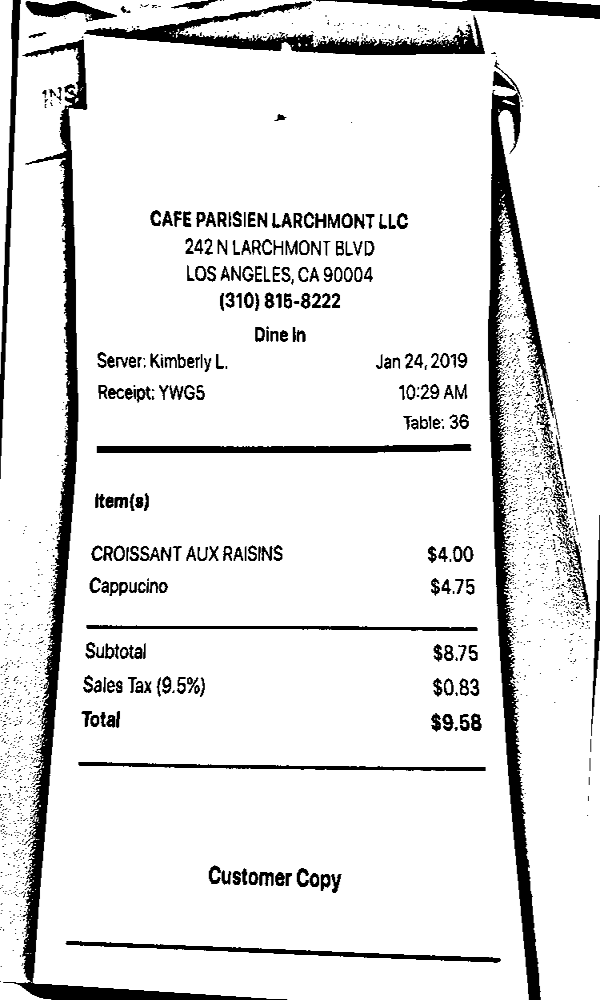

In [123]:
FolderPath = './receiptsDataset/images'
ImagePath = os.path.join(FolderPath,'1057-receipt.jpg')

image = cv2.imread(ImagePath)

height, width = image.shape[:2]

angle = -3

# Calculate the rotation matrix
rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)

# Apply the rotation to the image
image = cv2.warpAffine(image, rotation_matrix, (width, height))

image = ProcessImage(image=image)

print(pytesseract.image_to_data(image, config = '--psm 4', output_type= 'dict'))
image



In [12]:
DatasetSROIE2019V1.to_pickle('DatasetSROIE2019V3')

In [5]:
ner_tags_SROIE2019 = []


for indx ,row in tqdm(DatasetSROIE2019V1.iterrows()):
    words = row['words'] 
    boxes = row['boxes']
    entities = row['entities']


    ner_tags = AssignNERTags(words=words,entities=entities,boxes=boxes)

    ner_tags_SROIE2019.append(ner_tags)
    


DatasetSROIE2019V1['ner_tags'] = ner_tags_SROIE2019


DatasetSROIE2019V1



0it [00:00, ?it/s]

626it [00:15, 40.70it/s]


,filename,entities,words,boxes,ner_tags
0,X00016469612.jpg,"{'COMPANY': 'BOOK TA .K (TAMAN DAYA) SDN BHD',...","[tan, woon, yann, BOOK, TA, .K, (TAMAN, DAYA),...","[[161, 32, 275, 55], [298, 36, 496, 55], [520,...","[O, O, O, COMPANY, COMPANY, COMPANY, COMPANY, ..."
1,X00016469619.jpg,"{'COMPANY': 'INDAH GIFT & HOME DECO', 'LOCATIO...","[tan, woon, yann, INDAN, GIFT, &, HOME, DECO, ...","[[178, 52, 296, 76], [321, 57, 531, 76], [555,...","[O, O, O, O, COMPANY, COMPANY, COMPANY, COMPAN..."
2,X00016469620.jpg,"{'COMPANY': 'MR D.I.Y. (JOHOR) SDN BHD', 'LOCA...","['., tan, woon, yann, WR, D.1.¥., (JOHOR), SON...","[[161, 42, 211, 70], [243, 53, 378, 89], [403,...","[O, O, O, O, O, O, COMPANY, O, COMPANY, O, O, ..."
3,X00016469622.jpg,"{'COMPANY': 'YONGFATT ENTERPRISE', 'LOCATION':...","[tan, woon, yann, YONGFATT, ENTERPRISE, (JMG17...","[[221, 50, 333, 76], [358, 56, 558, 76], [581,...","[O, O, O, COMPANY, COMPANY, O, O, LOCATION, LO..."
4,X00016469623.jpg,"{'COMPANY': 'MR D.I.Y. (M) SDN BHD', 'LOCATION...","[7, «, r, tan, woon, yann, UR, _D.7.Y., (4), S...","[[268, 6, 296, 13], [663, 20, 670, 28], [860, ...","[O, O, O, O, O, O, O, O, O, COMPANY, COMPANY, ..."
...,...,...,...,...,...
621,X51008164997.jpg,{'COMPANY': 'ONE ONE THREE SEAFOOD RESTAURANT ...,"[INE, ONE, THREE, SEAFOOD, RESTAURAN7., SON, B...","[[135, 198, 171, 215], [191, 198, 246, 215], [...","[O, COMPANY, COMPANY, COMPANY, COMPANY, O, COM..."
622,X51008164998.jpg,{'COMPANY': 'ONE ONE THREE SEAFOOD RESTAURANT ...,"[.0NE, ONE, THREE, SEAFOOD, RESTAURANT, SDN, B...","[[80, 211, 173, 233], [193, 211, 250, 229], [2...","[O, COMPANY, COMPANY, COMPANY, COMPANY, COMPAN..."
623,X51008164999.jpg,{'COMPANY': 'ONE ONE THREE SEAFOOD RESTAURANT ...,"[CNE, ONE, THREE, SEAFOOD, RESTAURANT, SDN, BH...","[[113, 173, 170, 188], [190, 173, 246, 188], [...","[O, COMPANY, COMPANY, COMPANY, COMPANY, COMPAN..."
624,X51009453801.jpg,"{'COMPANY': 'GL HANDICRAFT & TAILORING', 'LOCA...","[3180303, GL, HANDICRAFT, &, TAILORING, 19., J...","[[33, 31, 223, 48], [181, 152, 236, 169], [251...","[O, COMPANY, COMPANY, COMPANY, COMPANY, O, LOC..."


In [3]:
DatasetSROIE2019V1 = pd.read_pickle('DatasetSROIE2019V3')

## TEST OF THE MODEL

In [6]:
from transformers import LayoutLMv3ForTokenClassification, LayoutLMv3Tokenizer, LayoutLMv3FeatureExtractor, LayoutLMv3TokenizerFast,LayoutLMv3Processor
from PIL import Image, ImageDraw, ImageFont
import torch

# load model and processor from huggingface hub
feature_extractor = LayoutLMv3FeatureExtractor(apply_ocr= False, do_normalize= True, do_resize= True)
tokenizer = LayoutLMv3TokenizerFast.from_pretrained("microsoft/layoutlmv3-base")
processor = LayoutLMv3Processor(feature_extractor,tokenizer)

In [7]:
words = DatasetSROIE2019V1['words'][0]
boxes = DatasetSROIE2019V1['boxes'][0]
image_file = DatasetSROIE2019V1['filename'][0]
image_path = os.path.join('SROIE2019/train/img' , image_file)

image = Image.open(image_path)
image = image.resize((600,1000))


encoding = processor(image, words, boxes=boxes, max_length=512, padding ='max_length', truncation = True, return_tensors="pt")

print(f"""
input_ids:  {list(encoding["input_ids"].squeeze().shape)}
word boxes: {list(encoding["bbox"].squeeze().shape)}
image data: {list(encoding["pixel_values"].squeeze().shape)}
image size: {image.size}
""")



input_ids:  [512]
word boxes: [512, 4]
image data: [3, 224, 224]
image size: (600, 1000)



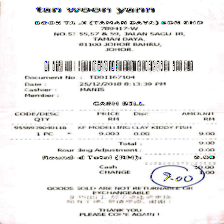

In [8]:
import torchvision.transforms as T
image_data = encoding["pixel_values"][0]
transform = T.ToPILImage()
transform(image_data)

We instanciate our model for token classification, as we want to actually predict for each token the class that it belongs to 

In [9]:
model = LayoutLMv3ForTokenClassification.from_pretrained('microsoft/layoutlmv3-base', num_labels = 6)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
encoding = encoding.to(device)
outputs = model(**encoding)


Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Natsu\Anaconda3\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [2]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained(
            "microsoft/layoutlmv3-base",
            num_labels=7
        )

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
for p,n in model.named_parameters():
    print(p)

layoutlmv3.cls_token
layoutlmv3.pos_embed
layoutlmv3.embeddings.word_embeddings.weight
layoutlmv3.embeddings.token_type_embeddings.weight
layoutlmv3.embeddings.LayerNorm.weight
layoutlmv3.embeddings.LayerNorm.bias
layoutlmv3.embeddings.position_embeddings.weight
layoutlmv3.embeddings.x_position_embeddings.weight
layoutlmv3.embeddings.y_position_embeddings.weight
layoutlmv3.embeddings.h_position_embeddings.weight
layoutlmv3.embeddings.w_position_embeddings.weight
layoutlmv3.patch_embed.proj.weight
layoutlmv3.patch_embed.proj.bias
layoutlmv3.LayerNorm.weight
layoutlmv3.LayerNorm.bias
layoutlmv3.norm.weight
layoutlmv3.norm.bias
layoutlmv3.encoder.layer.0.attention.self.query.weight
layoutlmv3.encoder.layer.0.attention.self.query.bias
layoutlmv3.encoder.layer.0.attention.self.key.weight
layoutlmv3.encoder.layer.0.attention.self.key.bias
layoutlmv3.encoder.layer.0.attention.self.value.weight
layoutlmv3.encoder.layer.0.attention.self.value.bias
layoutlmv3.encoder.layer.0.attention.output.den